In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt_colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

import glob

import scipy.fft as fourier
import scipy.signal as signal
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
def crear_csvs():

    filenames = glob.glob('WS2/*.txt')
    for filename in filenames:
        file = open(filename)

        lines = []
        i = 0
        try:
            for line in file:
                i+=1
                if i>=1:
                    lines.append(line[:-1].split('\t'))
            data = pd.DataFrame(lines,columns=['Voltaje [V]','Corriente [A]'])
            data.to_csv(filename[:-4]+'.csv',index=False)
        except BaseException as error:
            print('Error de lectura: '+filename)
            print(f'{error=}')
        file.close()

crear_csvs()

In [3]:
def procesar_datos_foto(nombre,axes):
    data = pd.read_csv(nombre)
    corriente = np.array(data['Corriente [A]']*1e9)
    voltaje = np.array(data['Voltaje [V]'])
    
    fontsize = 24
    
    reg = linregress(corriente,voltaje)
    
    return (corriente,voltaje,corriente*reg.slope+reg.intercept,reg.slope,reg.intercept,reg.rvalue**2,reg.stderr)

def ajuste_lineal(corriente,voltaje,metadata=False):
    if metadata:
        return linregress(corriente,voltaje)
    else:
        m,b,*_ = linregress(corriente,voltaje)
        return m*corriente + b
    
def extraer_csv(filename,T,d,t,l,slopes,stderr):    
    c=d/(np.ones(len(T))*l*slopes*t)
    dict={'Temperature (K)': T+273, 'Resistance (G\u03A9)': slopes, 'Conductivity (S/m)': c, 'Resistance error (G\u03A9)': stderr}
    #dict={'Temperature (K)': T+273, 'Resistance (G\u03A9)': slopes}
    df = pd.DataFrame(dict)
    df.to_csv(filename[:-9]+'conductivity.csv')

In [4]:
def extraer_datos_foto(nombre,axes):
    
    (corriente,voltaje,reg,m,b,r_value,stderr) = procesar_datos_foto(nombre,axes)
    #m = reg.slope
    #b = reg.intercept
    #r_value = reg.rvalue**2
    fontsize = 24
    
    fig_original = axes
    fig_original.scatter(corriente,voltaje,label='Data')
    fig_original.plot(corriente,reg,c='r',label='Fit')
    
    delta_x = np.amax(corriente)-np.amin(corriente)
    delta_y = np.amax(voltaje)-np.amin(voltaje)
    fig_original.set_xlim(np.amin(corriente)-delta_x*0.1,np.amin(corriente)+delta_x*1.1)
    fig_original.set_ylim(np.amin(voltaje)-delta_y*0.1,np.amin(voltaje)+delta_y*1.1)
    
    fig_original.legend(fontsize=fontsize)
    fig_original.label_outer()
    fig_original.set_xlabel('Corriente ($n$A)',fontsize=fontsize)
    fig_original.set_ylabel('Voltaje (V)',fontsize=fontsize)
    fig_original.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    fig_original.yaxis.set_major_locator(plt.MaxNLocator(4))
    fig_original.tick_params(axis='both',labelsize=24)
    fig_original.legend(prop={'size': 22})
    
    return m,b,r_value,stderr

[115.38670738918452, 115.30741861431703, 112.3944096640915, 111.87476564014662, 109.54748112069304, 106.29761234667401, 104.41937972982213, 107.69578959665346, 110.53402774057187, 105.1936950446863, 103.26322780965485, 92.33995721881095, 66.00175085100945, 41.05981520049924, 25.92280059114883, 17.621287114497438, 13.786317961150306, 12.080066383087825, 11.17049008441761]


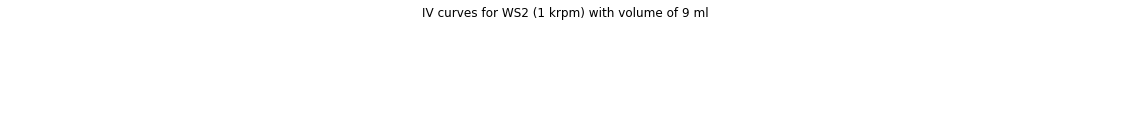

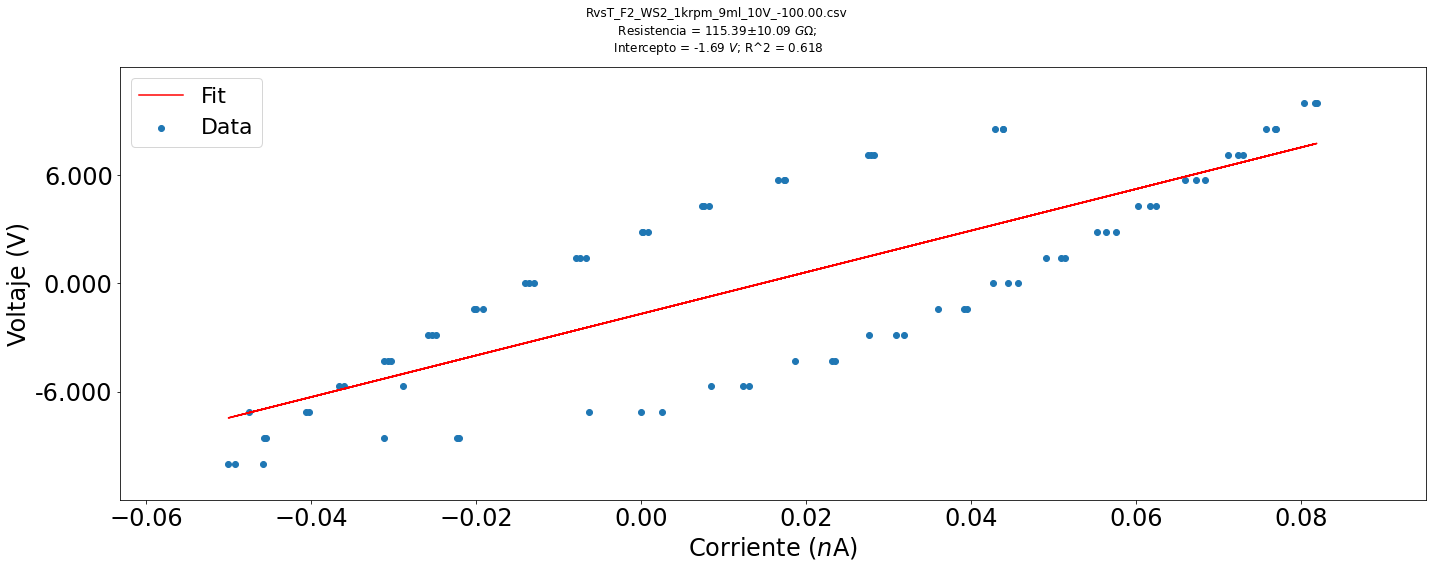

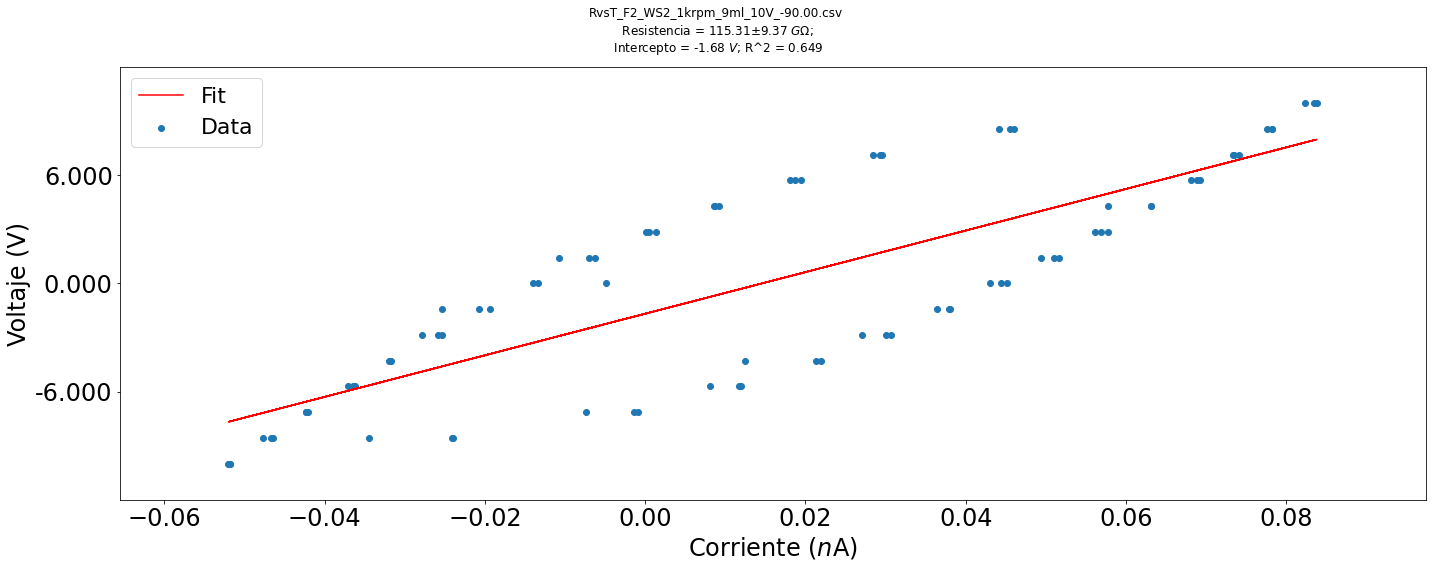

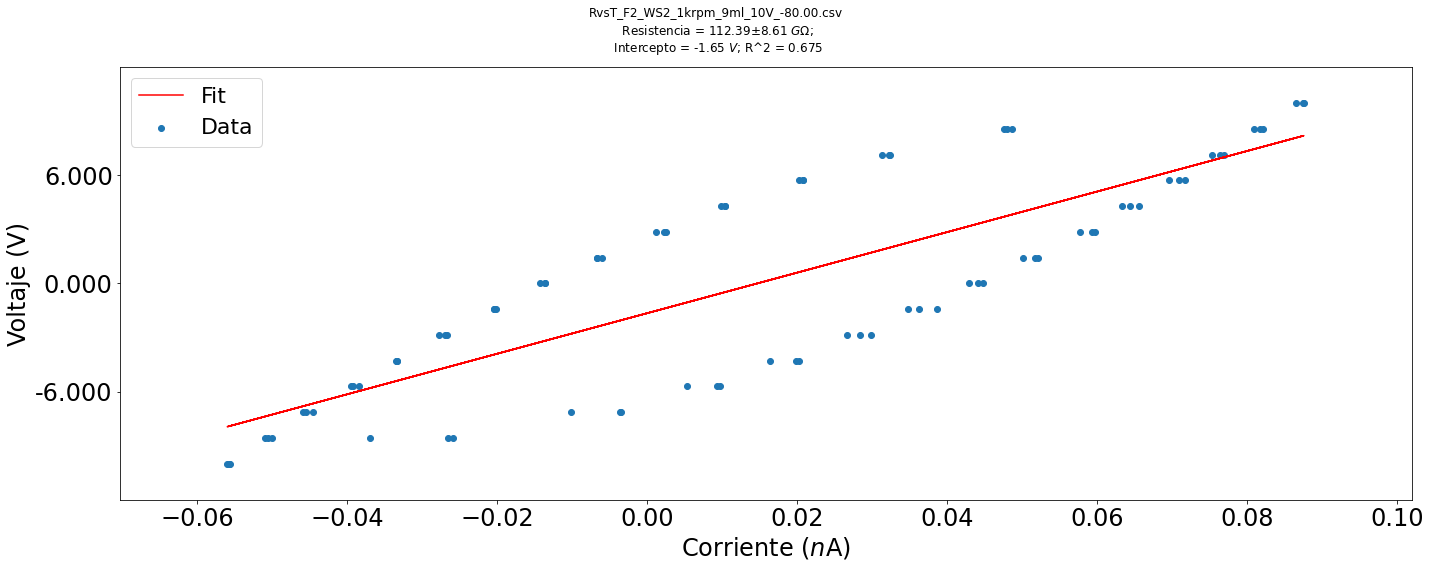

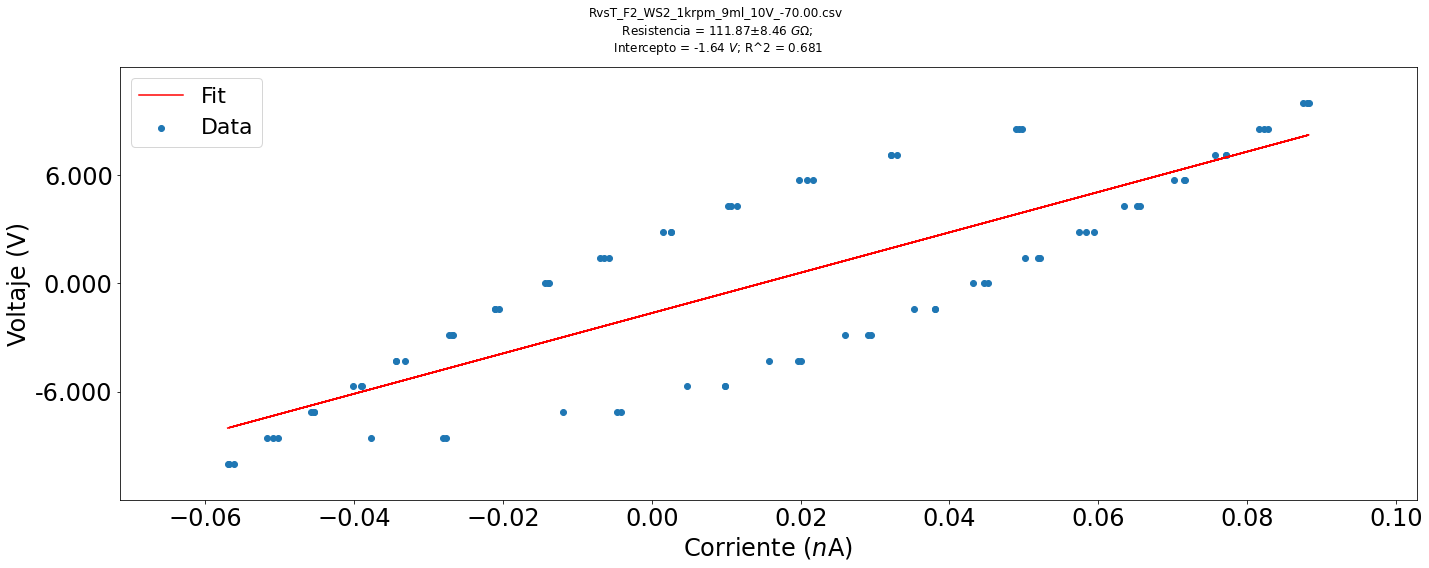

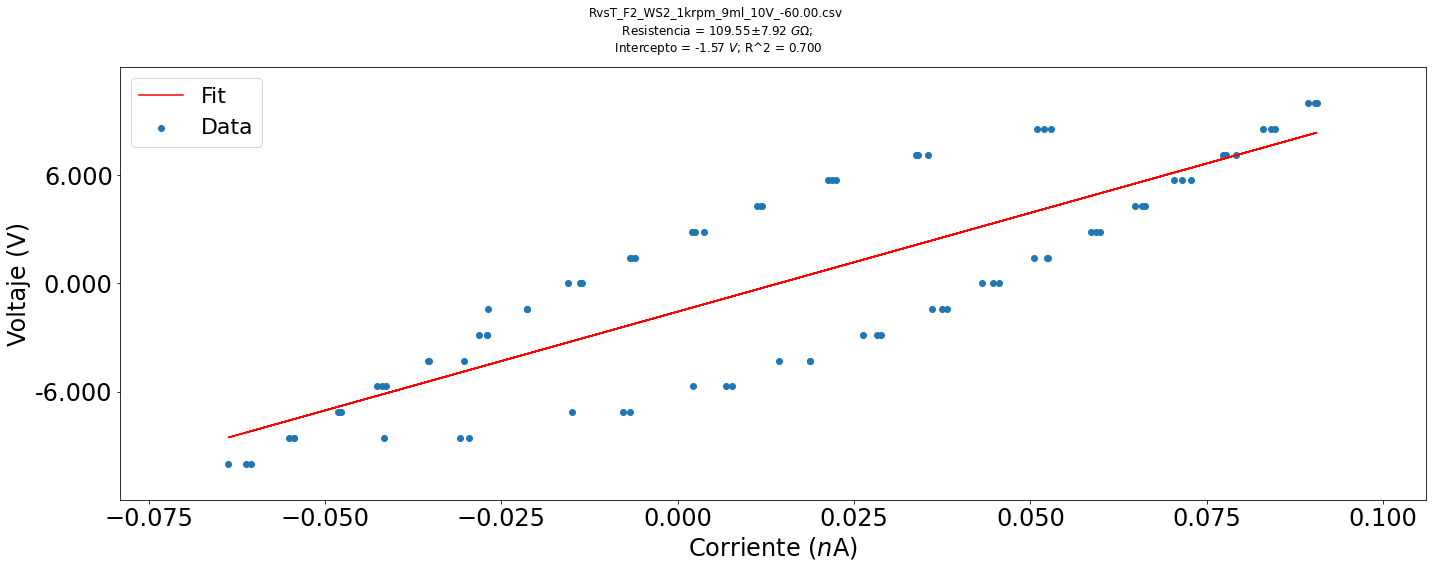

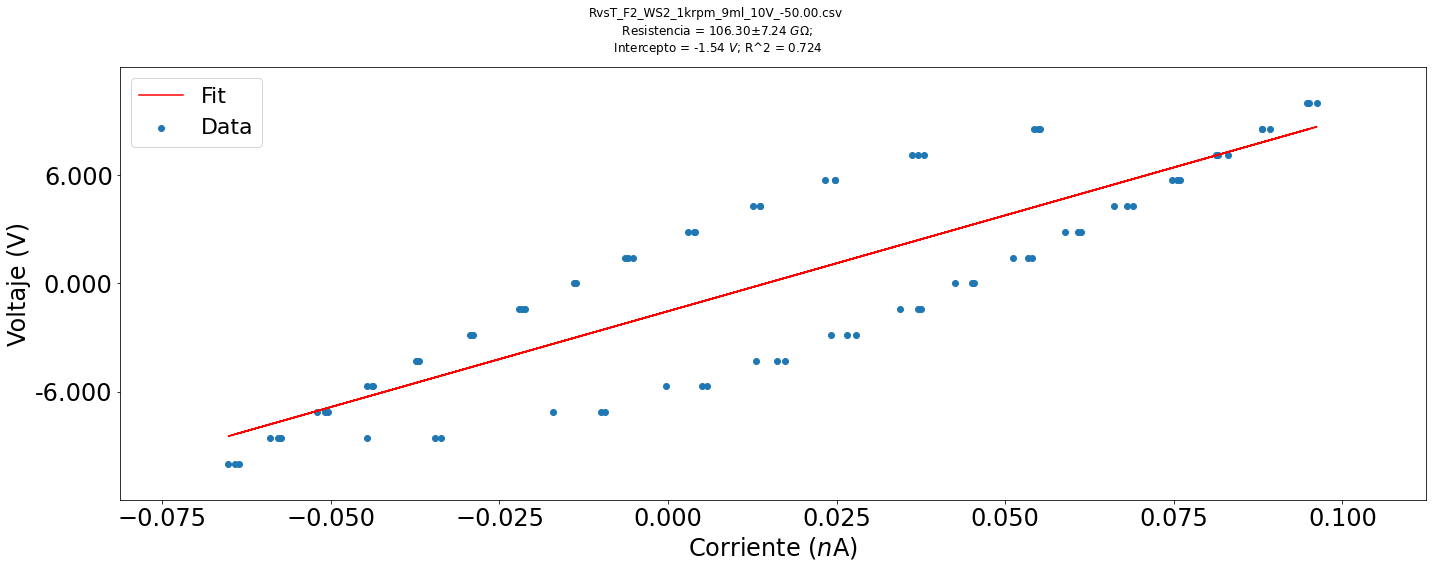

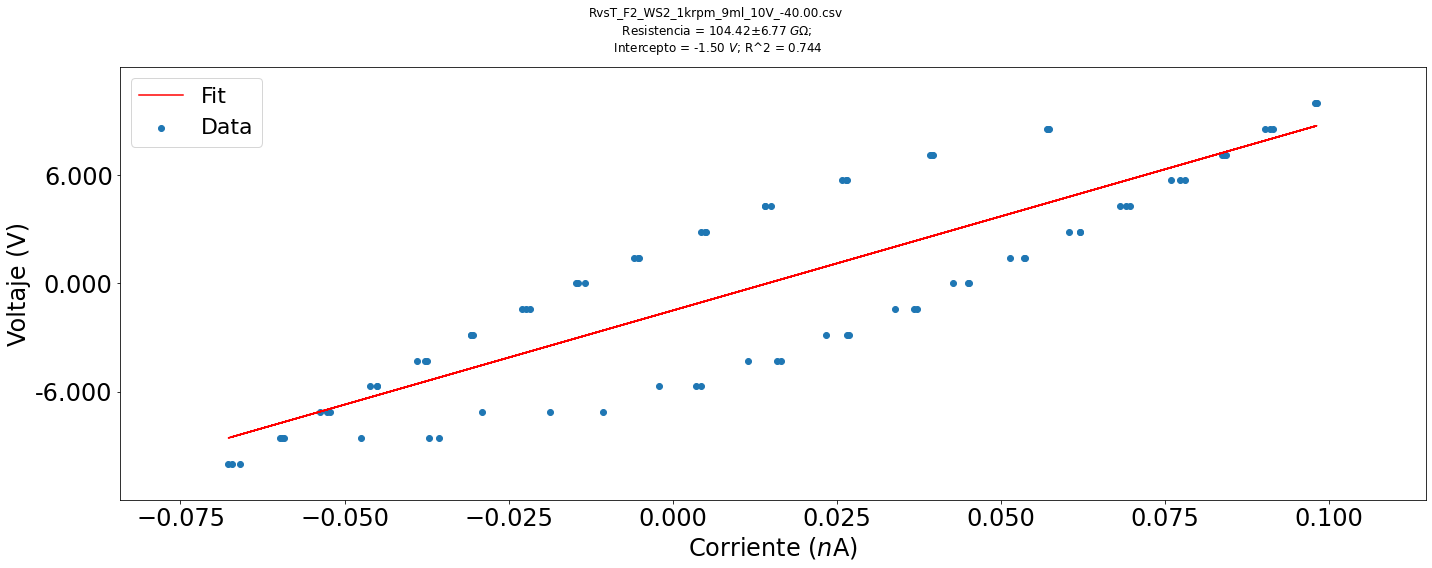

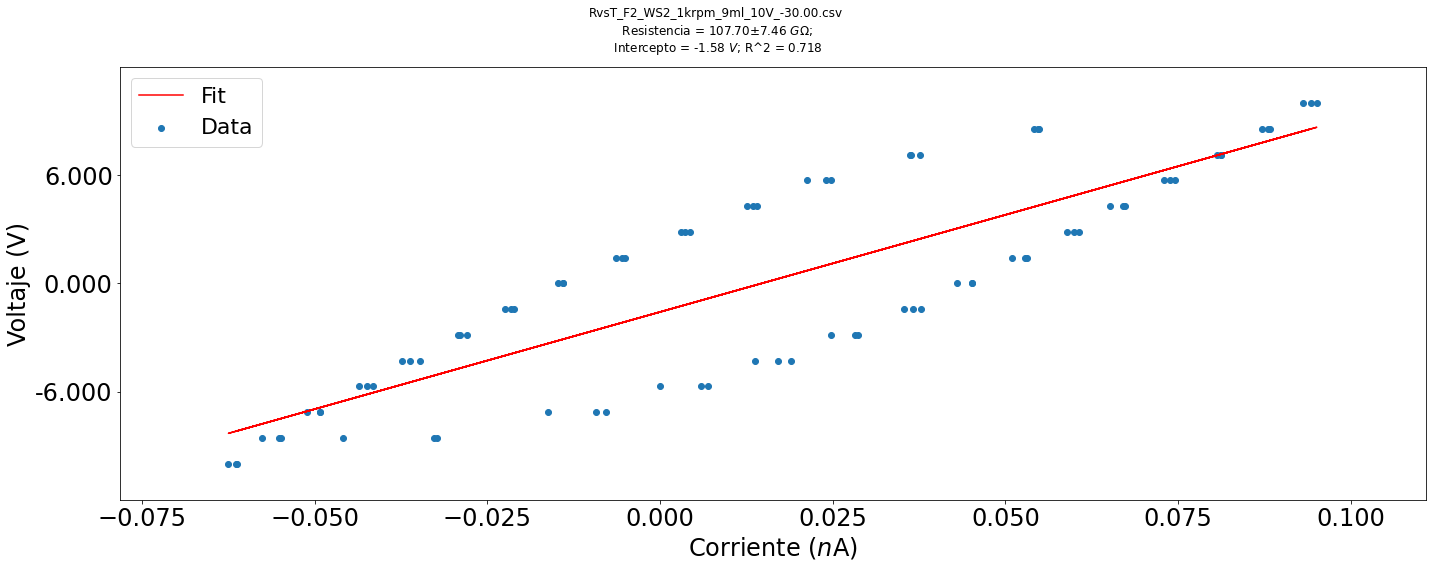

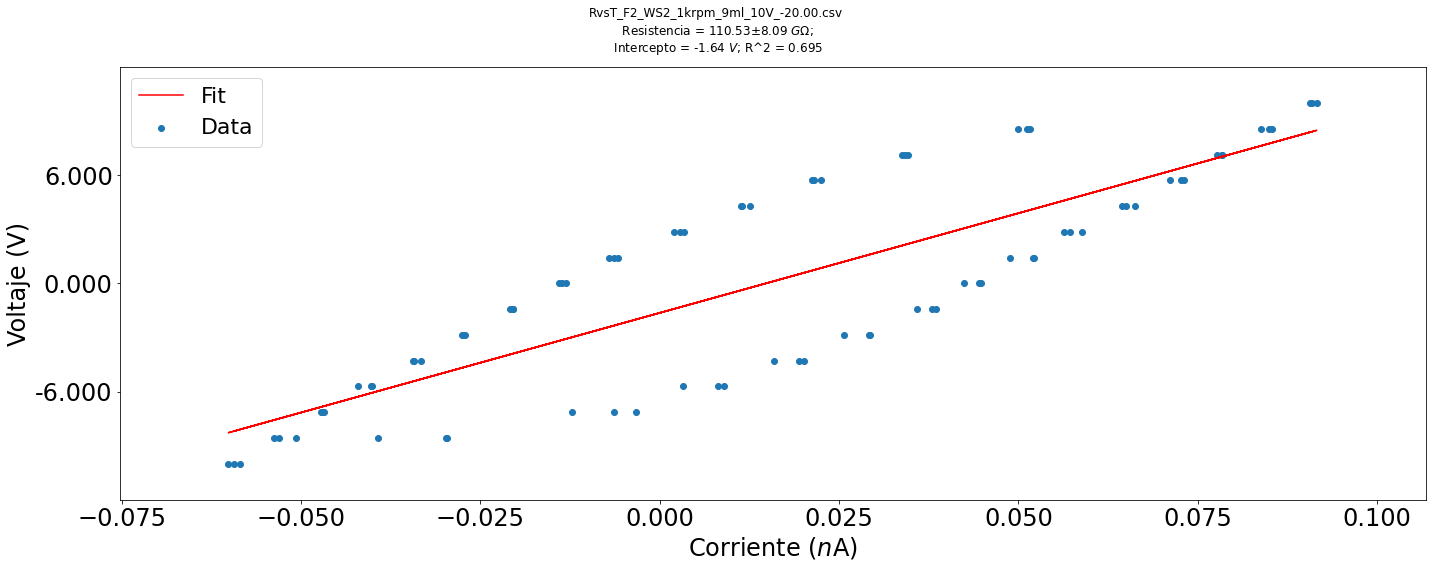

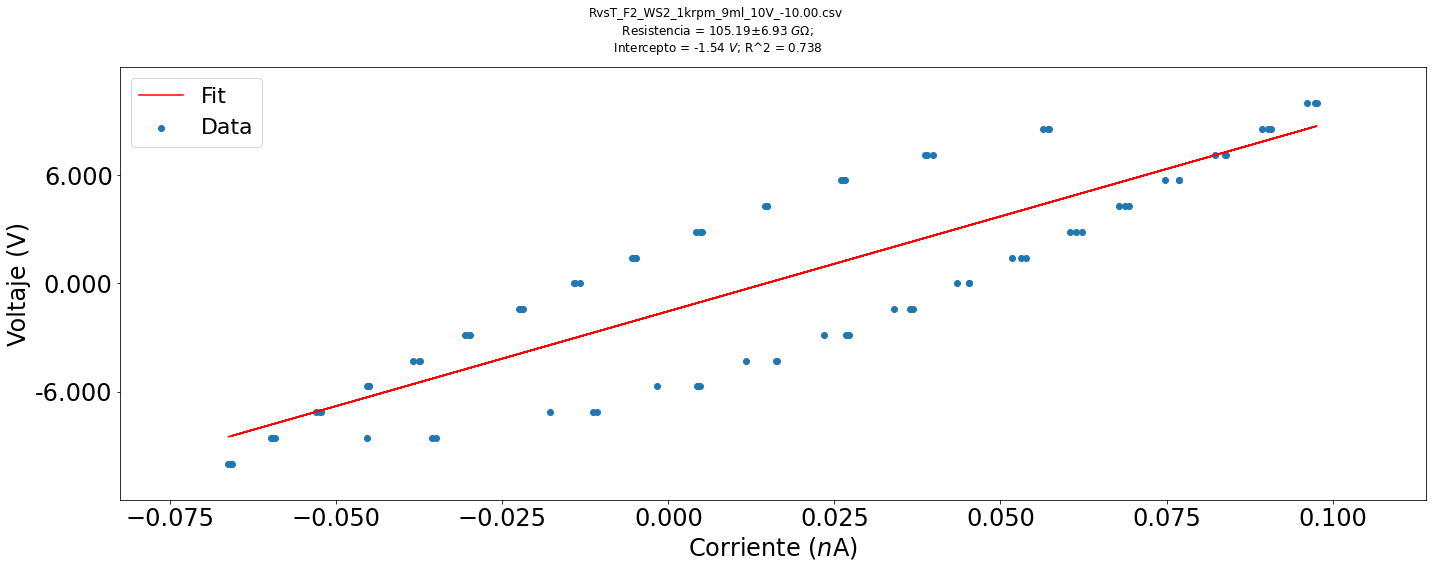

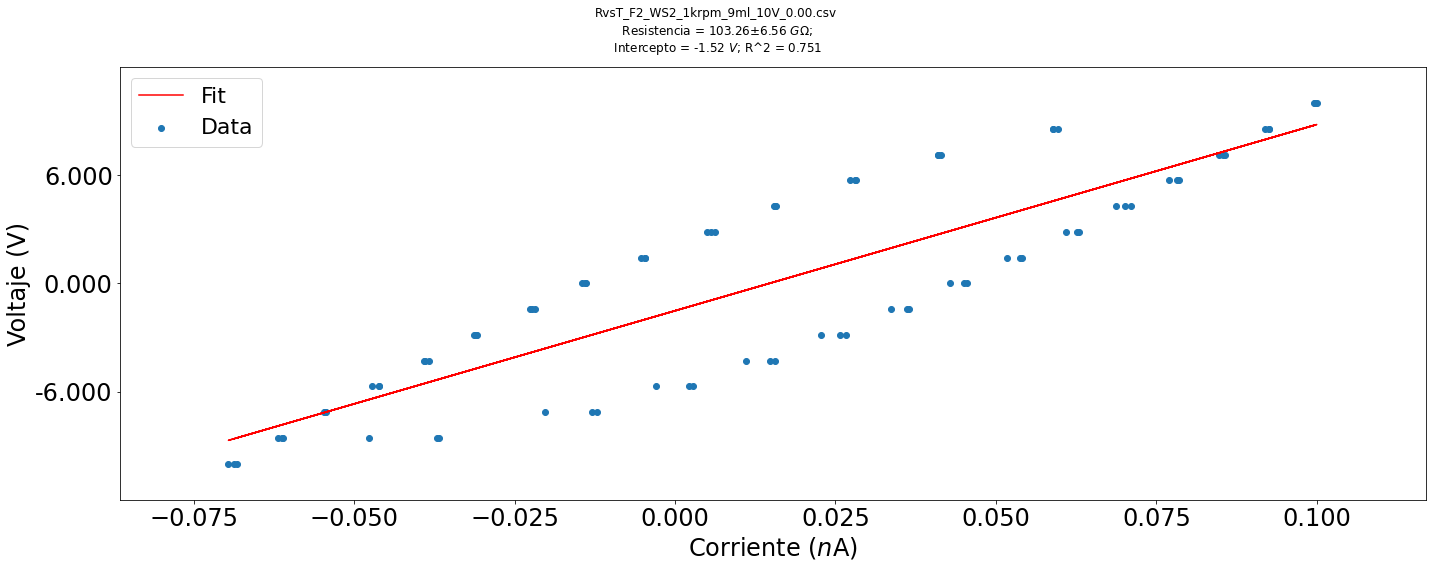

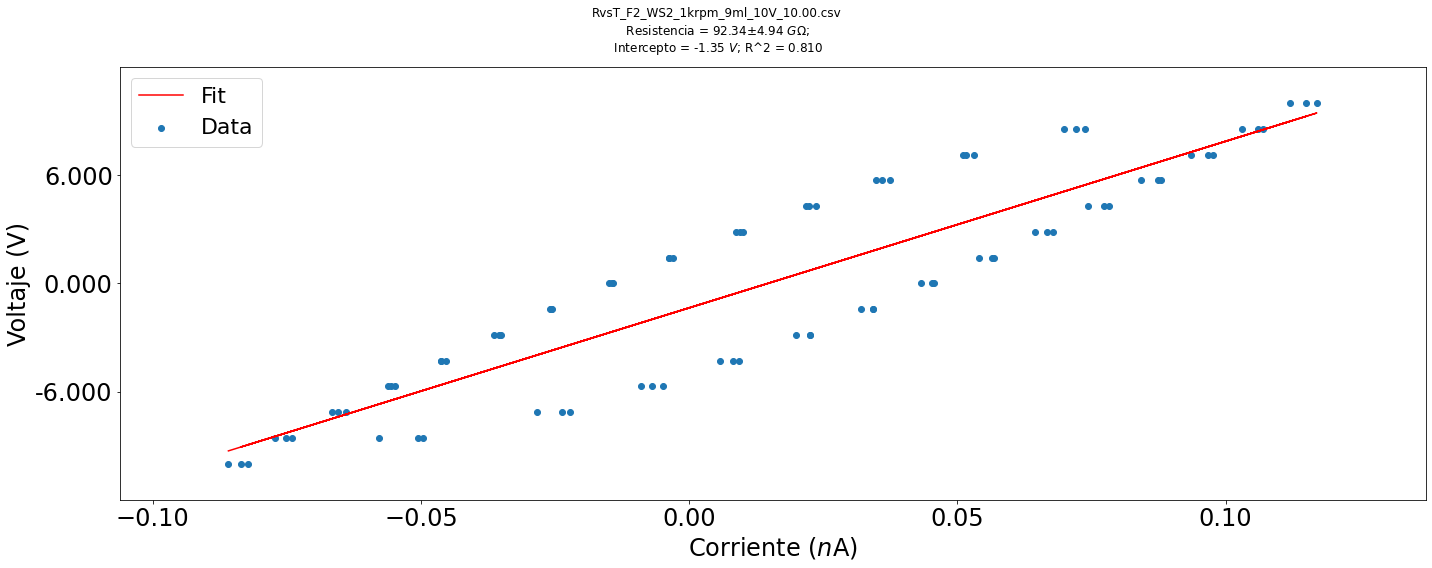

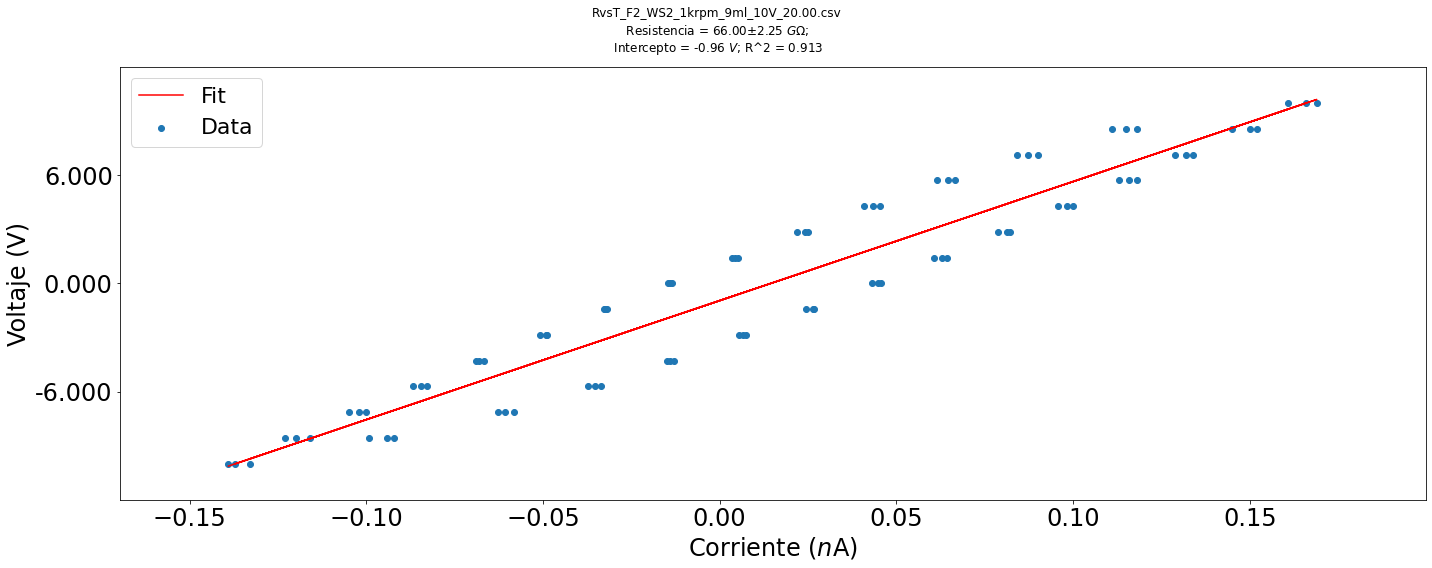

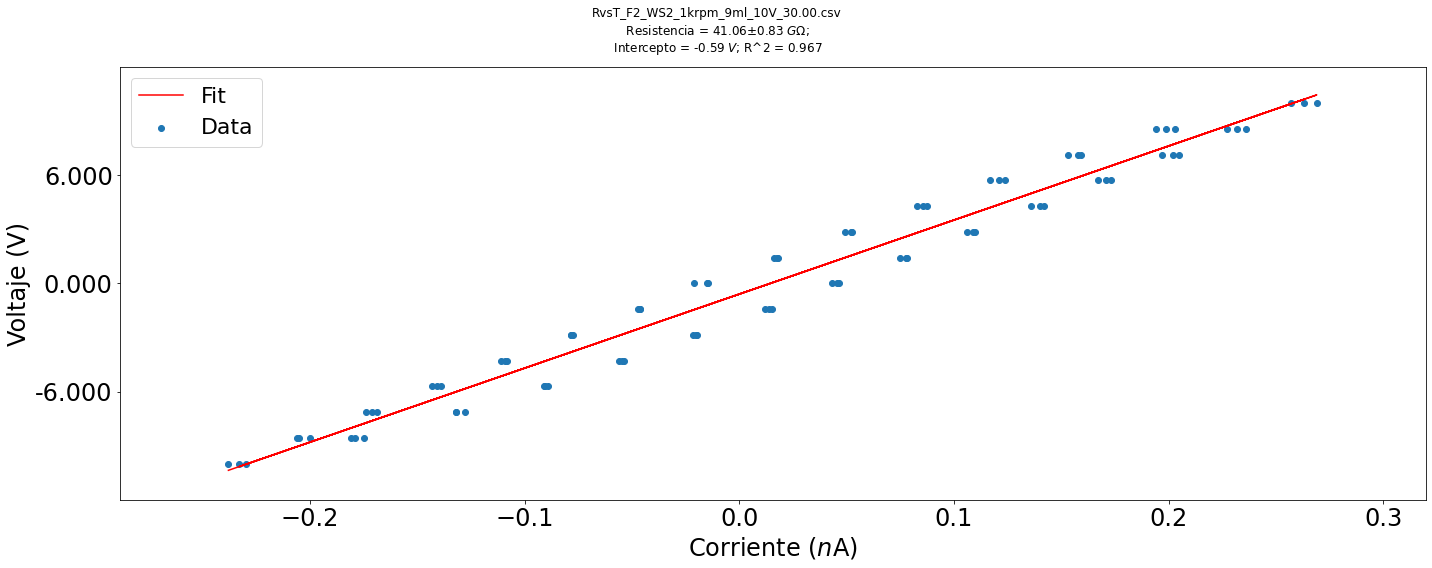

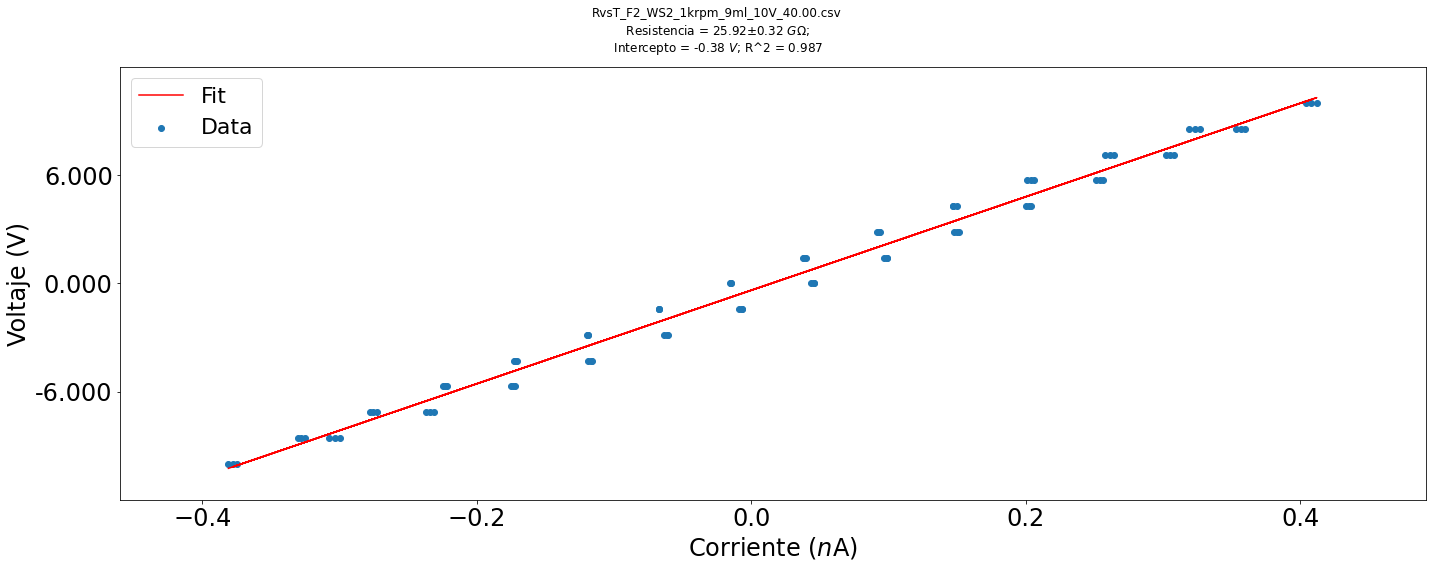

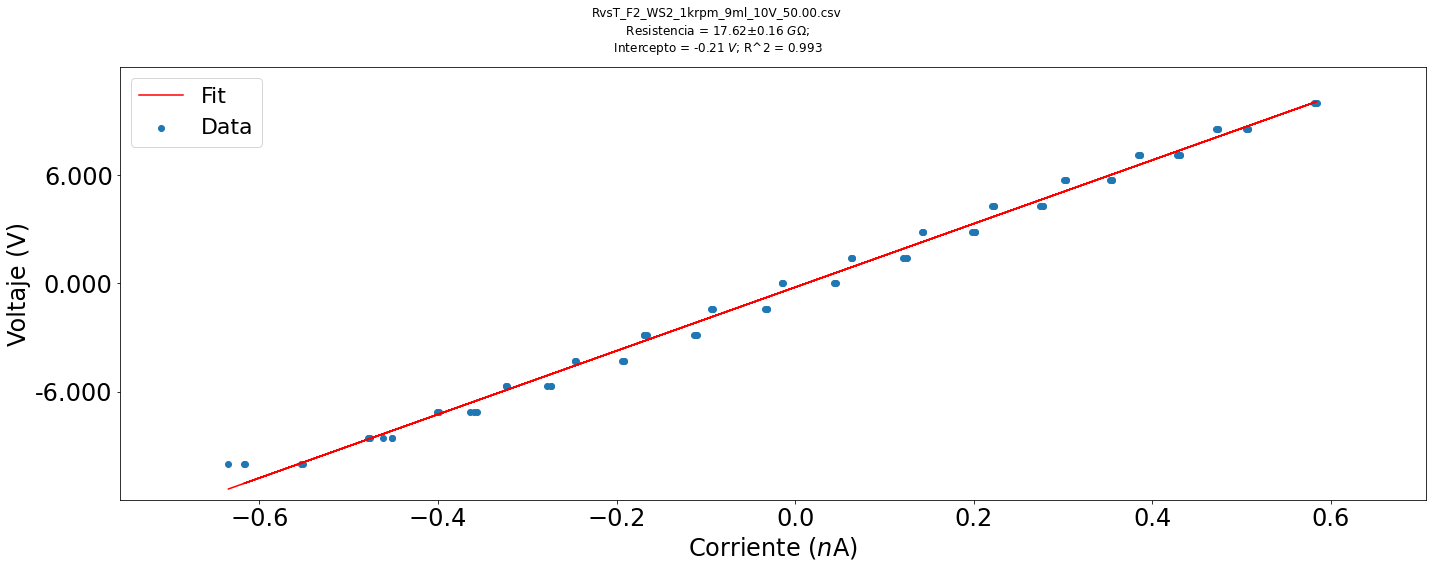

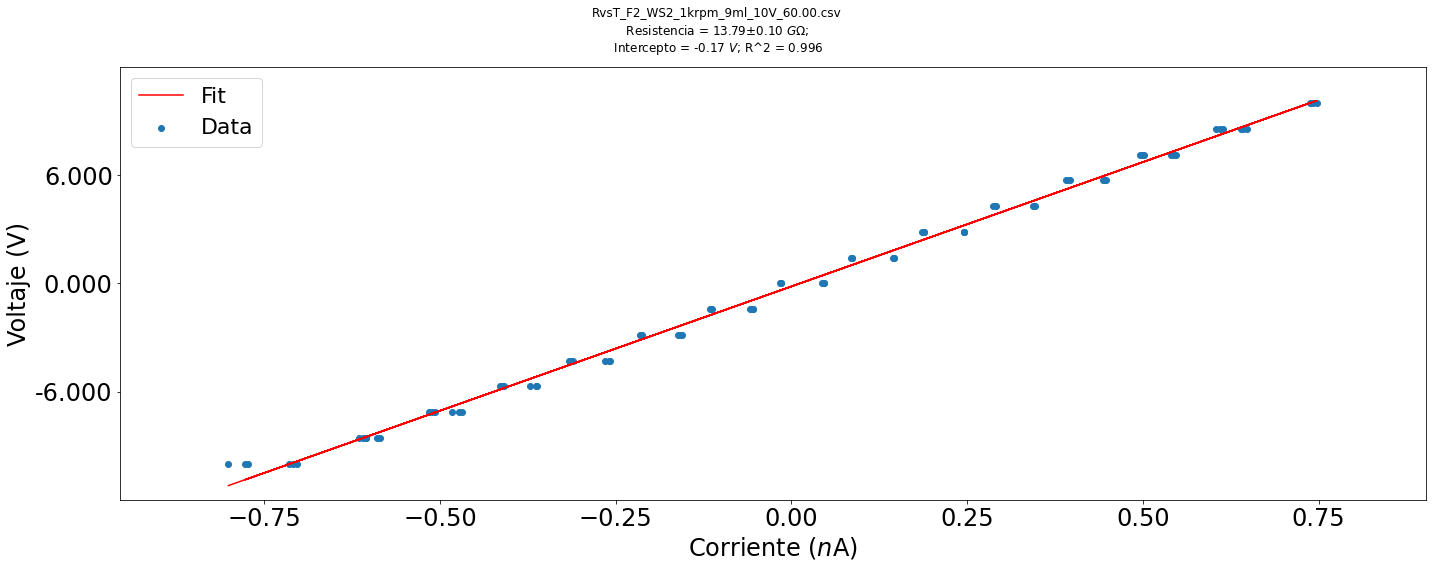

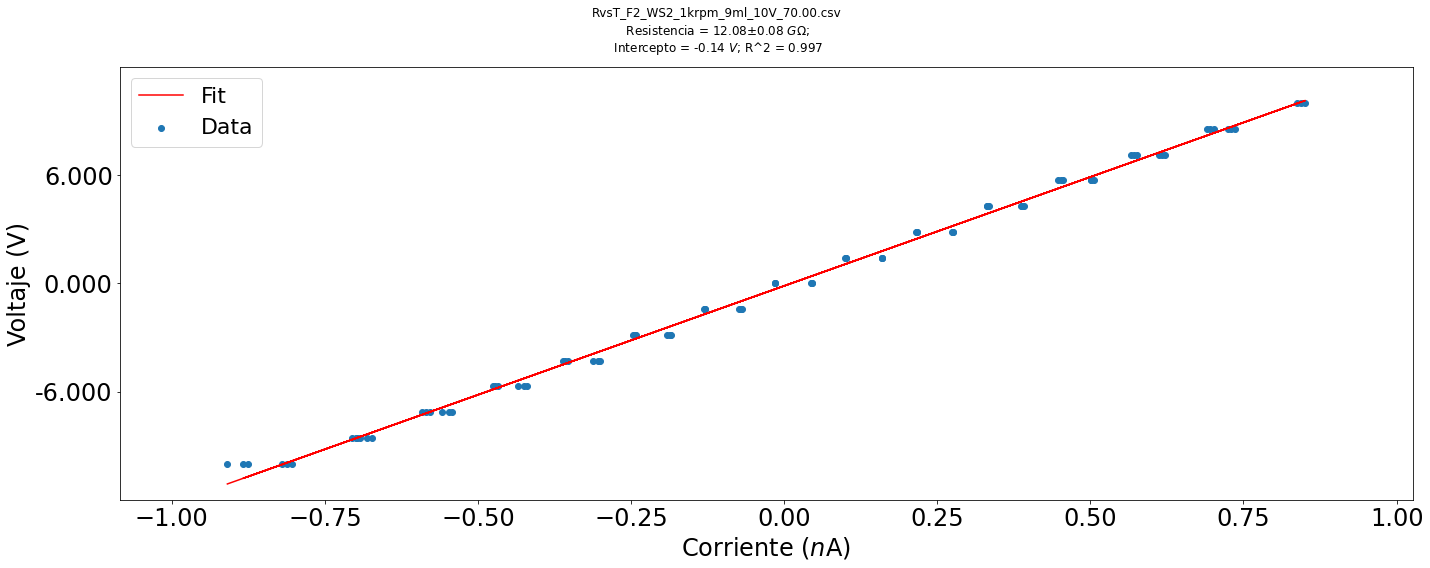

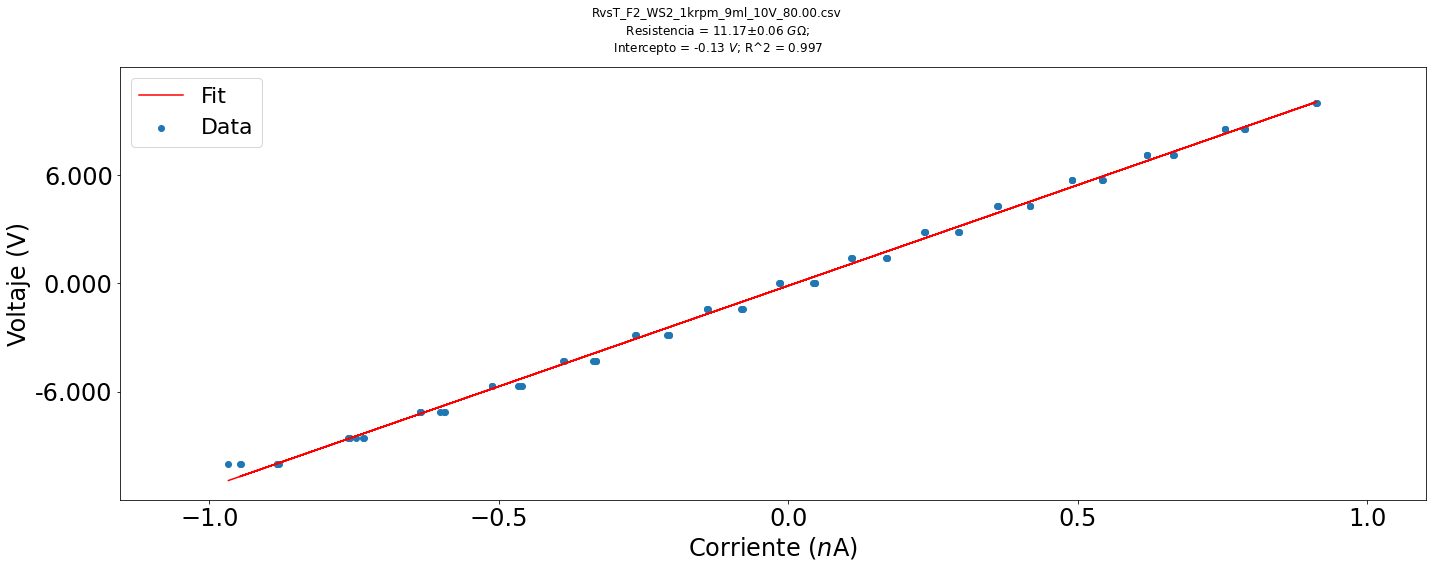

In [18]:
def generate_filenames():
    Tlist = np.linspace(-100,80,19)
    filenames = ['RvsT_F2_WS2_1krpm_9ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-100,80,19)
d = 1.73
t = 224.1
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(19,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for WS2 (1 krpm) with volume of 9 ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)

[8.03632710970228, 7.102357386422309, 6.09011691287787, 5.230469312286127, 5.577907522444868, 5.973904299338613, 6.949271762677812, 7.746943602814177, 7.766885856377628, 7.211698342875646, 7.160792692673128, 7.848248572469775, 6.2793163963265775, 3.927310499717412, 2.2632073876493375, 1.3268040090415611, 0.8618148910932584, 0.6423386956304091, 0.536185856697982]


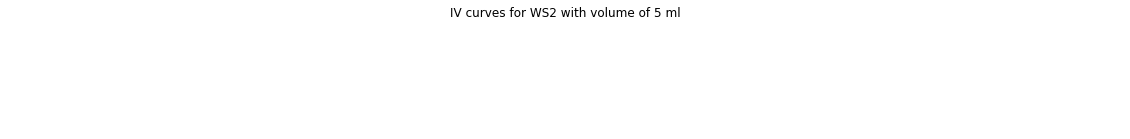

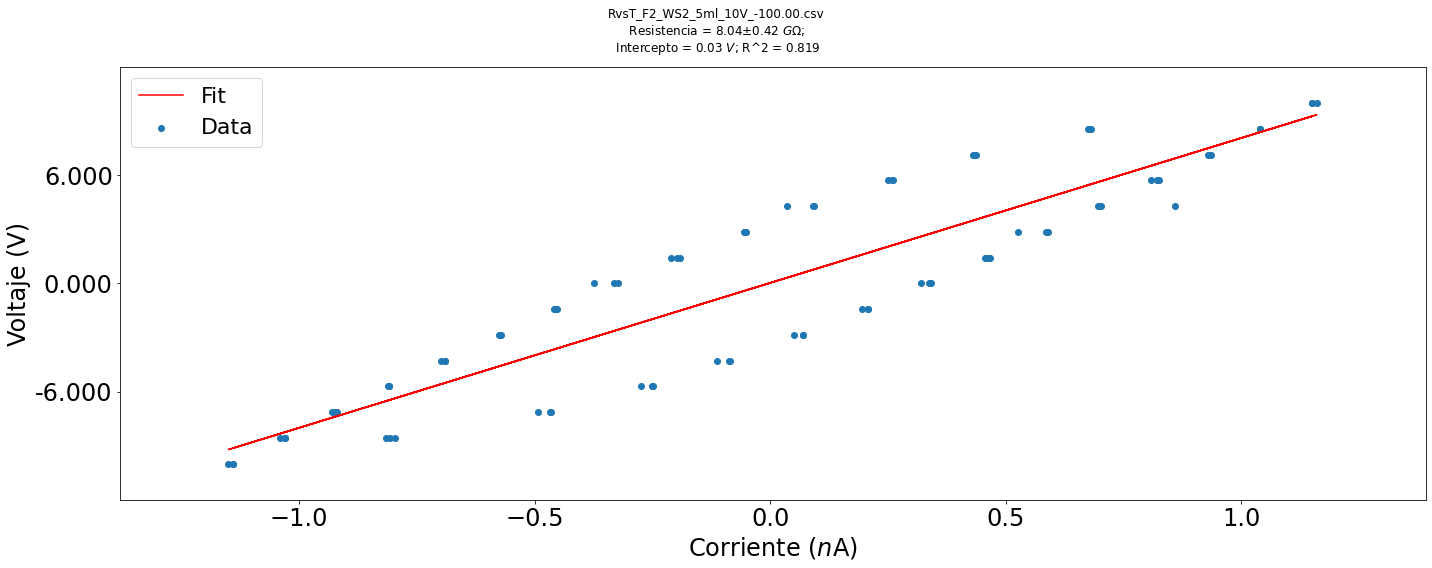

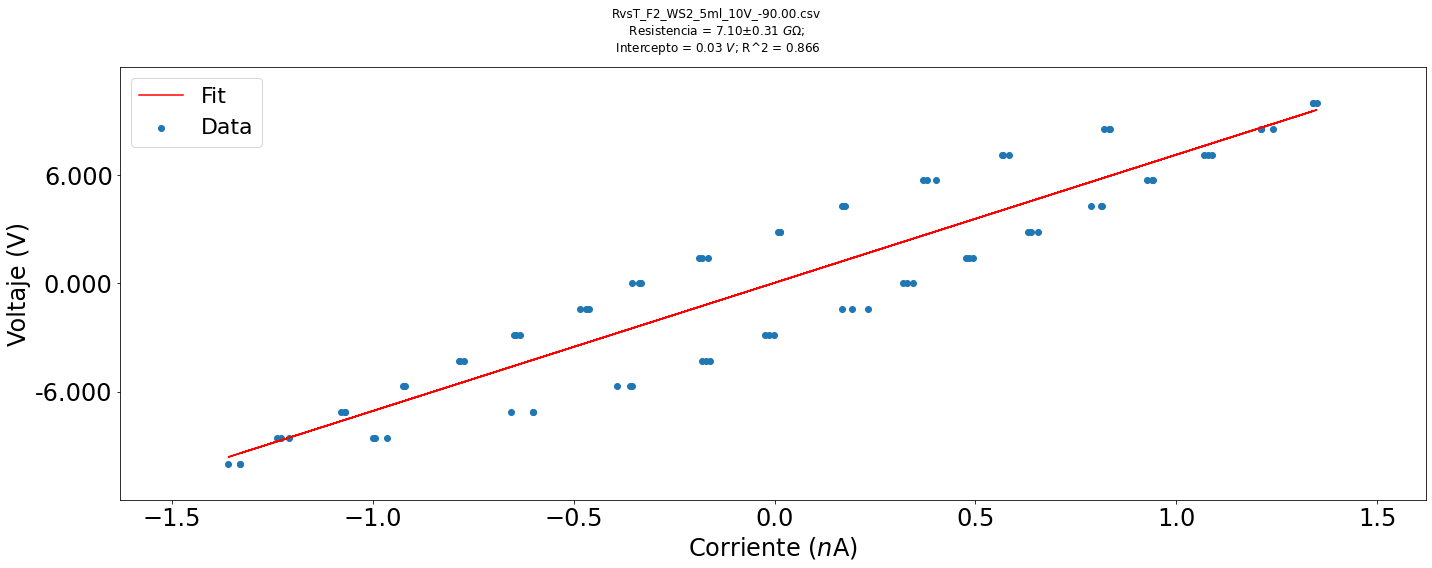

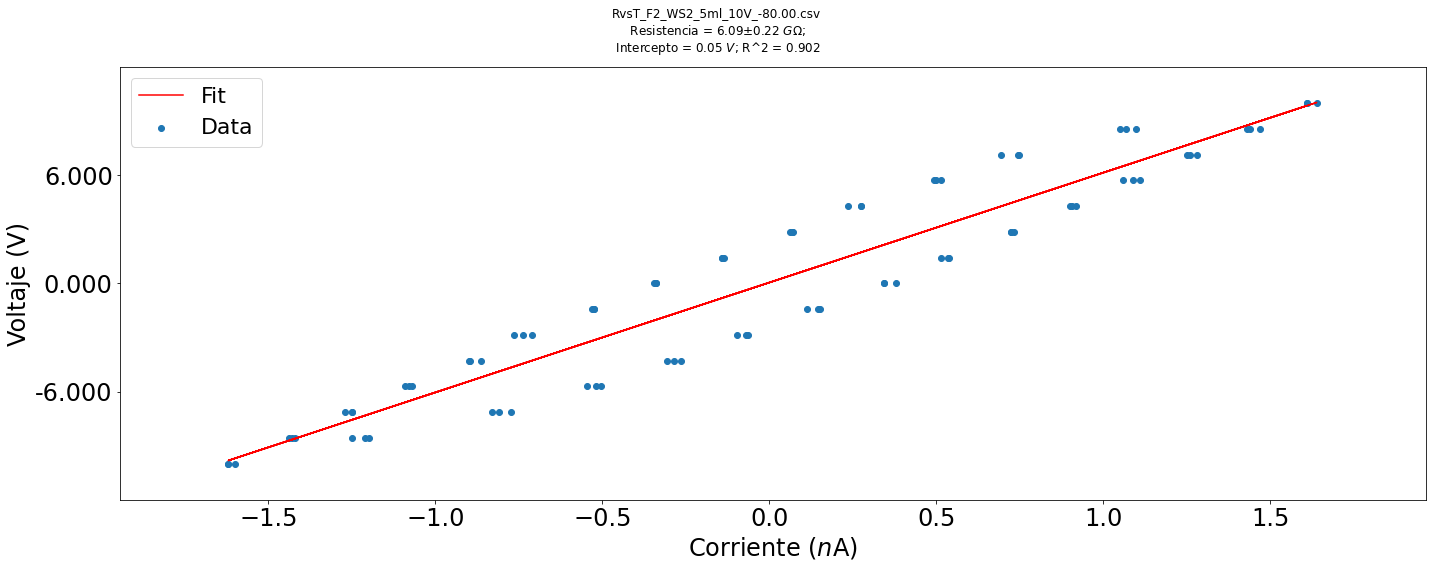

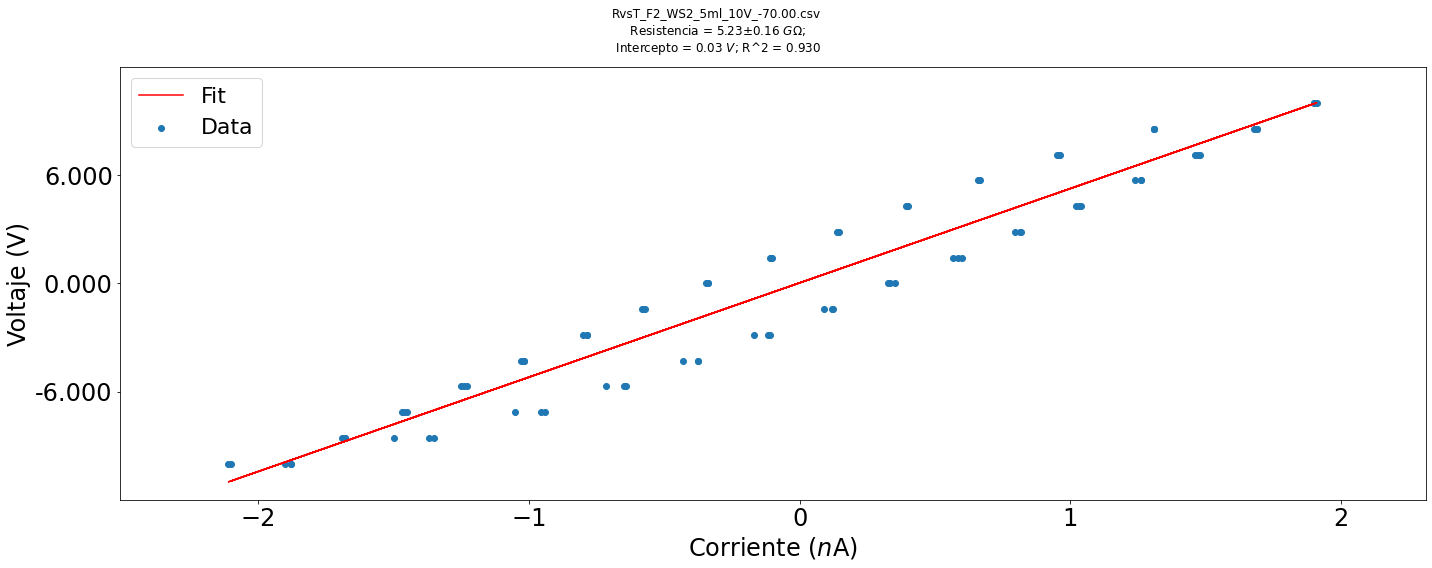

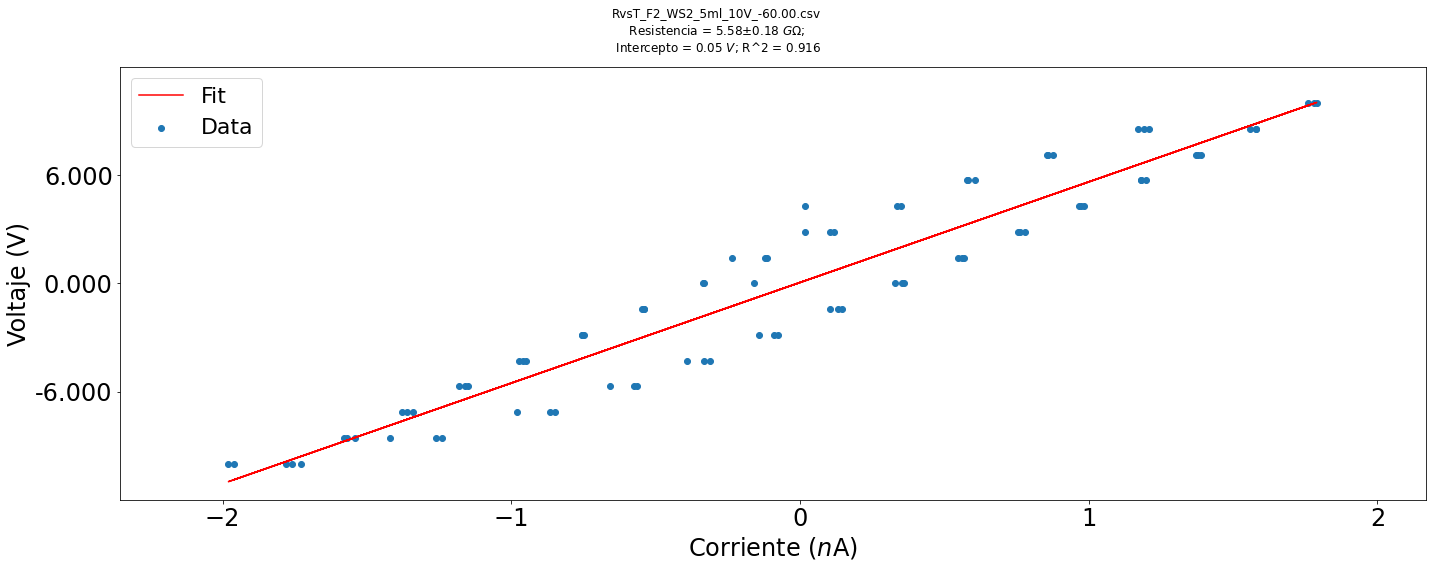

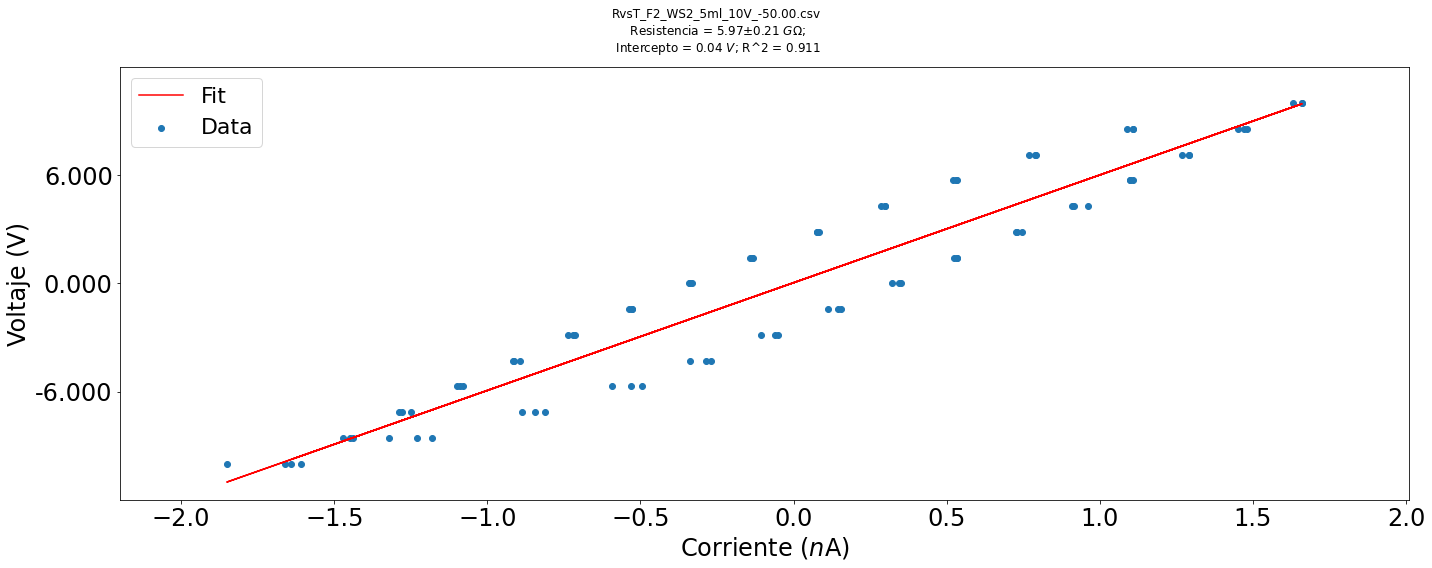

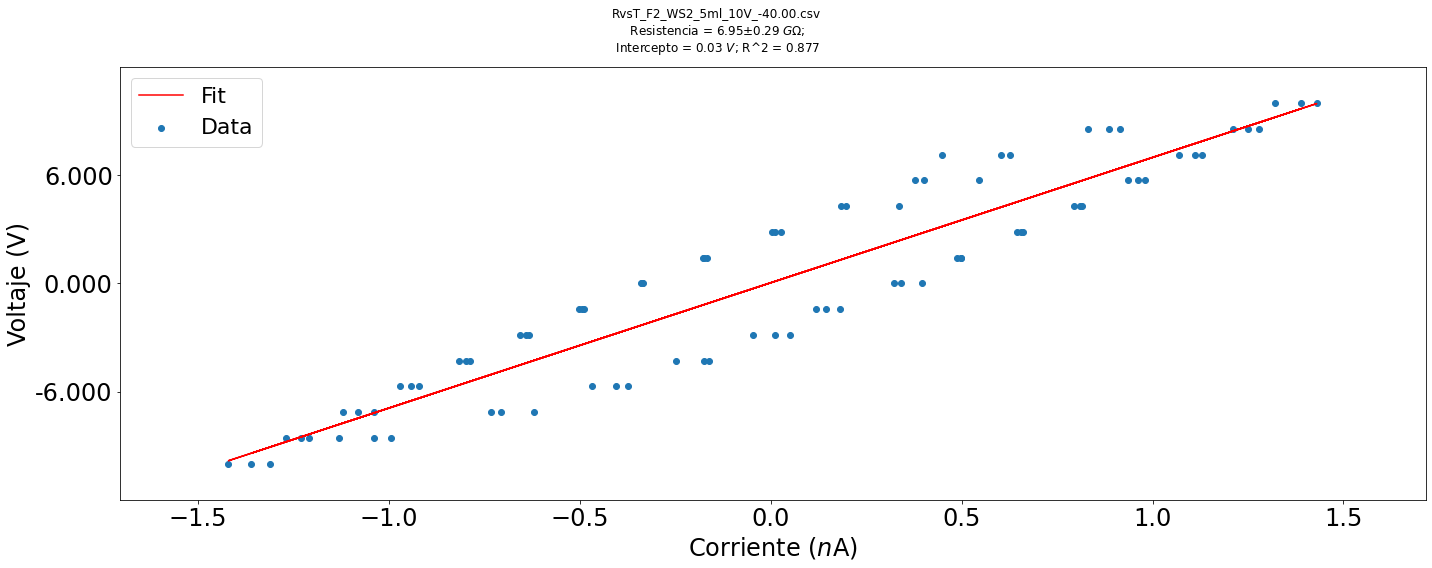

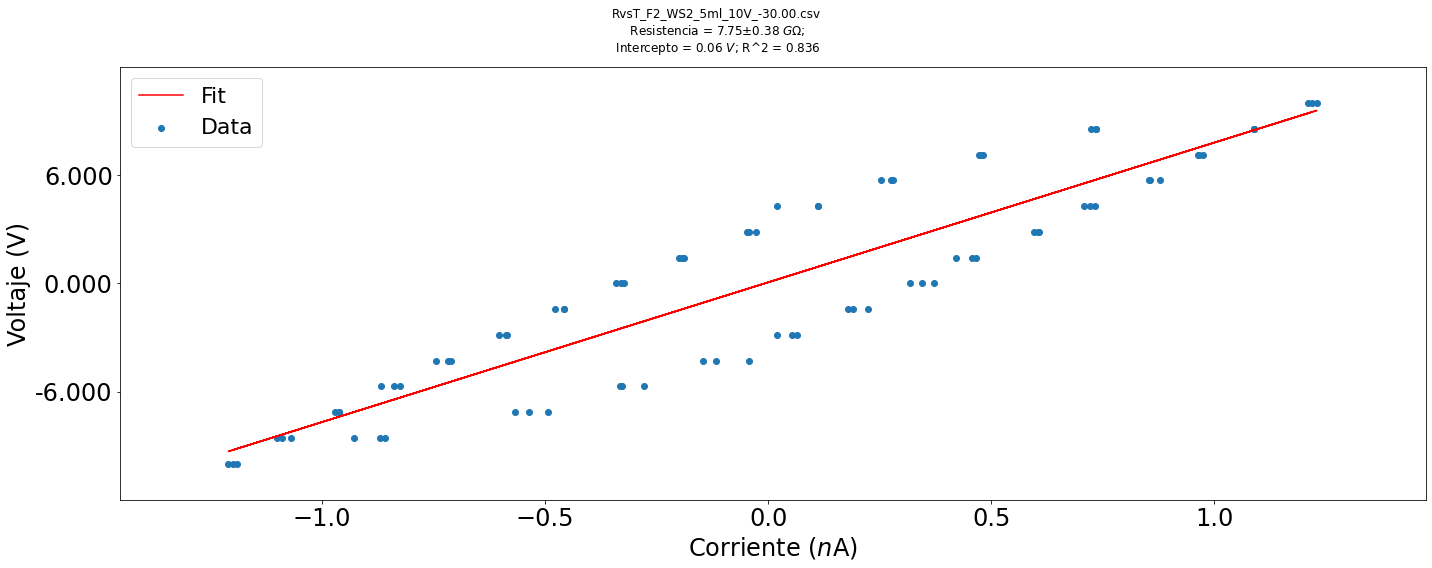

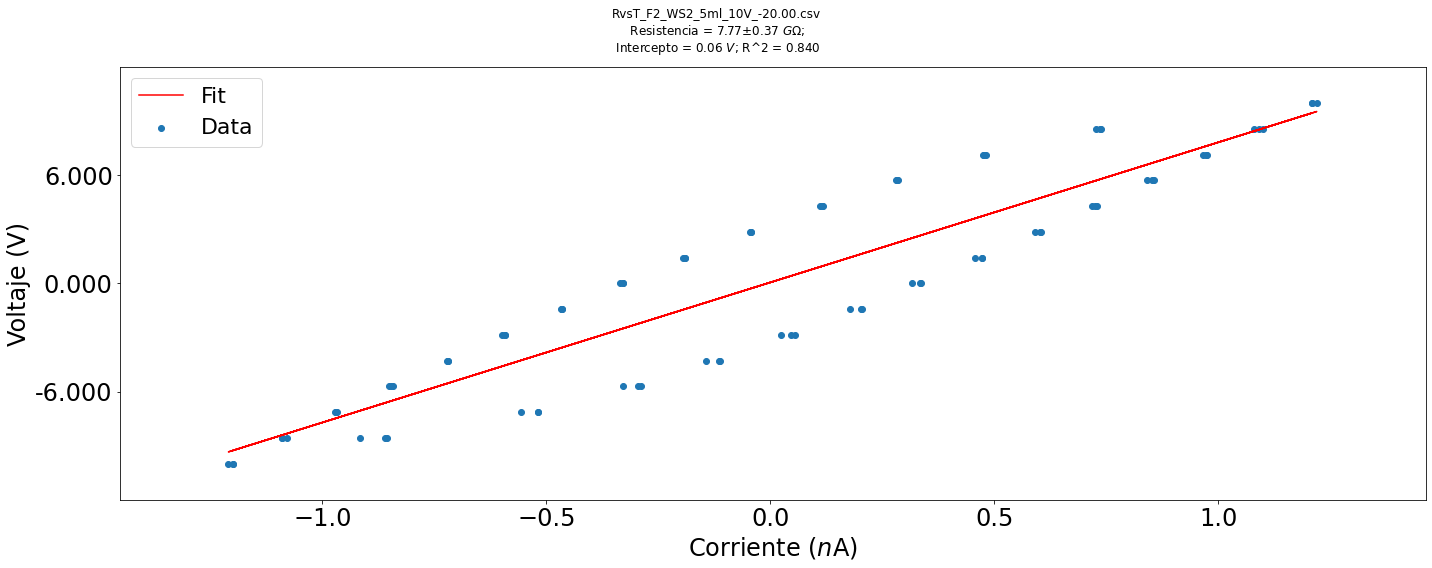

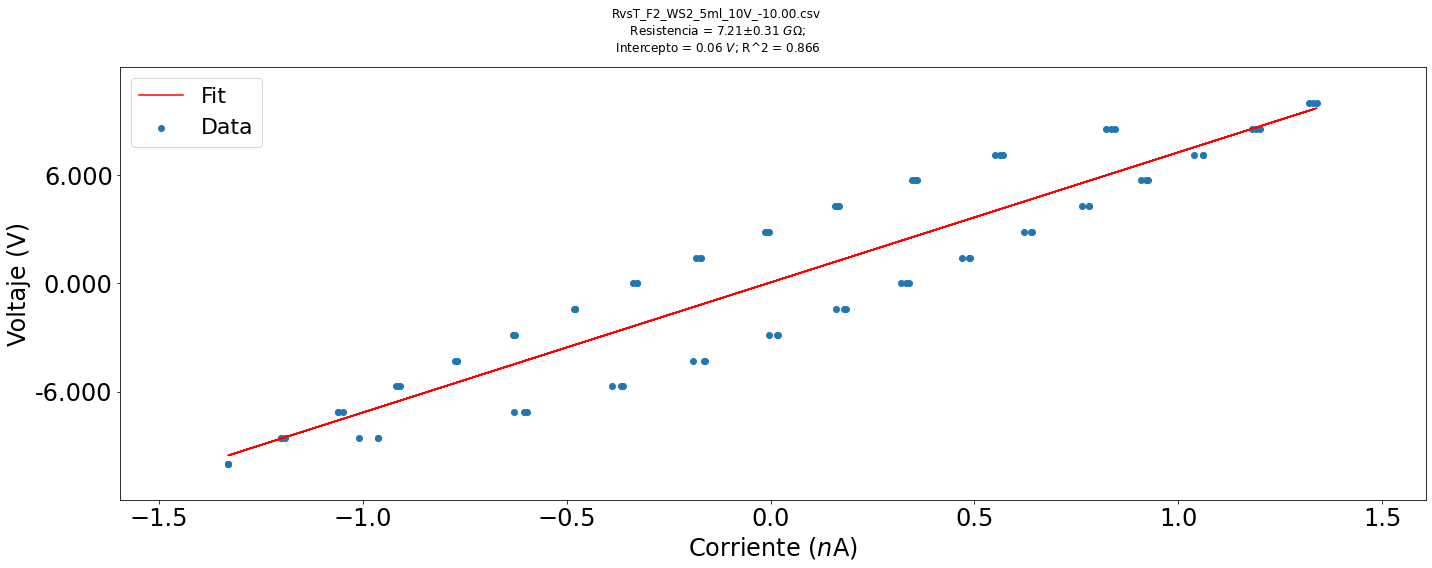

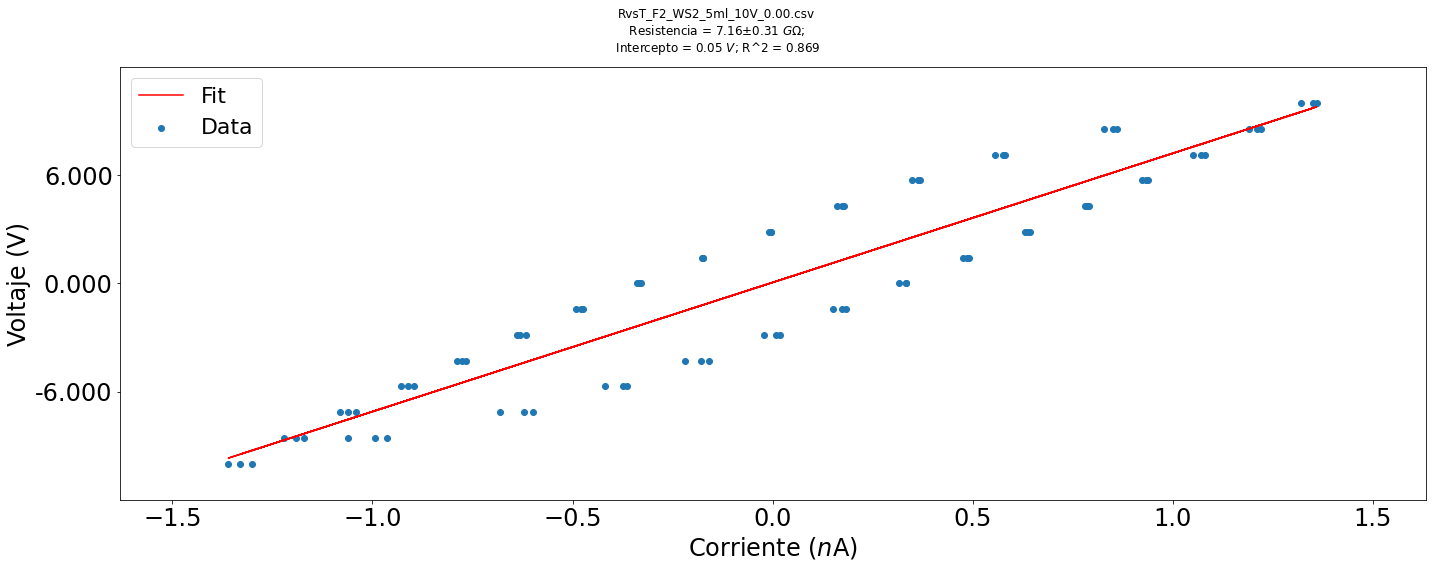

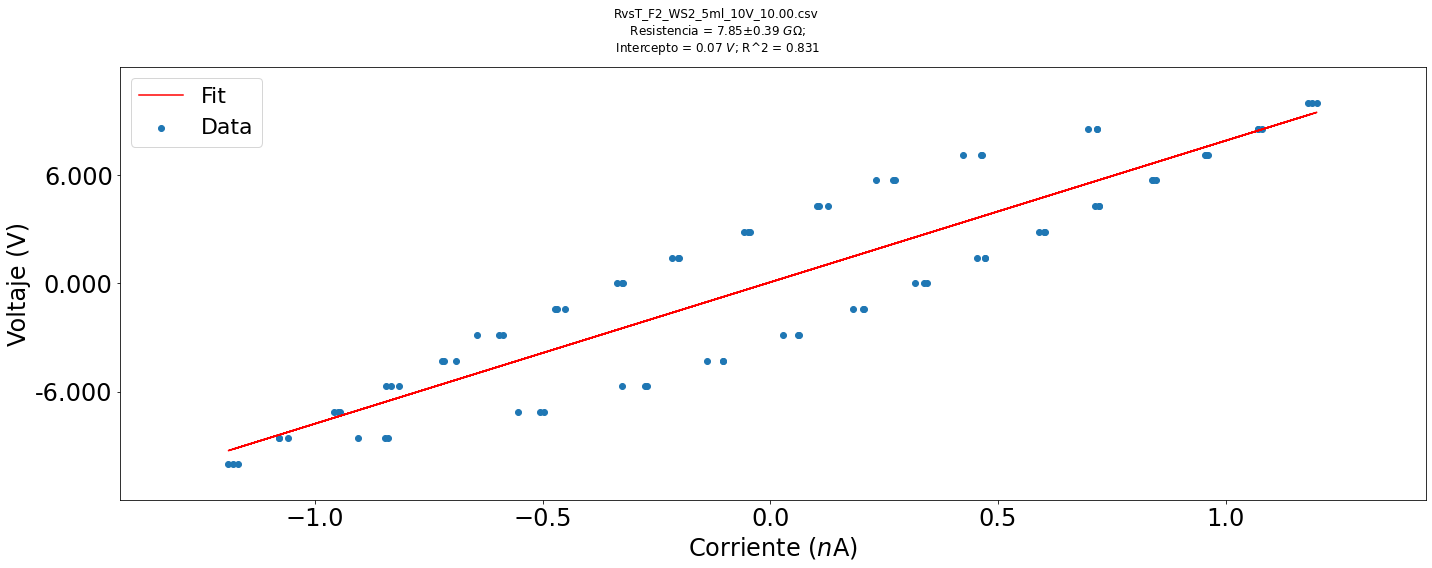

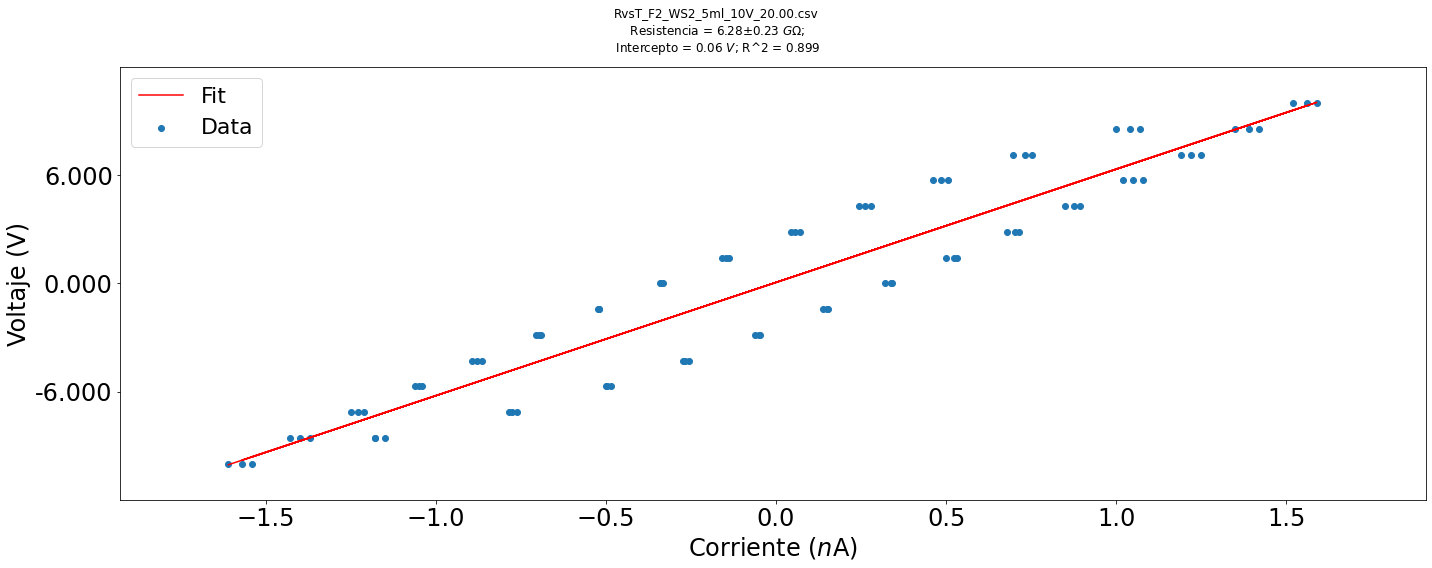

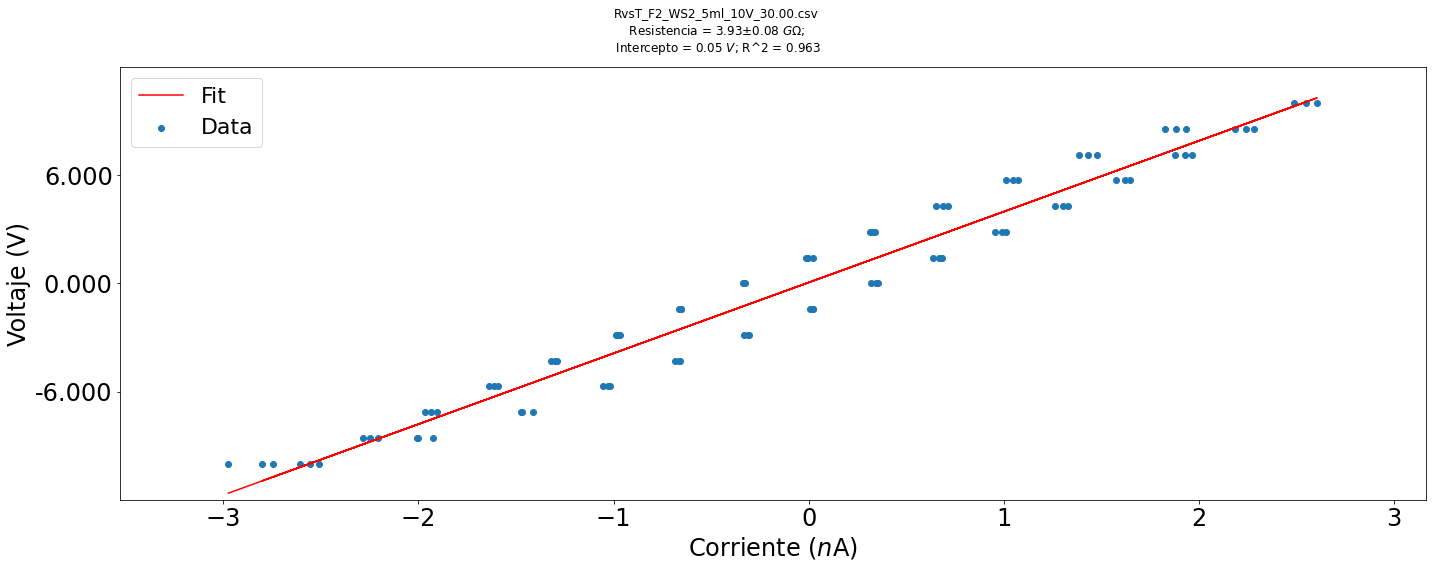

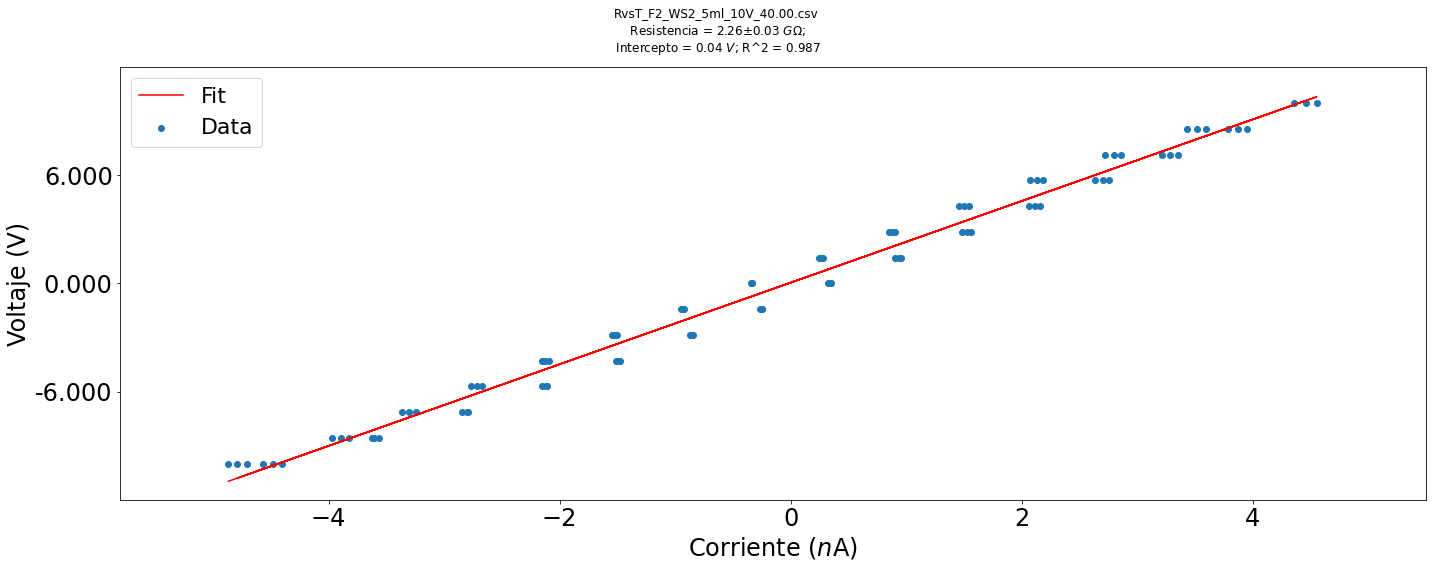

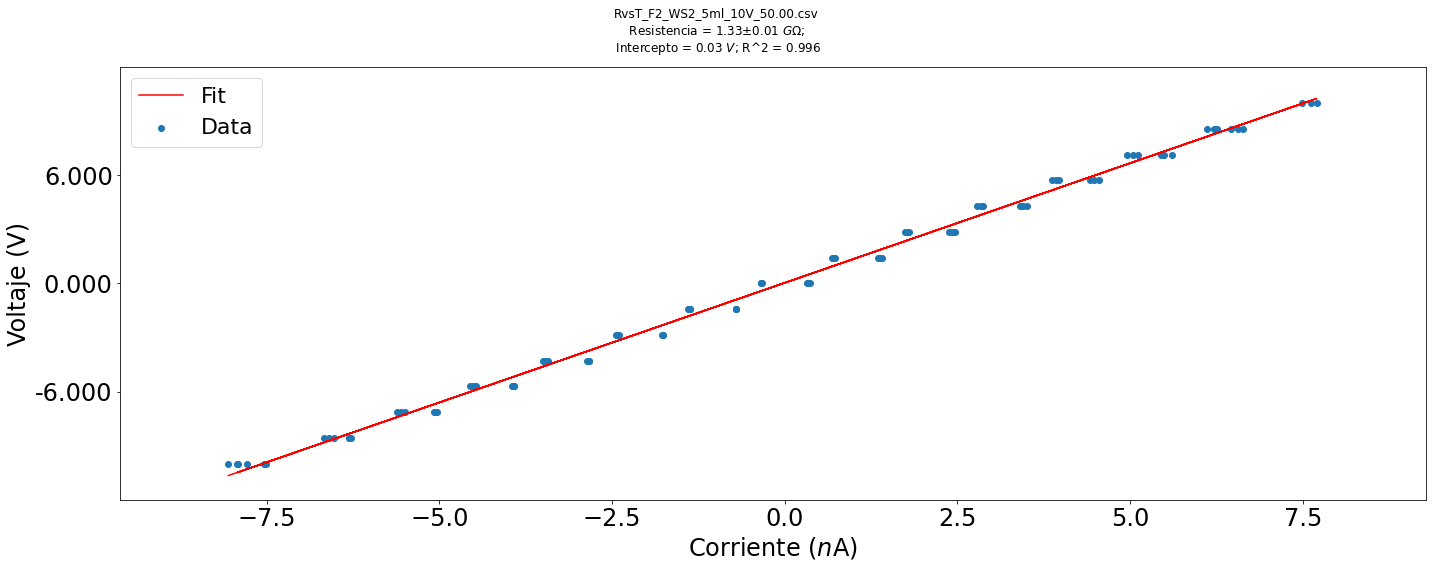

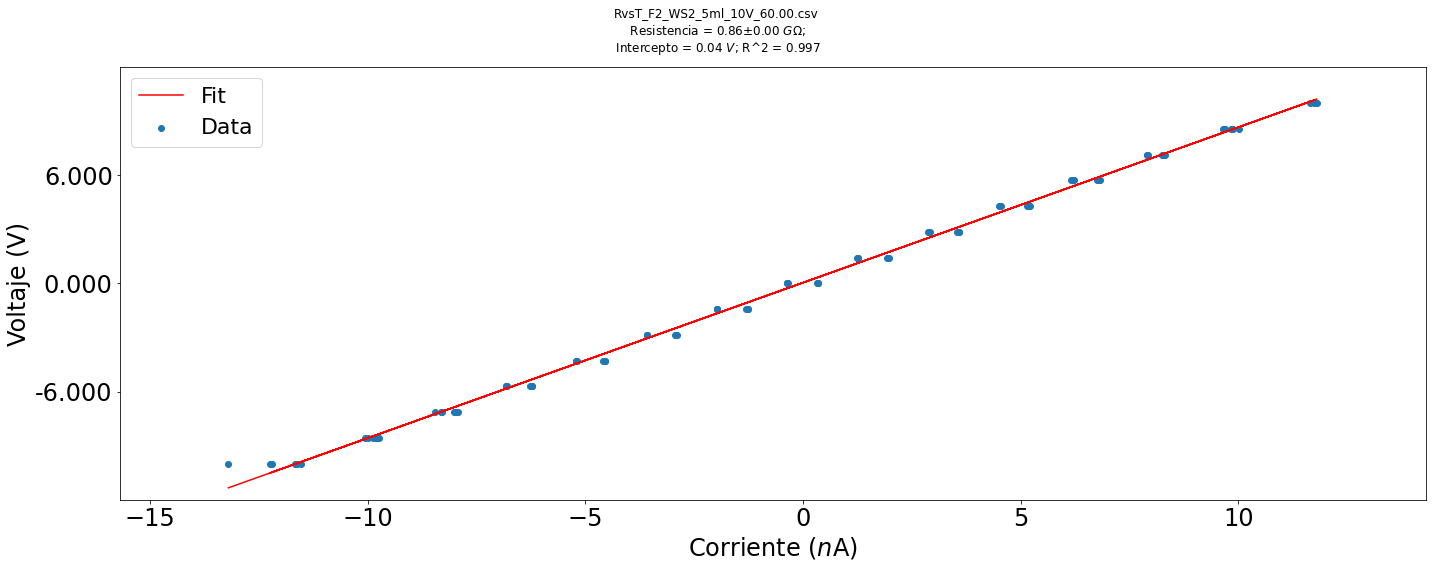

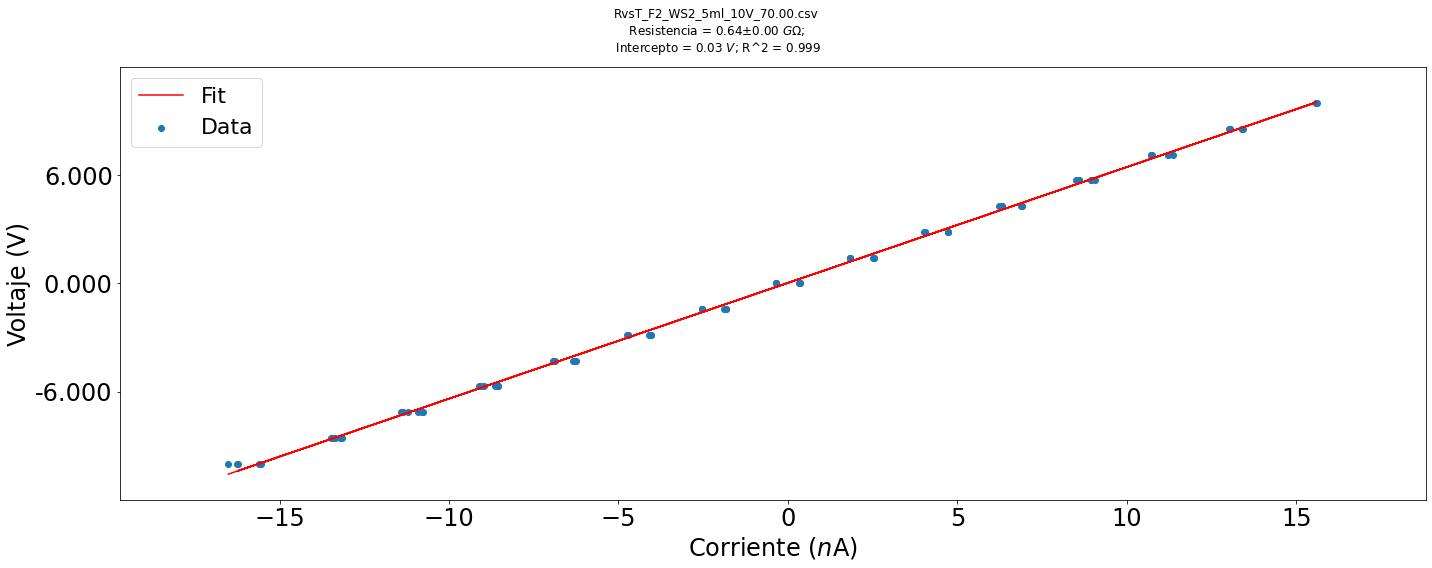

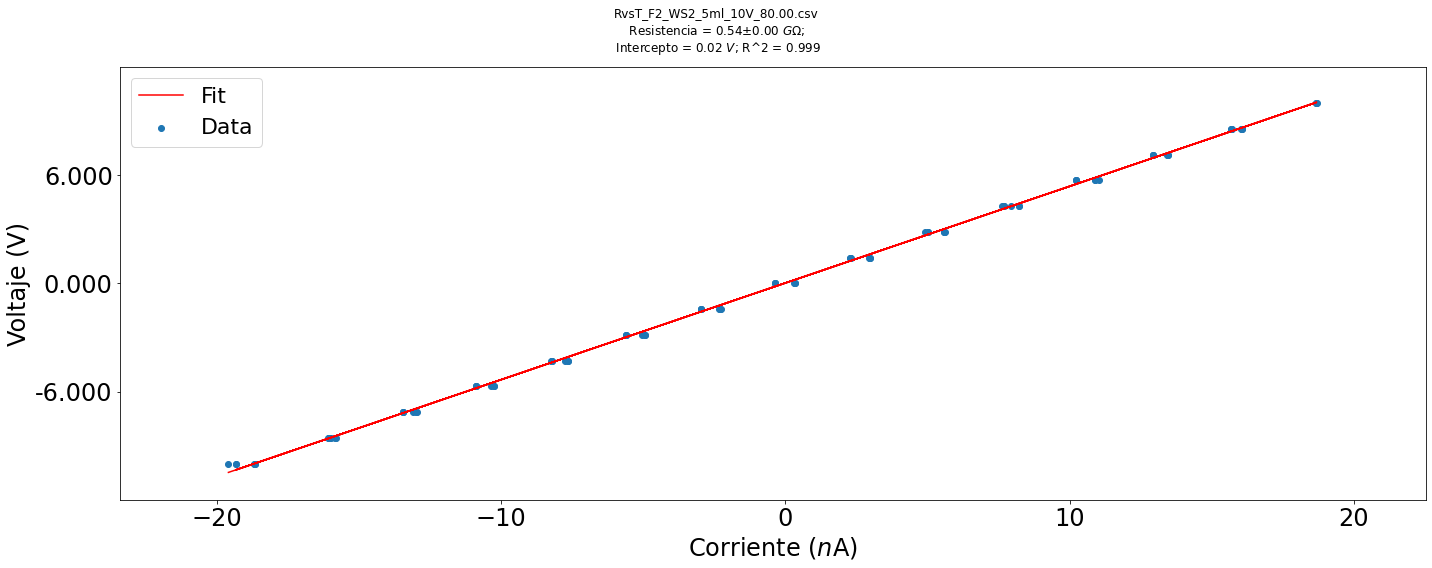

In [15]:
def generate_filenames():
    Tlist = np.linspace(-100,80,19)
    filenames = ['RvsT_F2_WS2_5ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-100,80,19)
d = 1.73
t = 216.3
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(19,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for WS2 with volume of 5 ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)

C:\Users\danie\AppData\Local\Temp/ipykernel_29092/3336030541.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(20,8))


[10.344613012315078, 10.246106705990693, 10.152684773324648, 10.050610164639693, 9.890363391247998, 9.779546585086745, 9.64998982942338, 9.453700580702405, 9.21070376527865, 8.740601317074988, 8.021984350143743, 7.708876356860291, 7.4796845952318405, 7.160311824075279, 6.981978756976095, 6.748889855804604, 6.363754124698225, 5.860569266729775, 5.260790870117872, 4.577398099638956, 3.953260157783891, 3.410458450588263, 2.8830705792438582, 2.397972619489915, 1.9536112793296512]


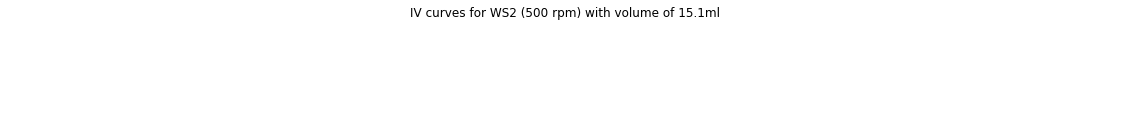

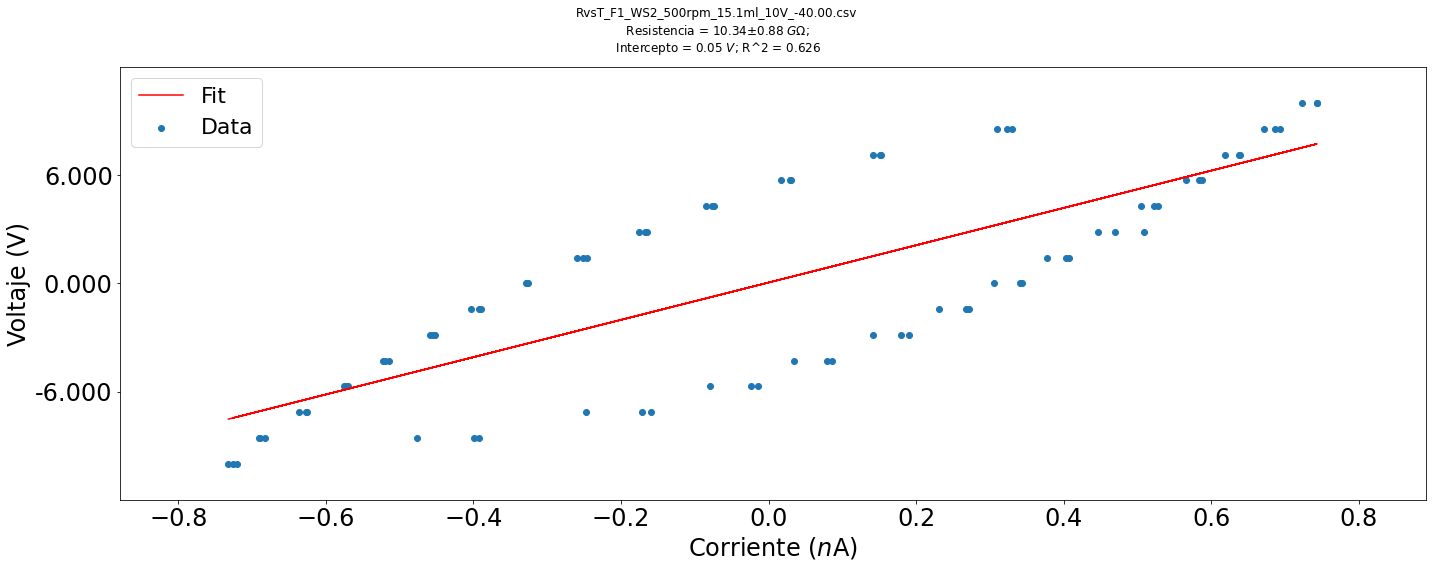

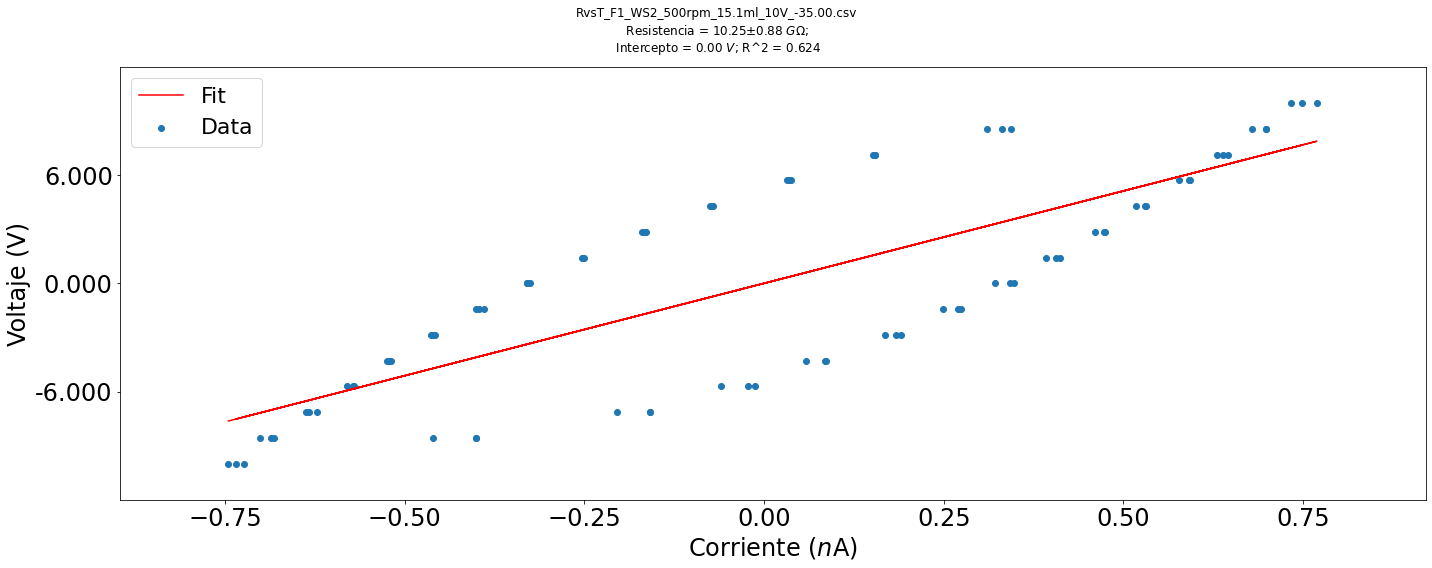

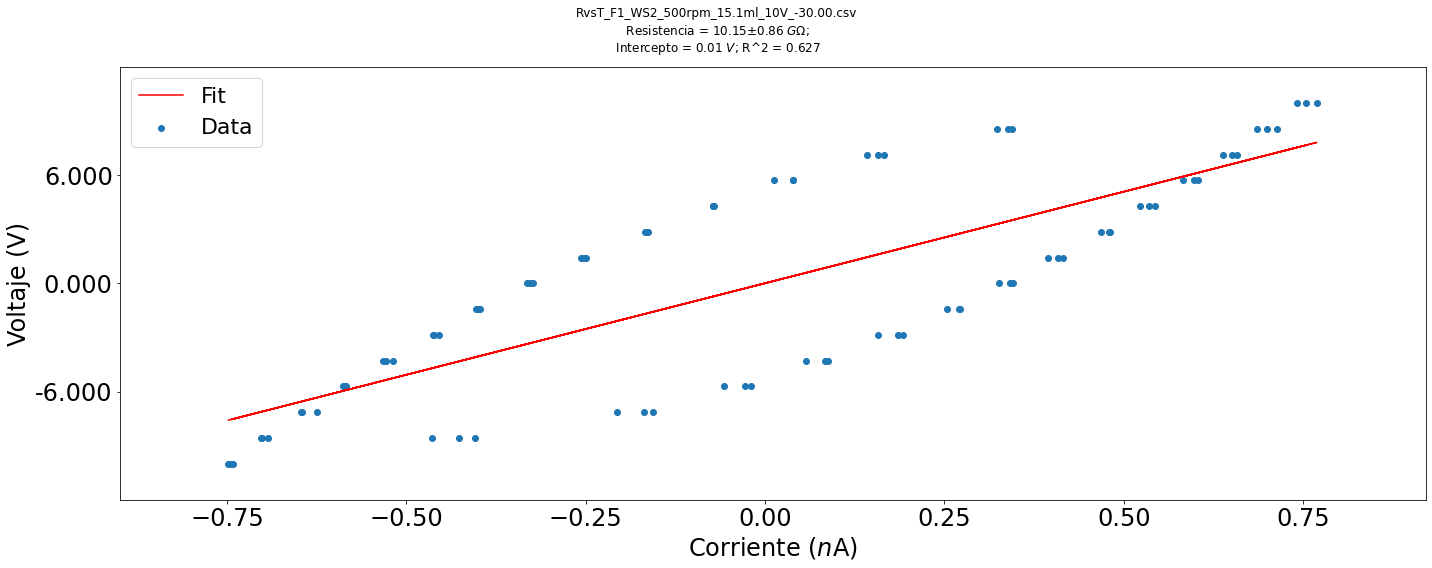

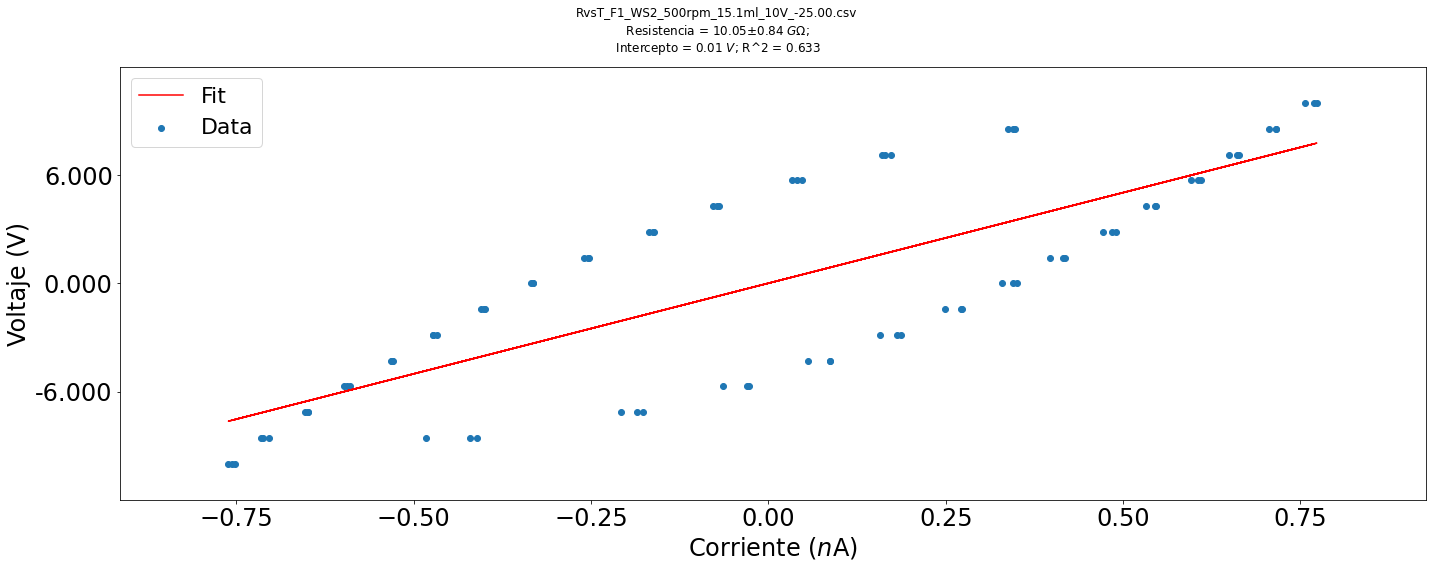

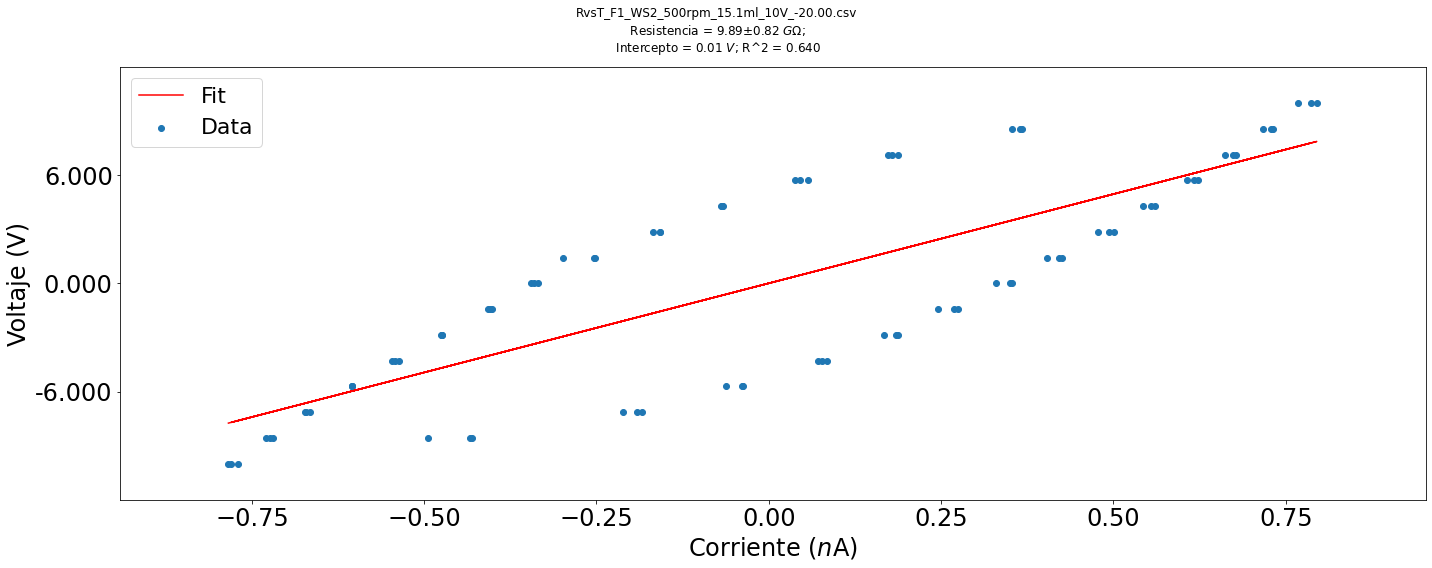

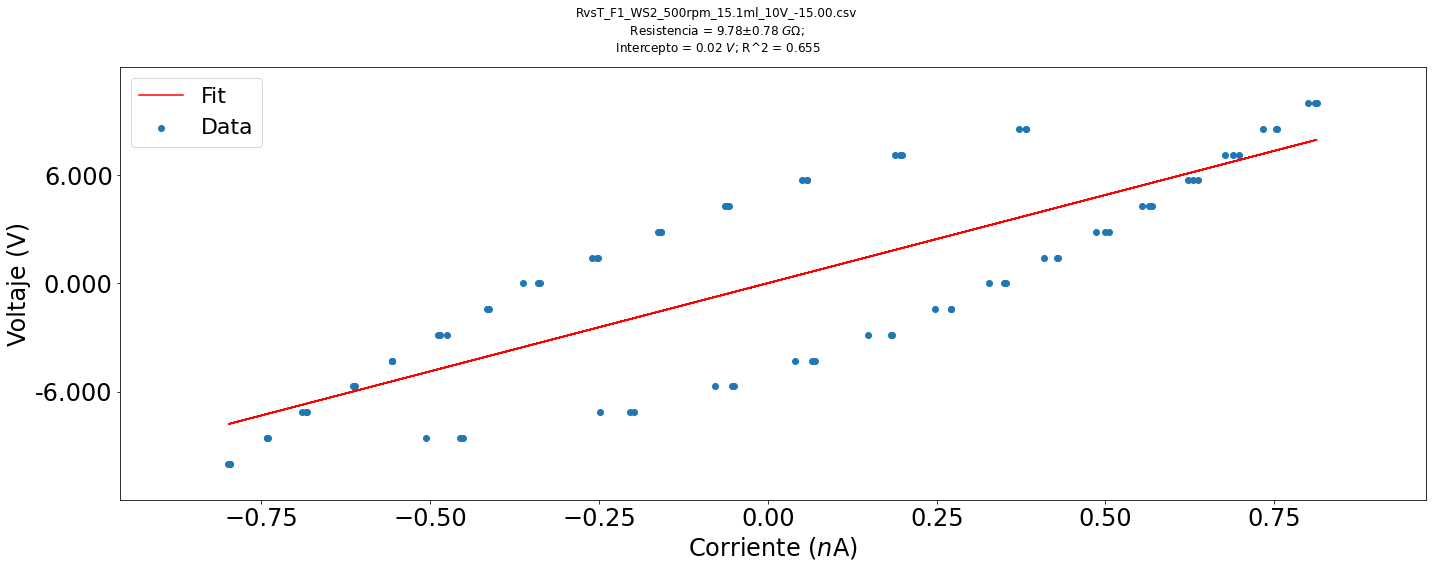

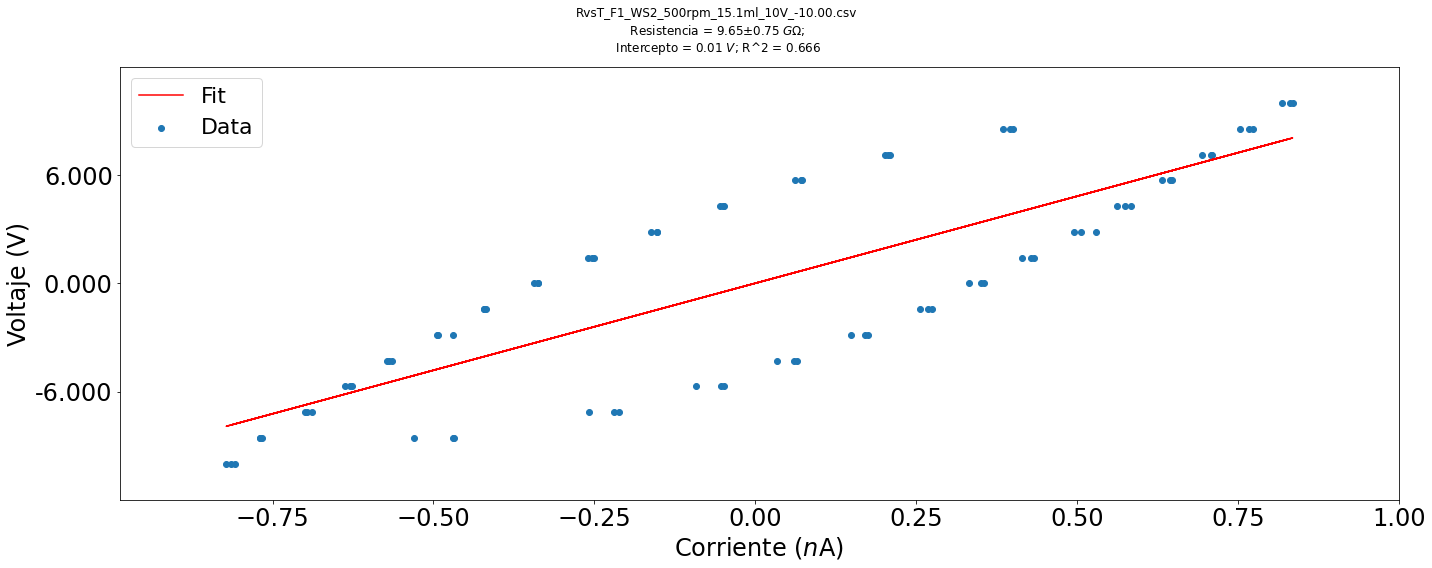

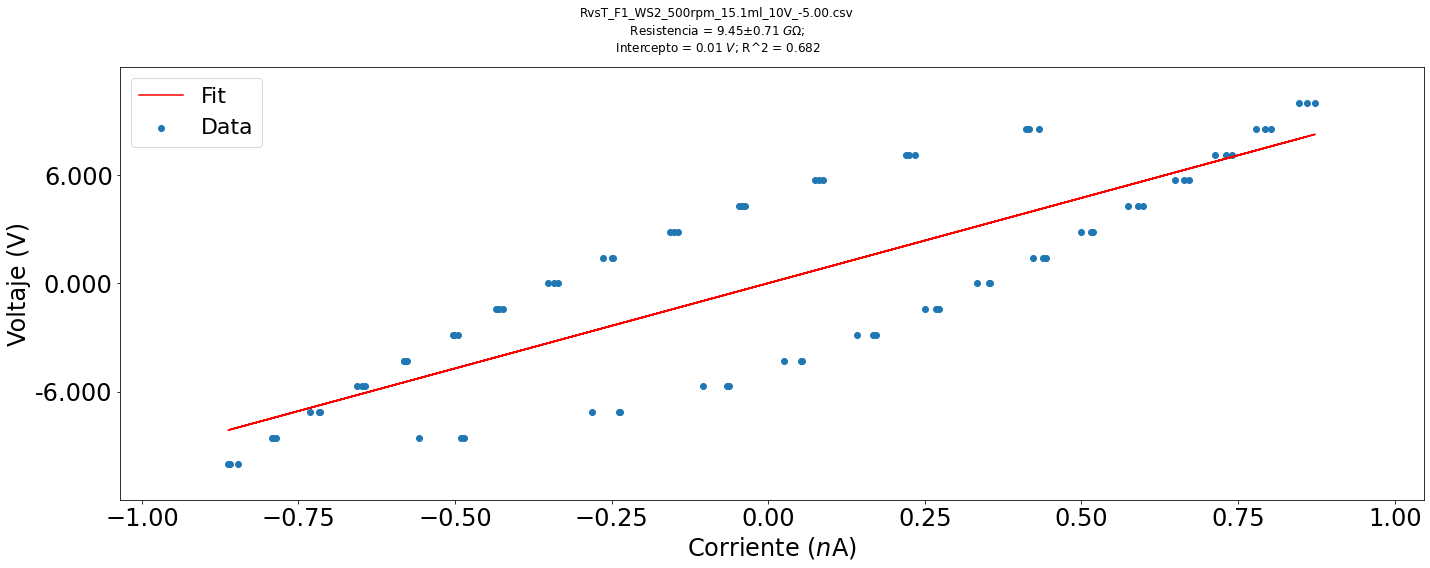

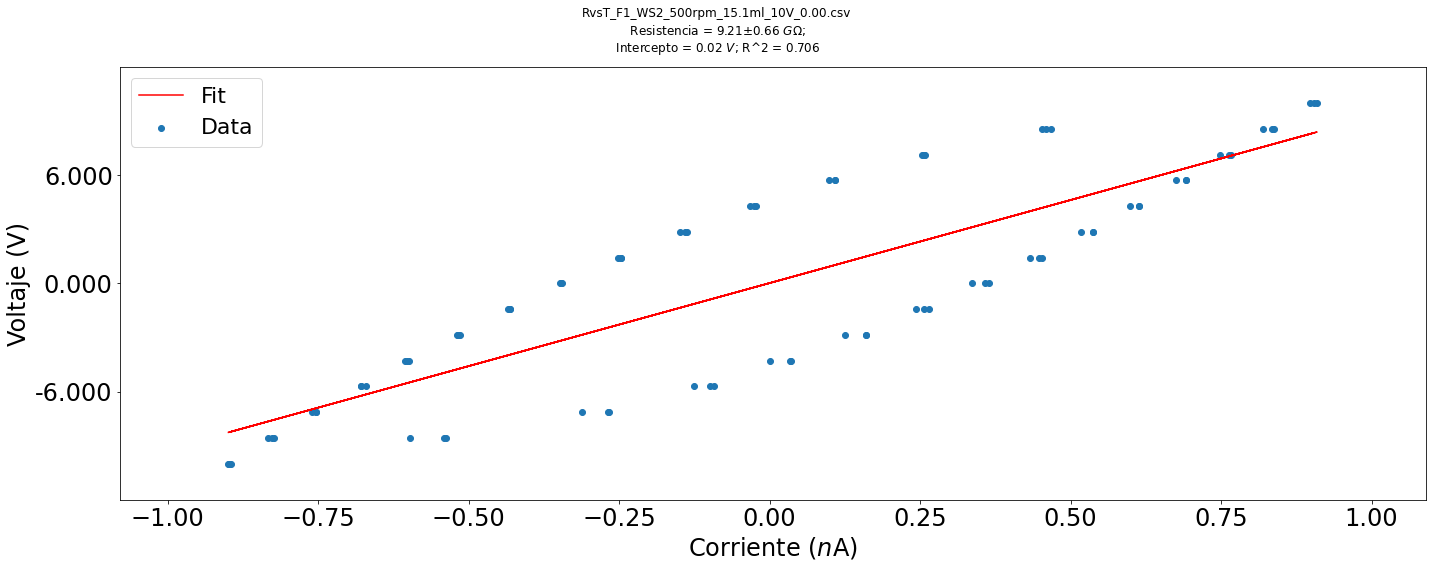

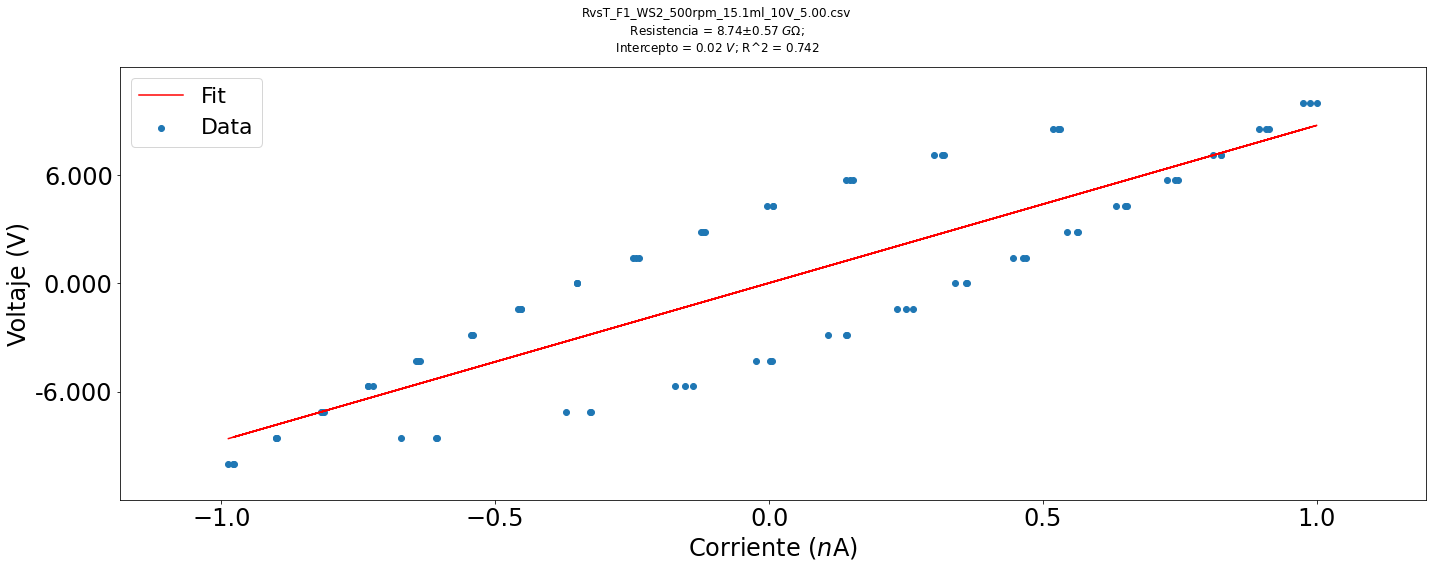

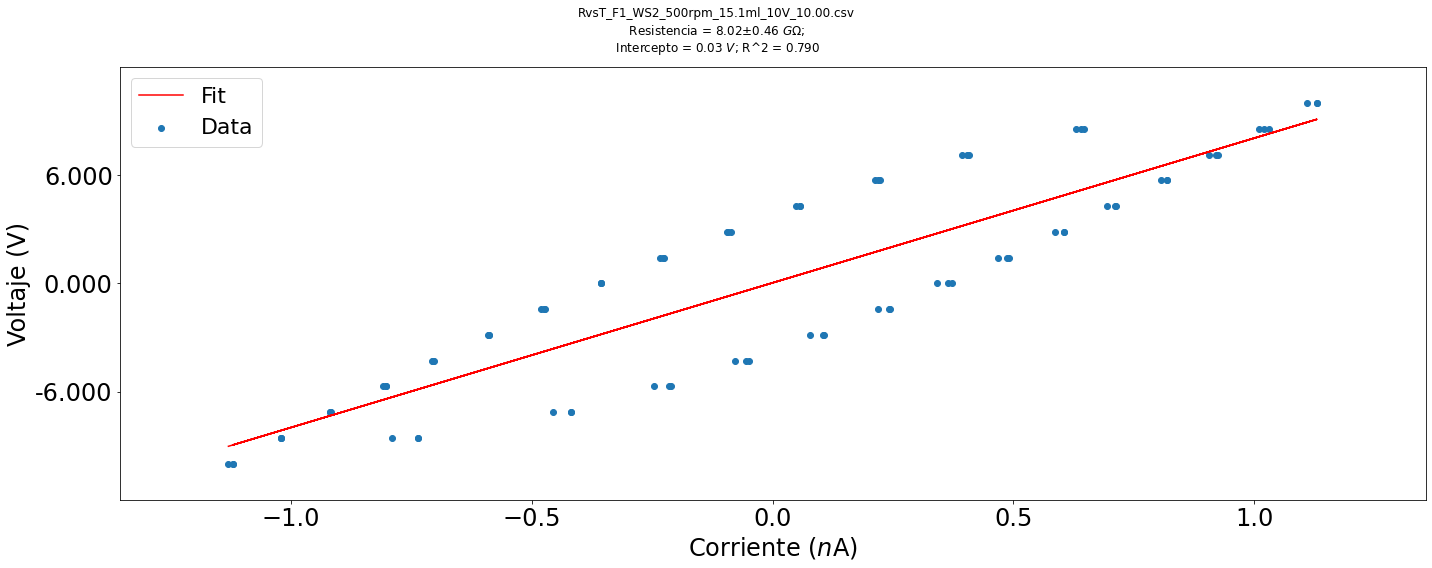

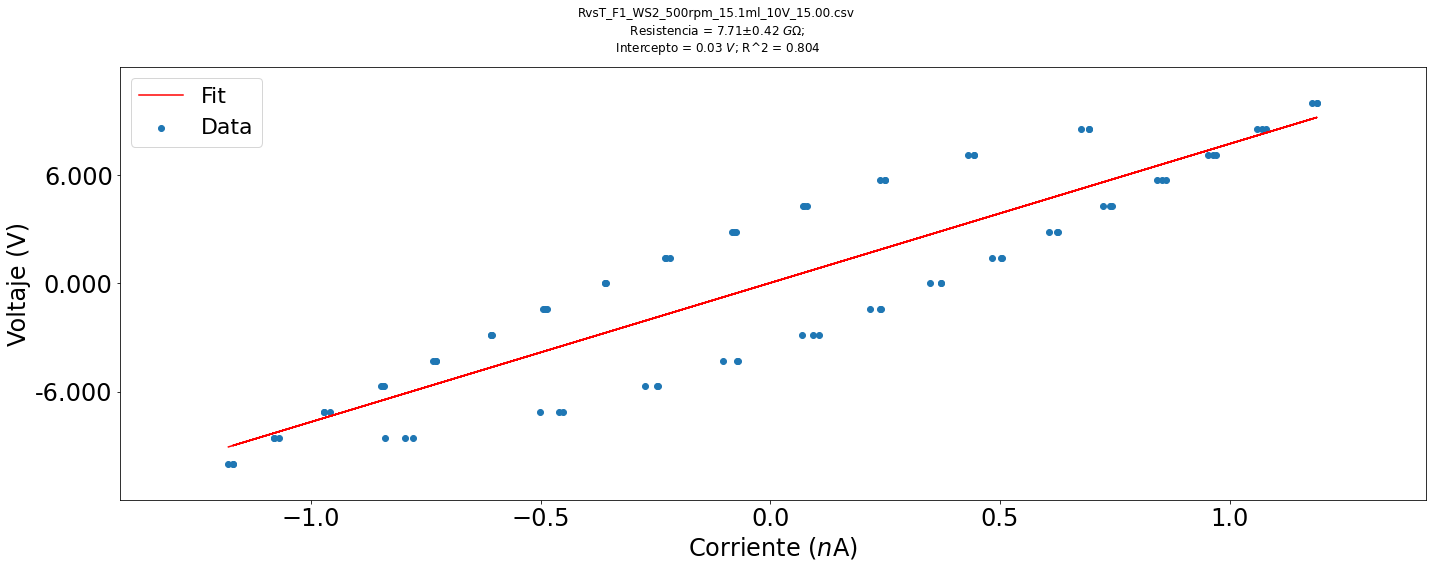

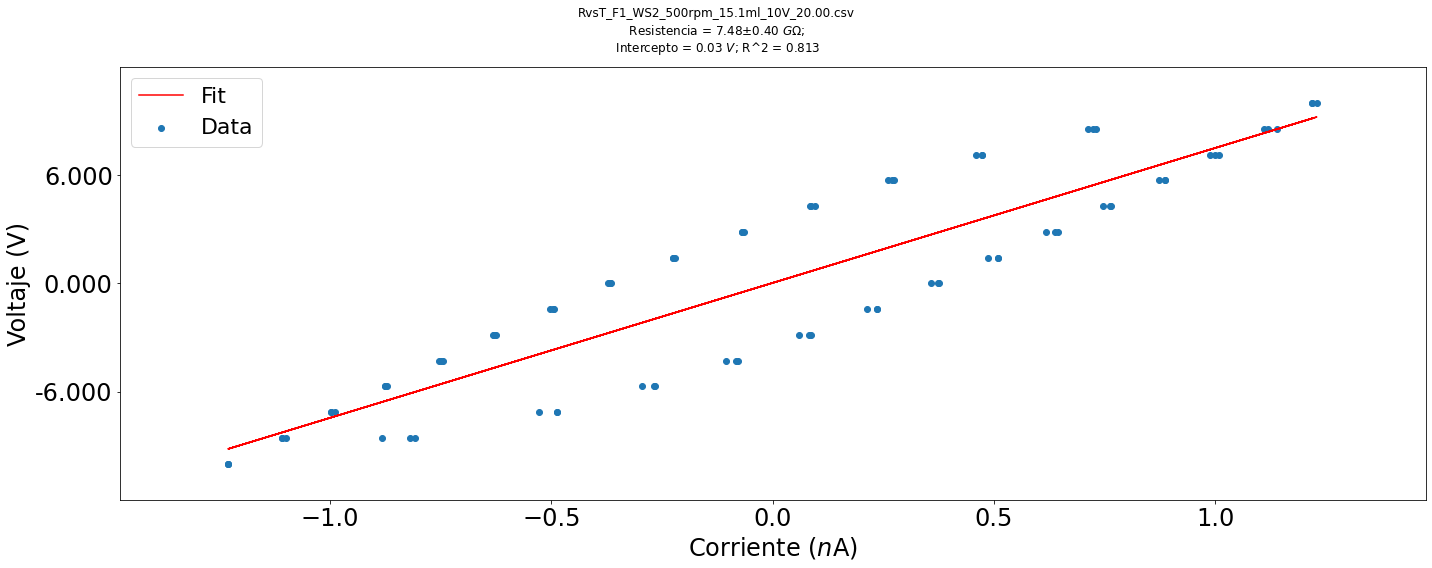

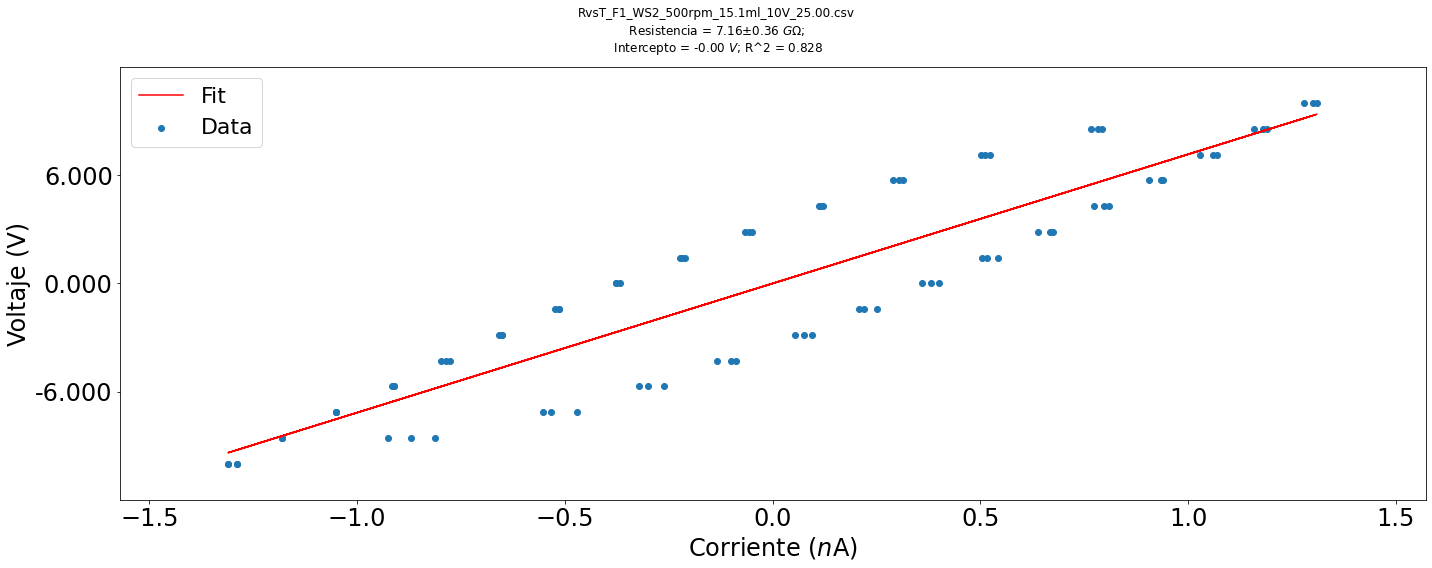

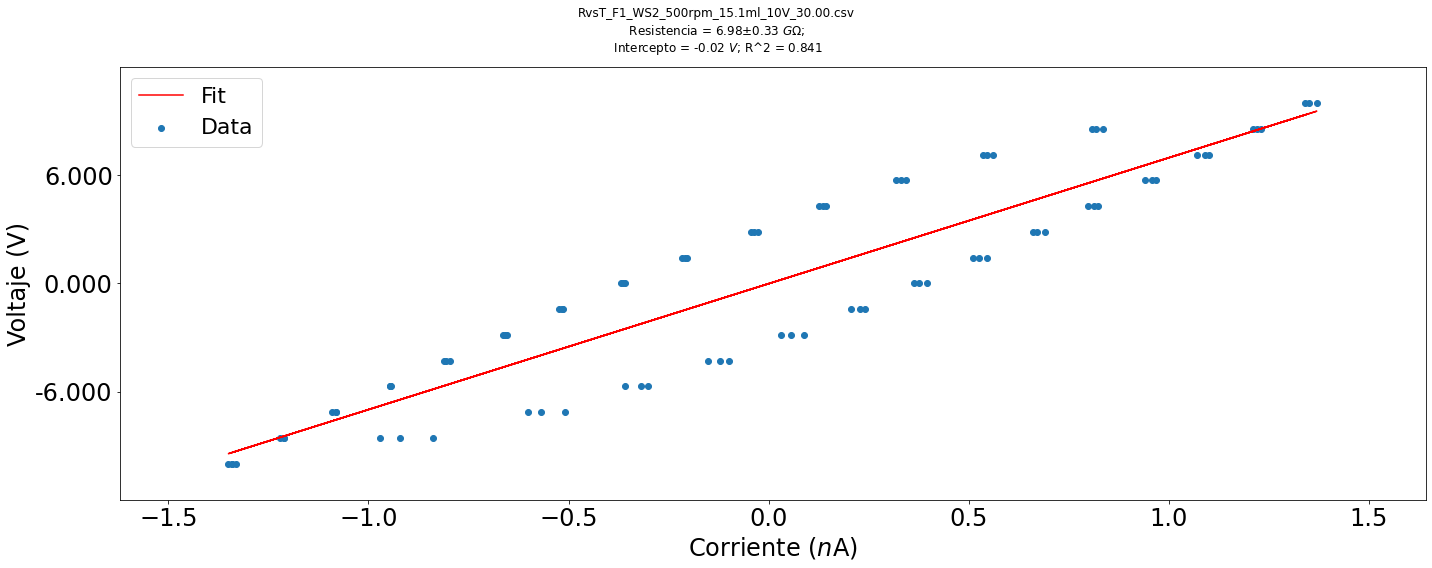

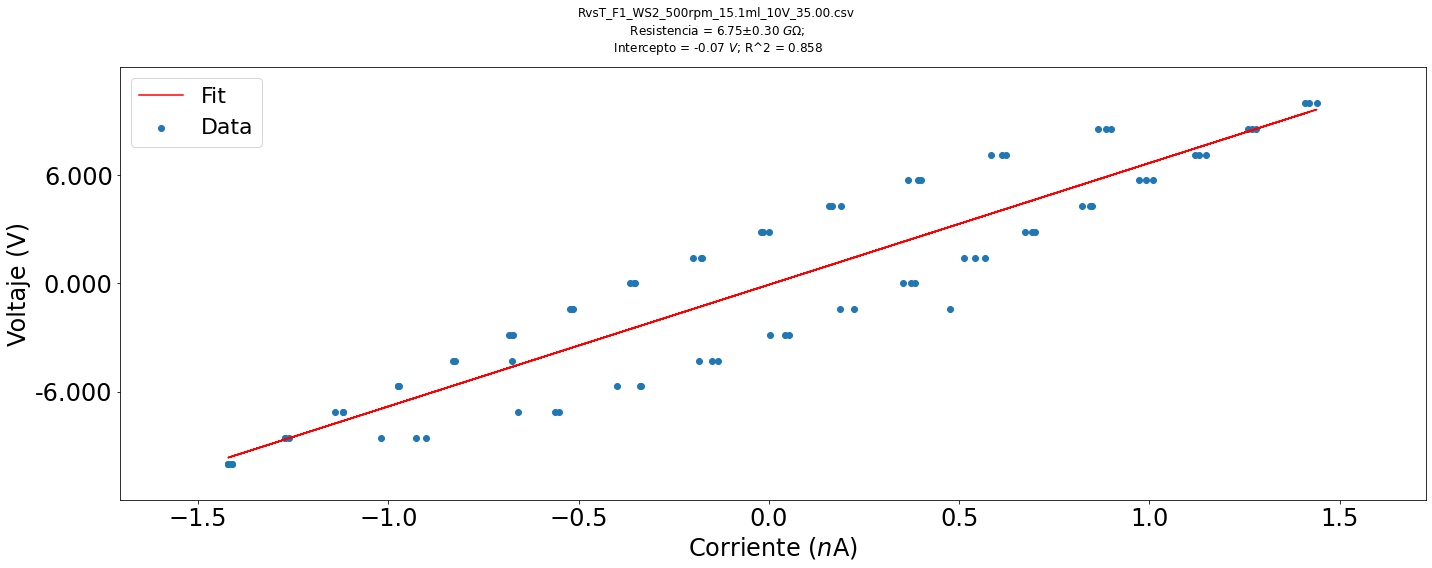

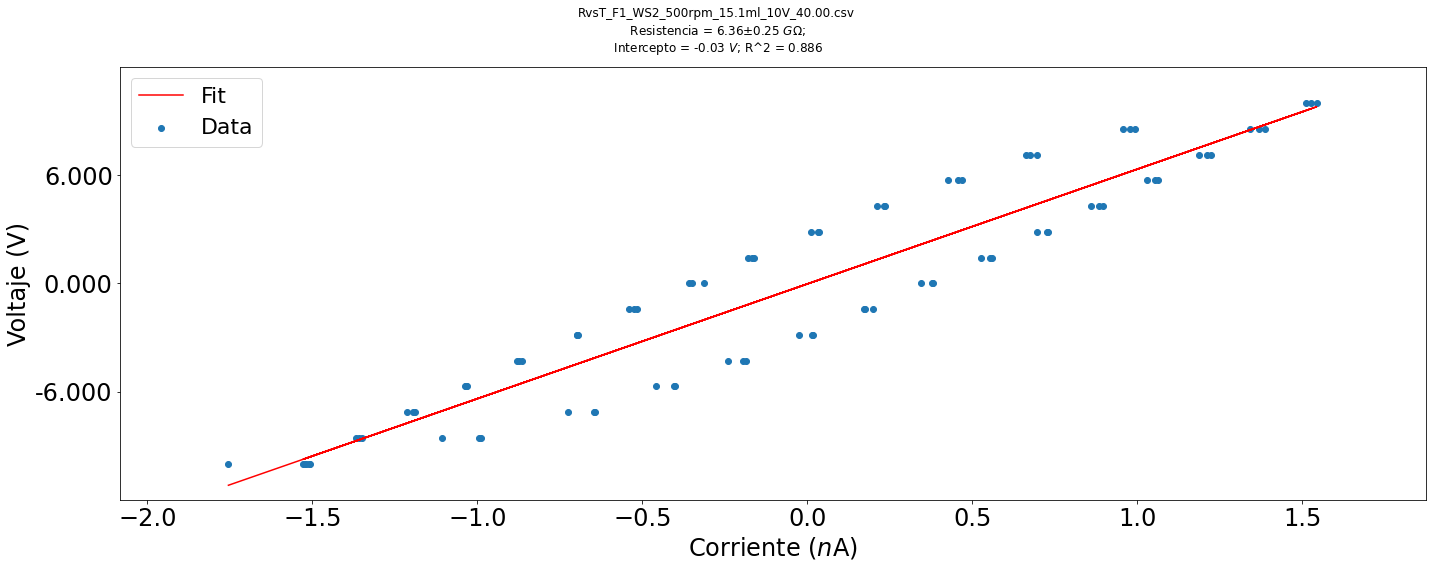

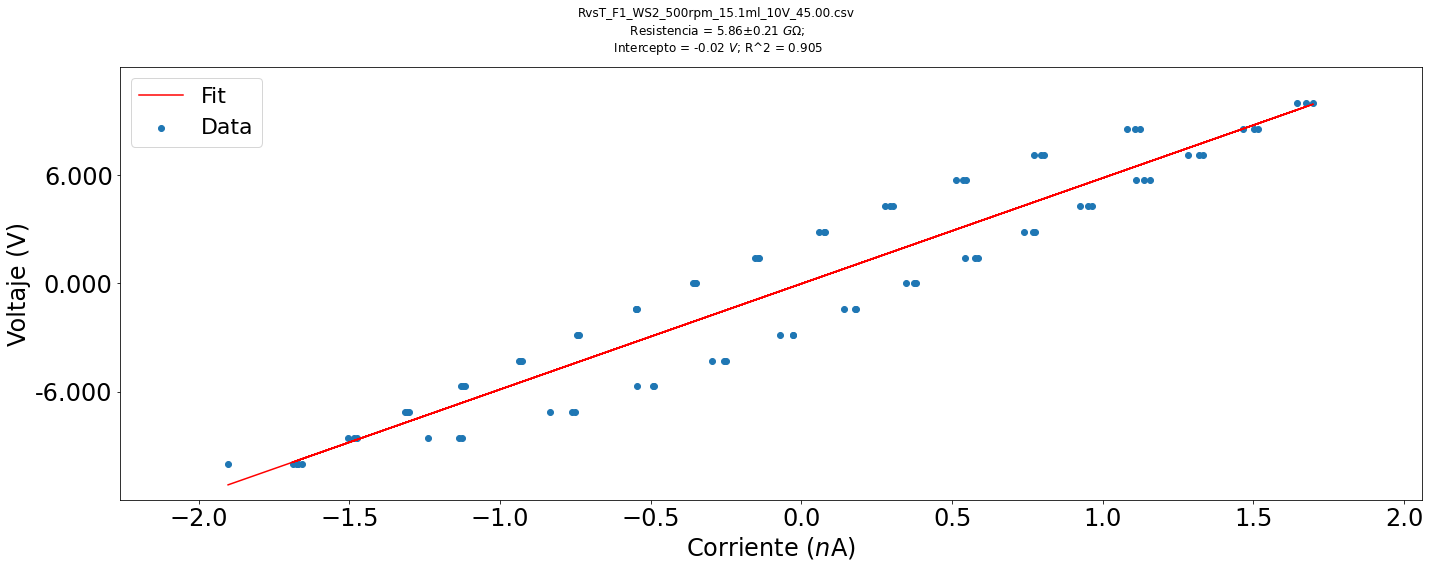

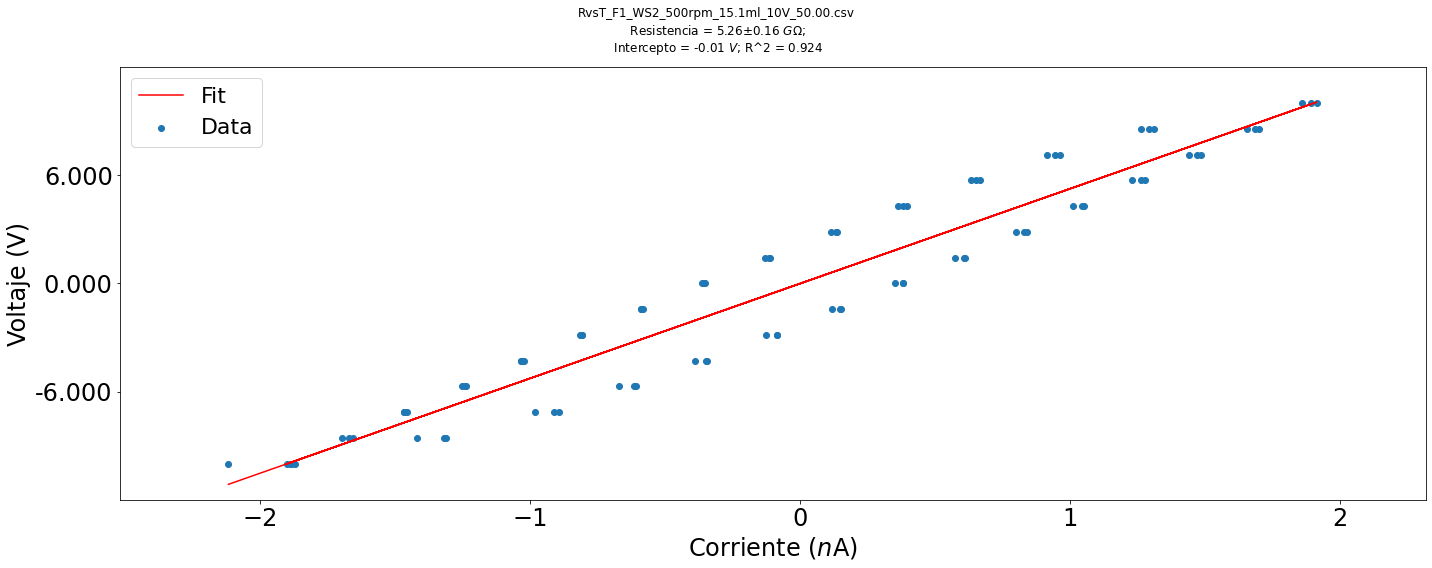

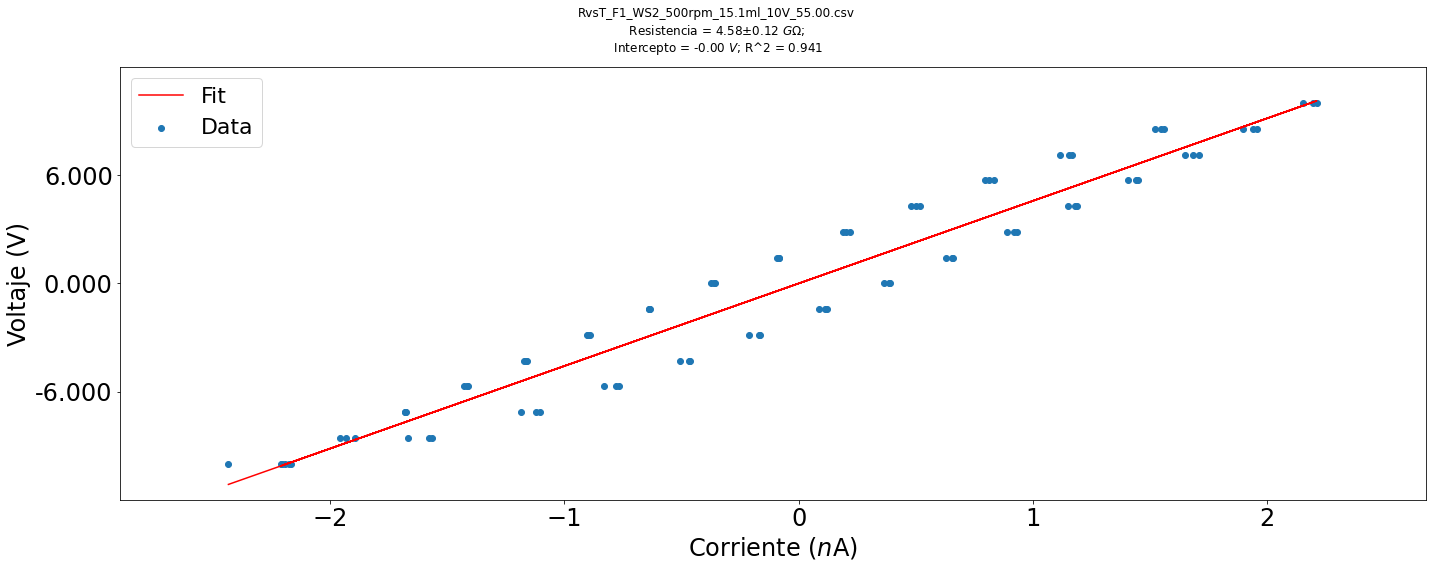

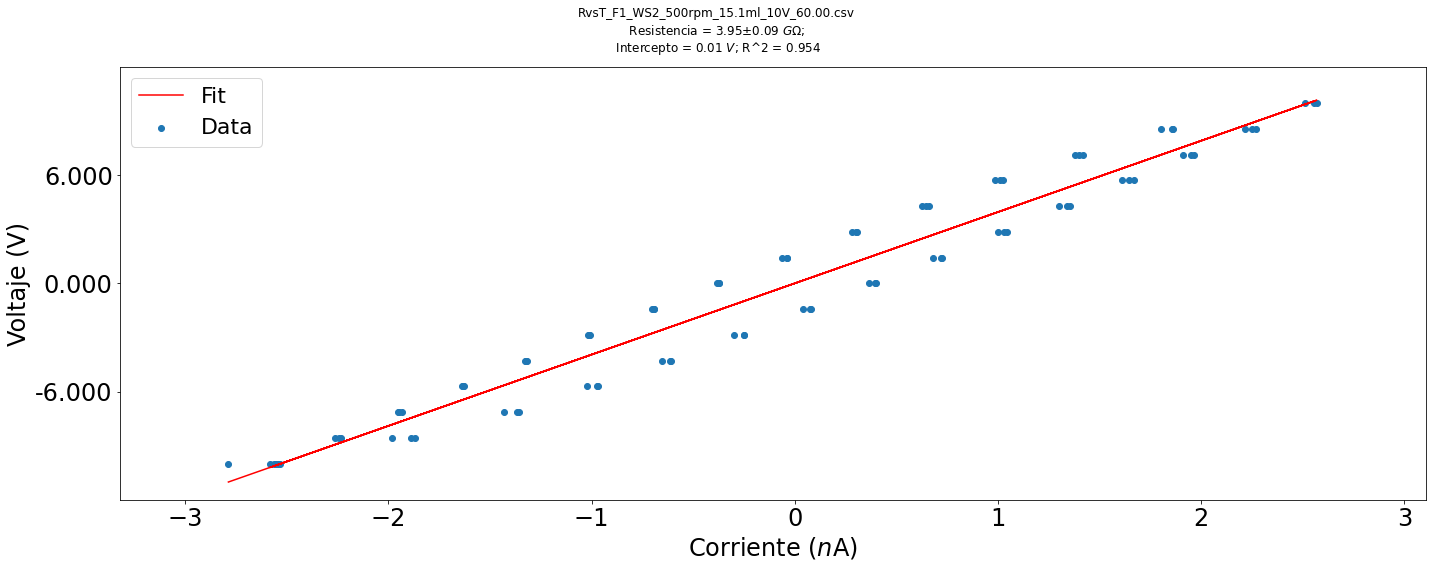

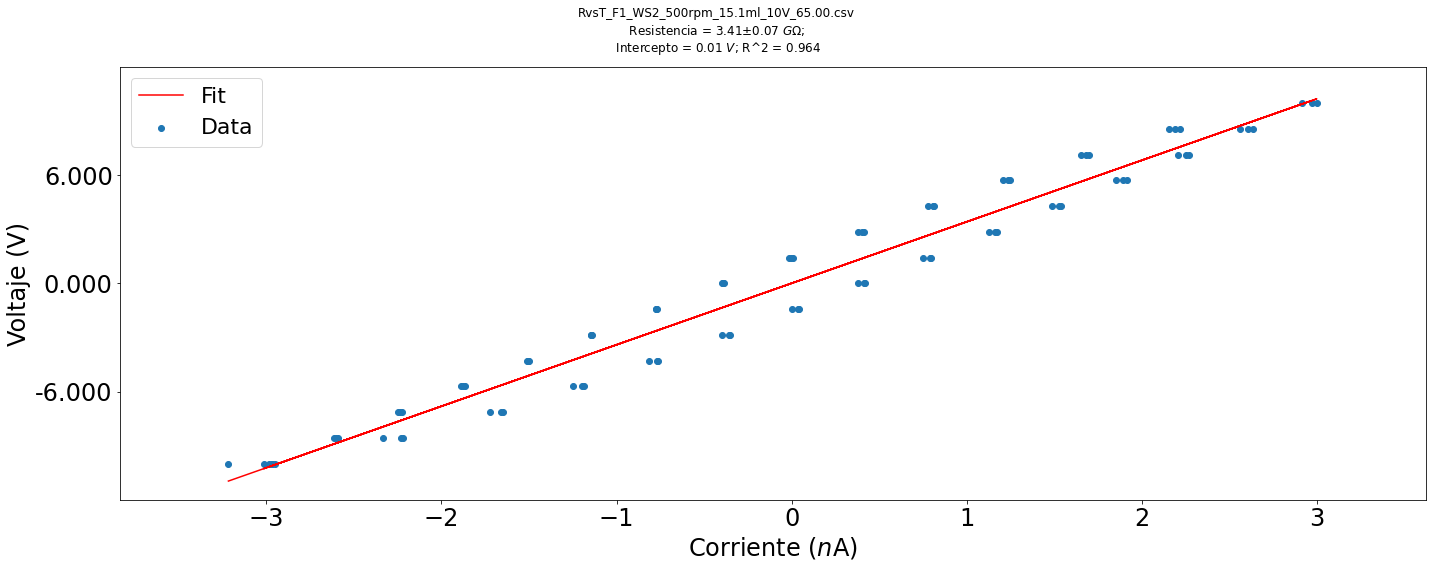

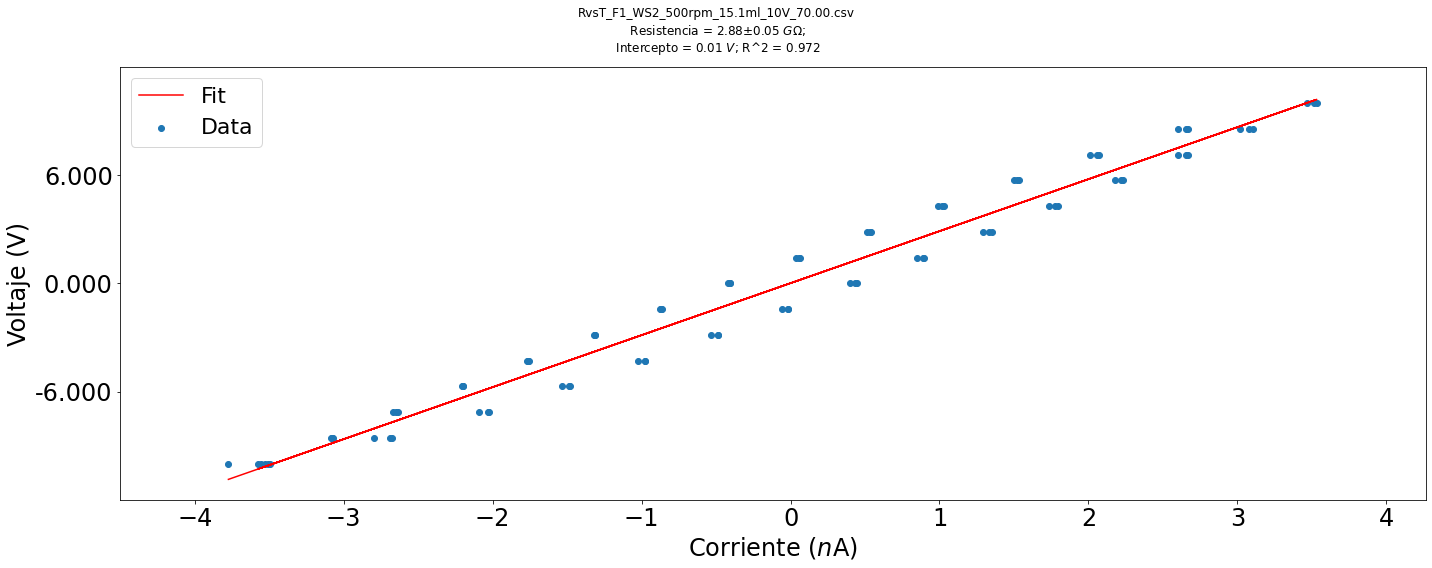

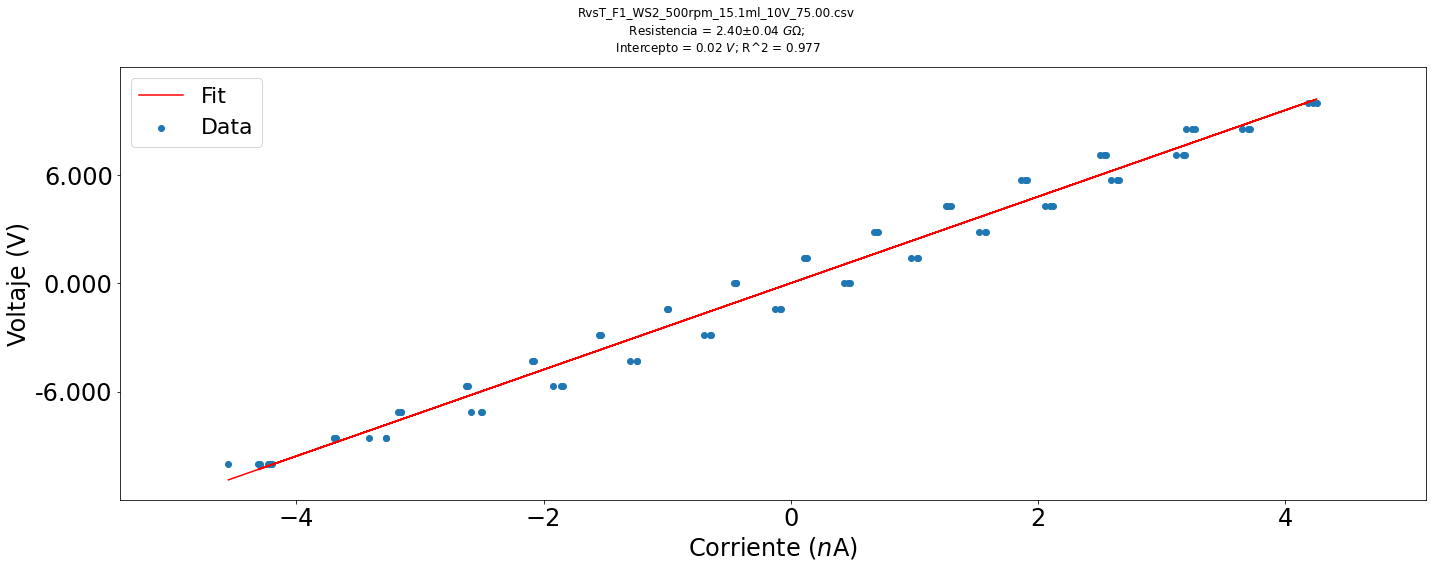

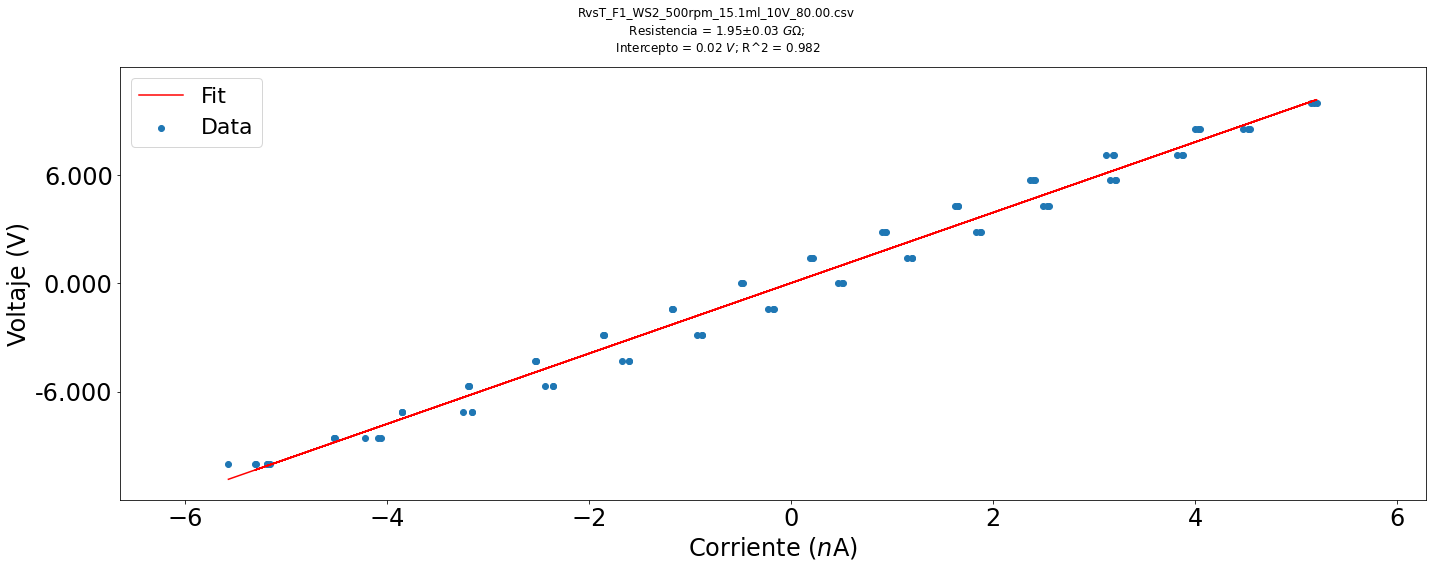

In [71]:
def generate_filenames():
    Tlist = np.linspace(-40,80,25)
    filenames = ['RvsT_F1_WS2_500rpm_15.1ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-40,80,25)
d = 1.77
t = 1043
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(25,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0]),fig.add_subplot(gs[19,0]),fig.add_subplot(gs[20,0]),fig.add_subplot(gs[21,0]),fig.add_subplot(gs[22,0]),fig.add_subplot(gs[23,0]),fig.add_subplot(gs[24,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for WS2 (500 rpm) with volume of 15.1ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)

C:\Users\danie\AppData\Local\Temp/ipykernel_29092/3092164616.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(20,8))


[119.68838345974724, 109.91947557455742, 101.24832855241117, 88.52183354868069, 84.26018176061348, 85.96316220866856, 85.57523433151842, 87.34520743116074, 87.69404742170711, 83.24984293229764, 79.93547551330451, 79.38064964609535, 75.97674995822803, 68.14824431799225, 59.167444132886246, 51.204449802402, 39.01898249733533, 29.277108242375373, 24.066544319608894, 20.794304949644307, 18.43188303535236, 16.427413788396134, 14.427564195899588, 12.472060171204866, 10.668513904309762]


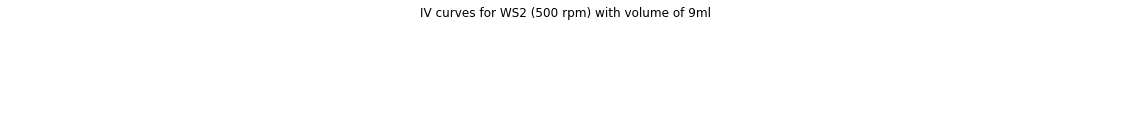

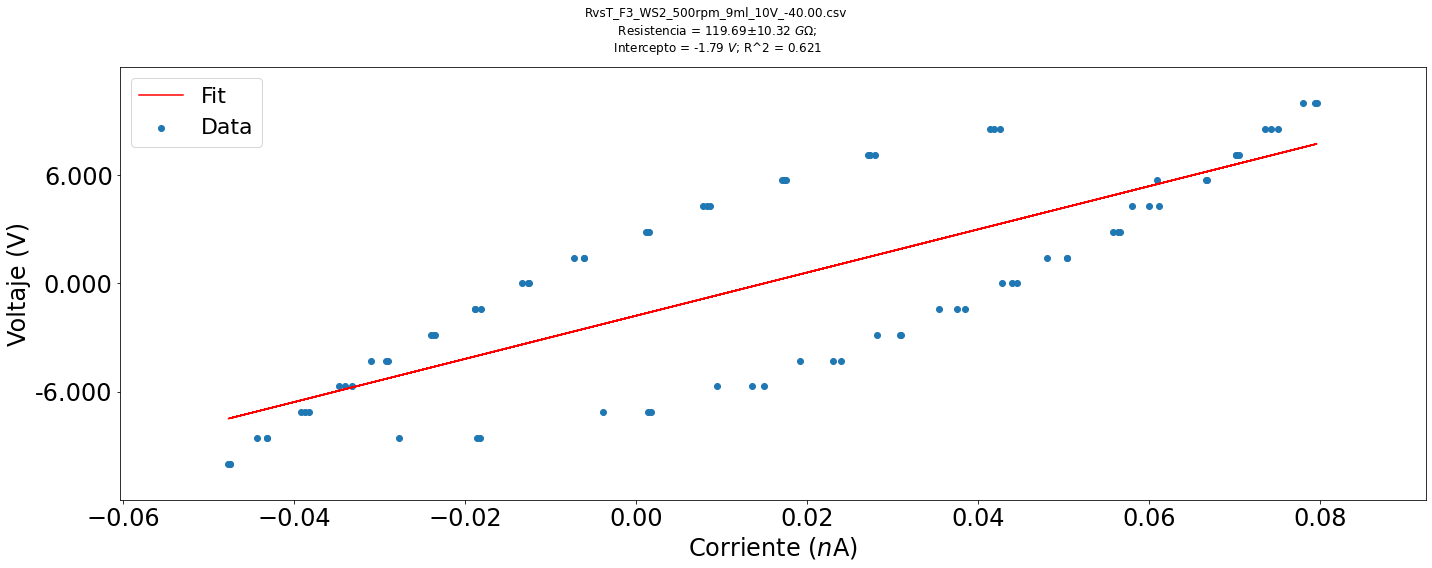

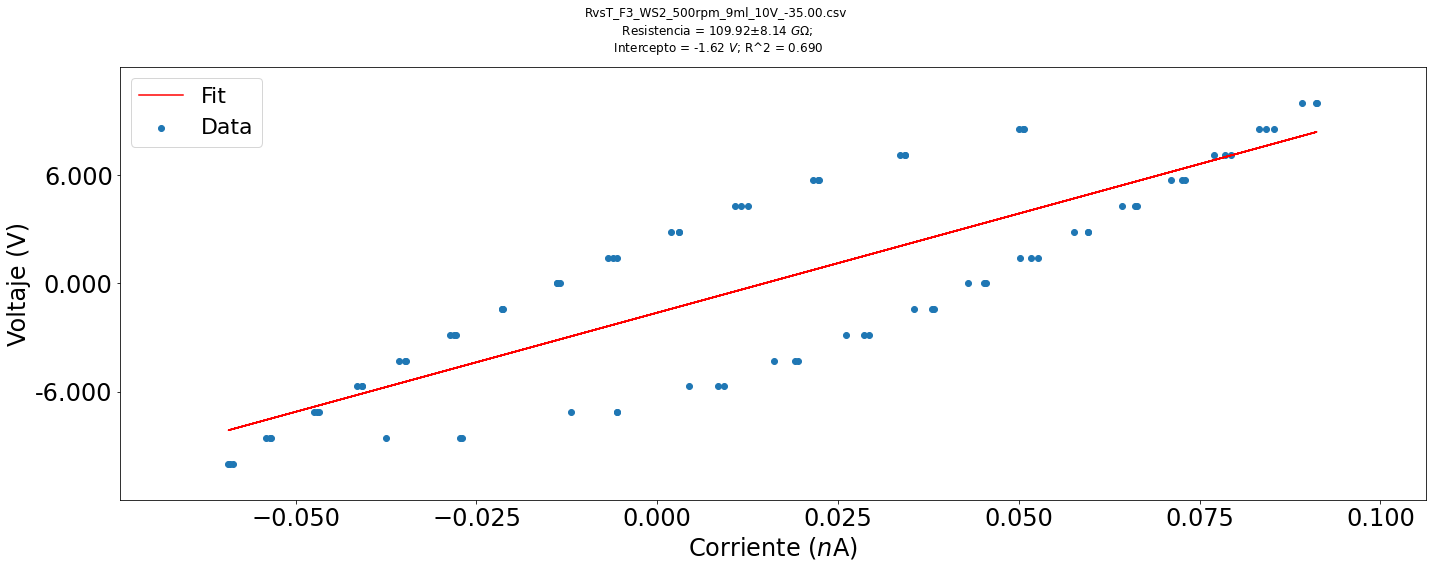

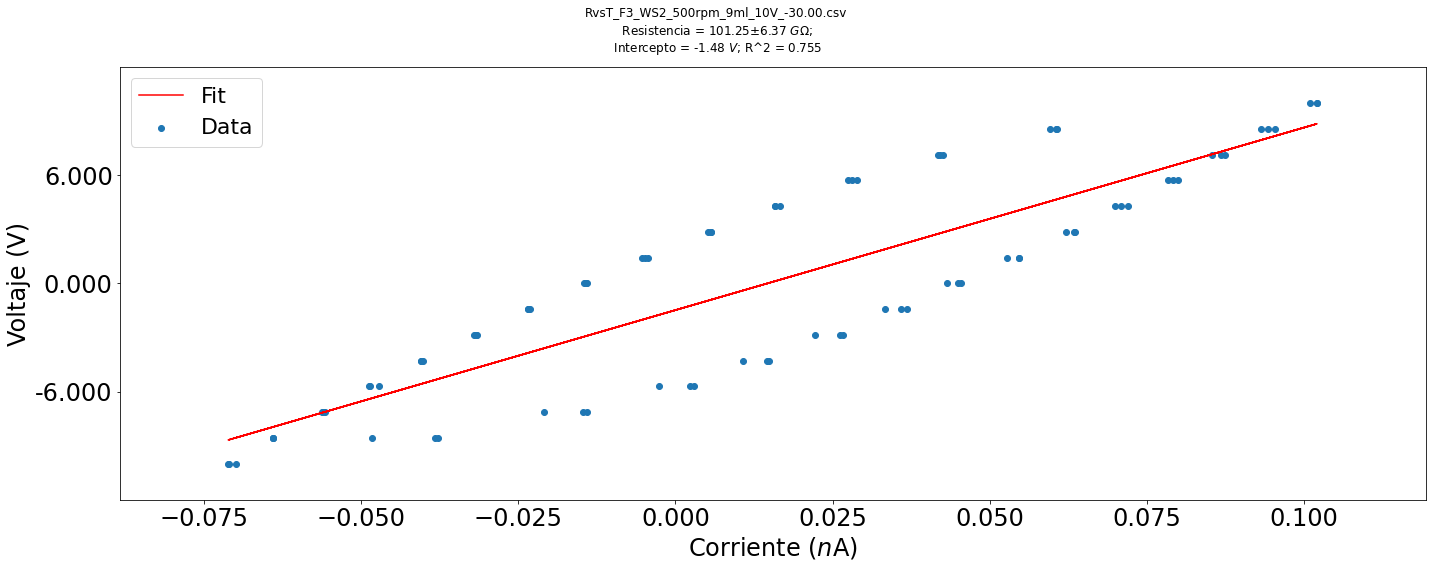

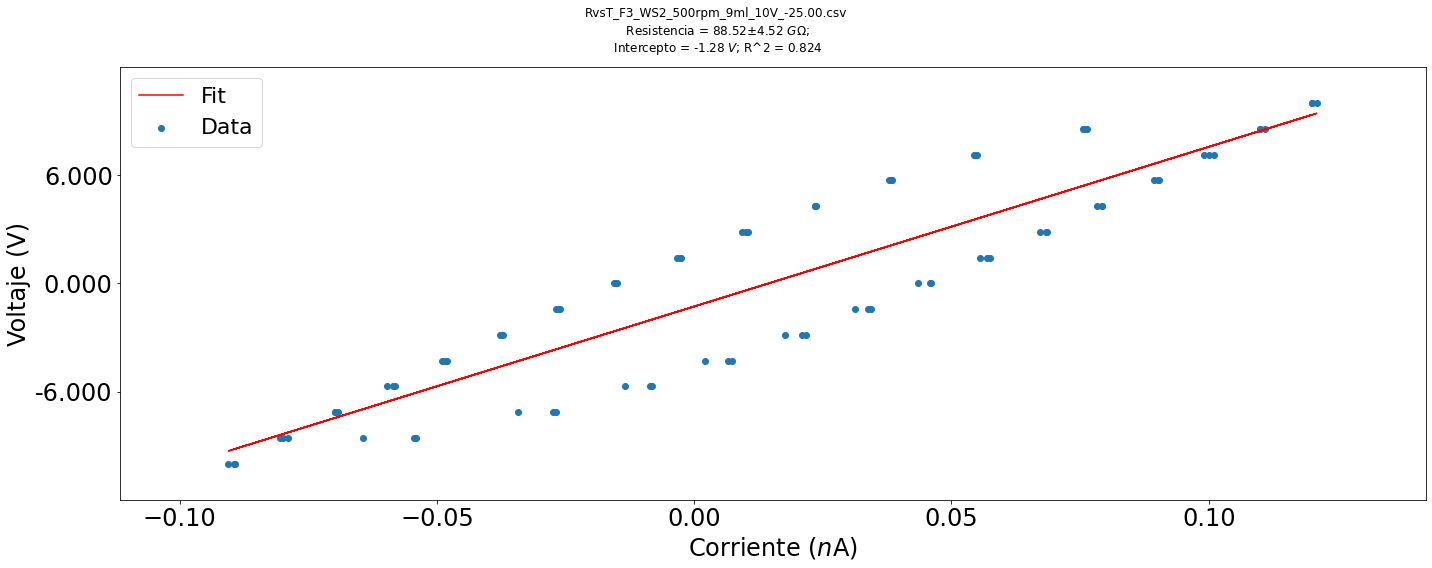

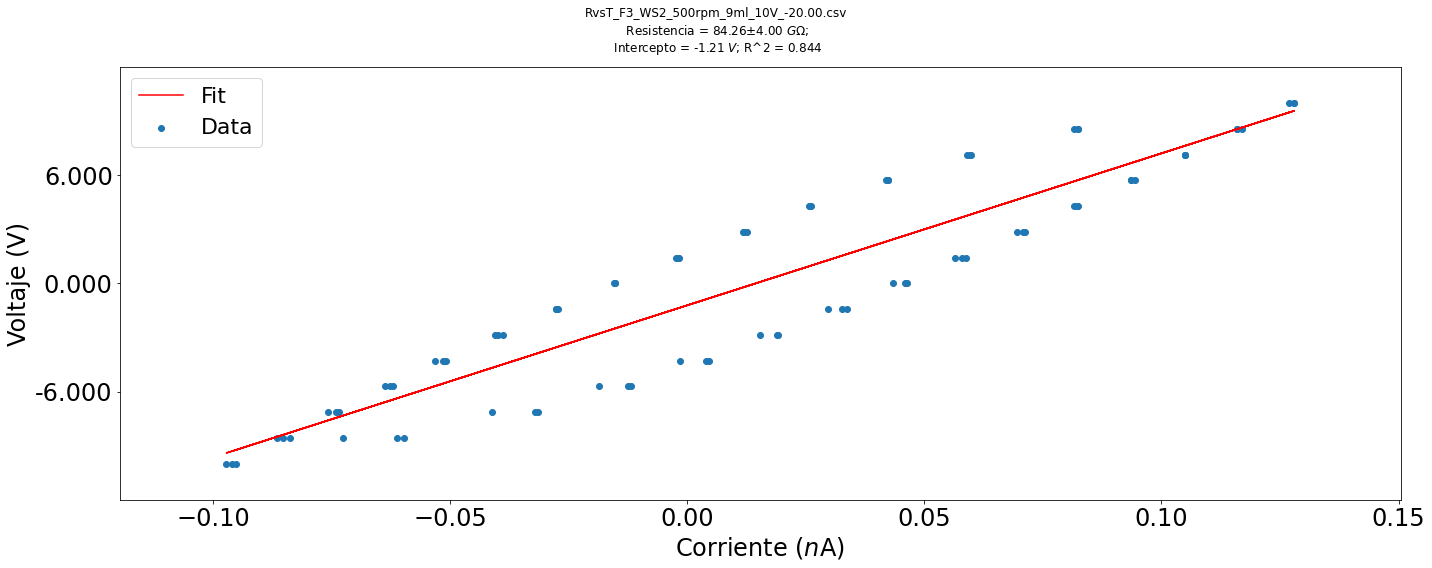

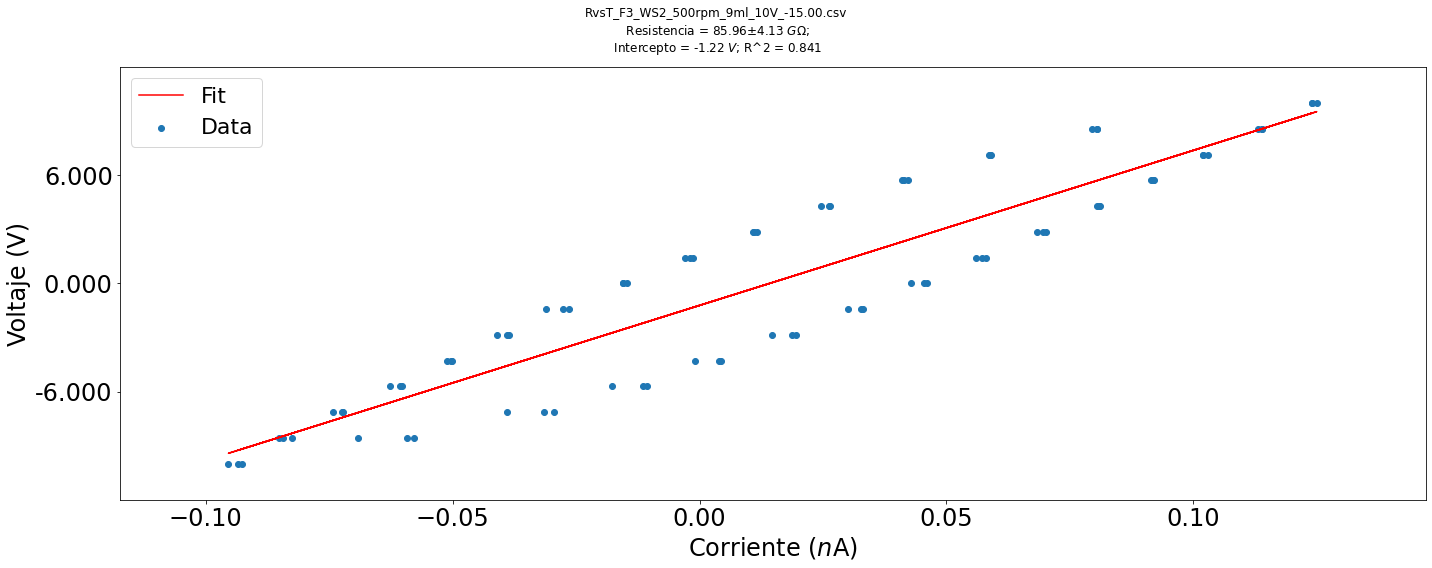

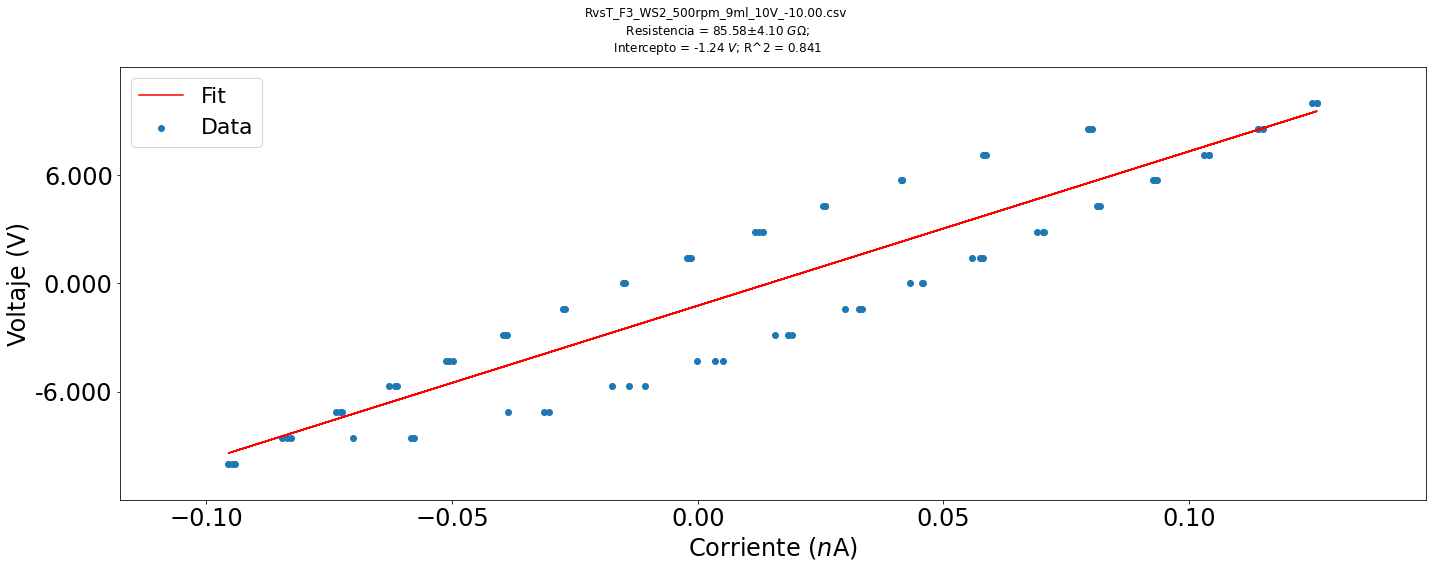

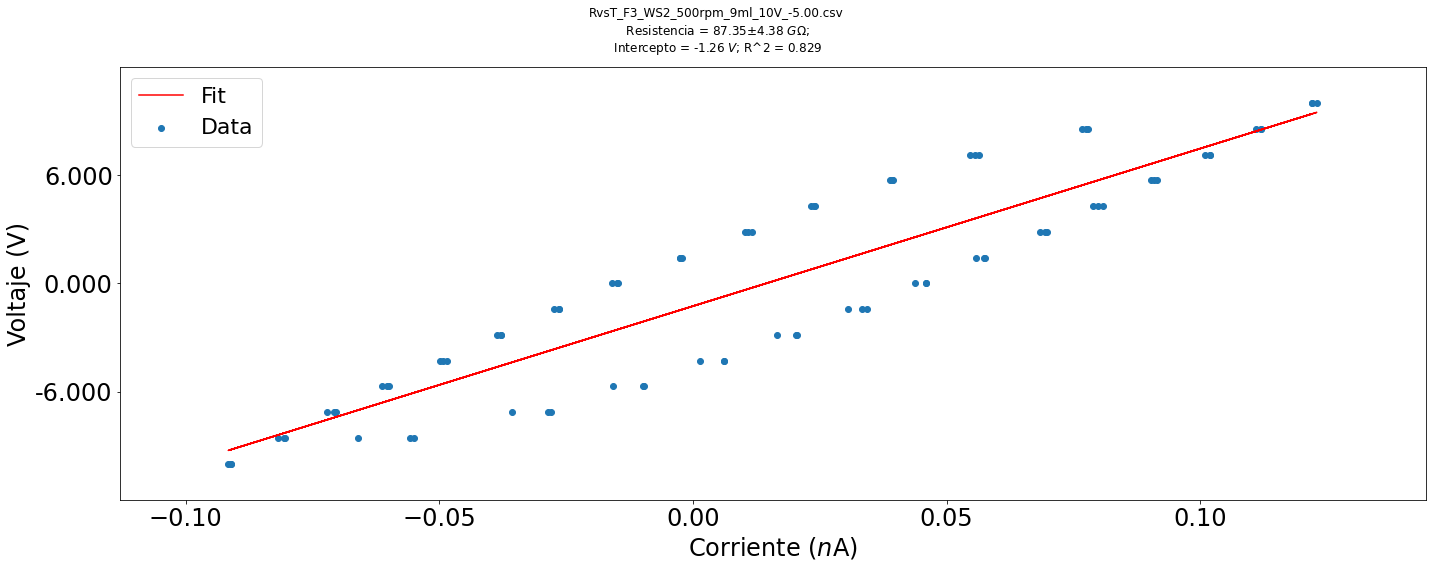

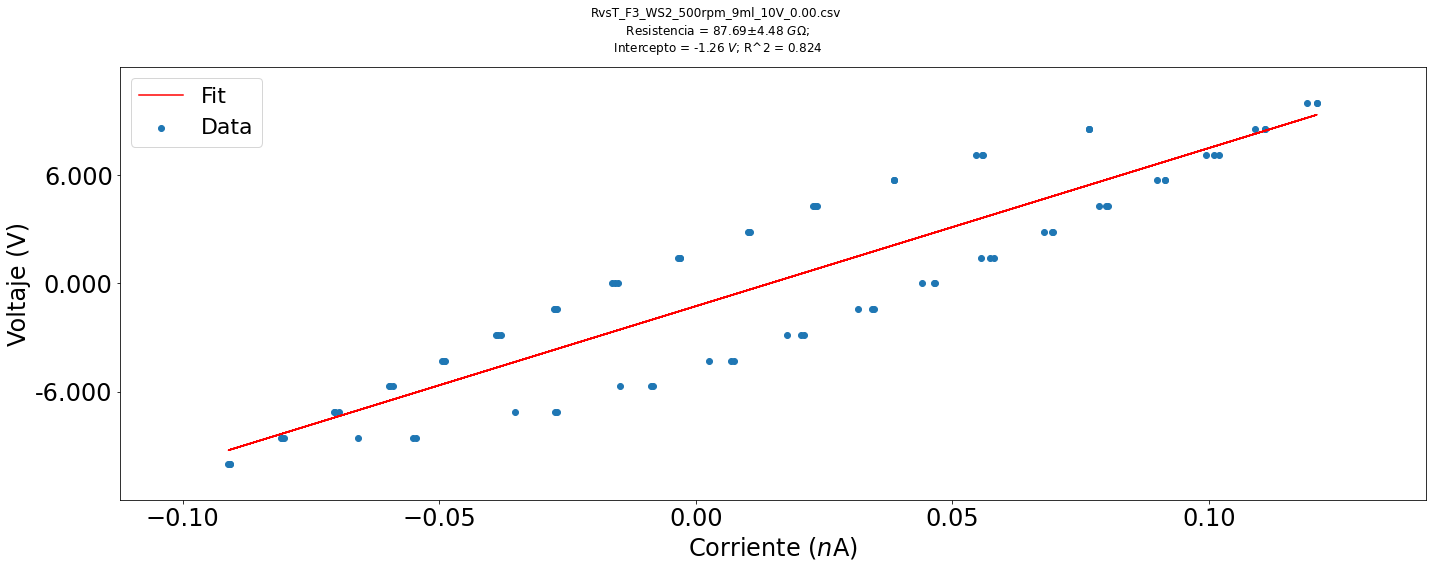

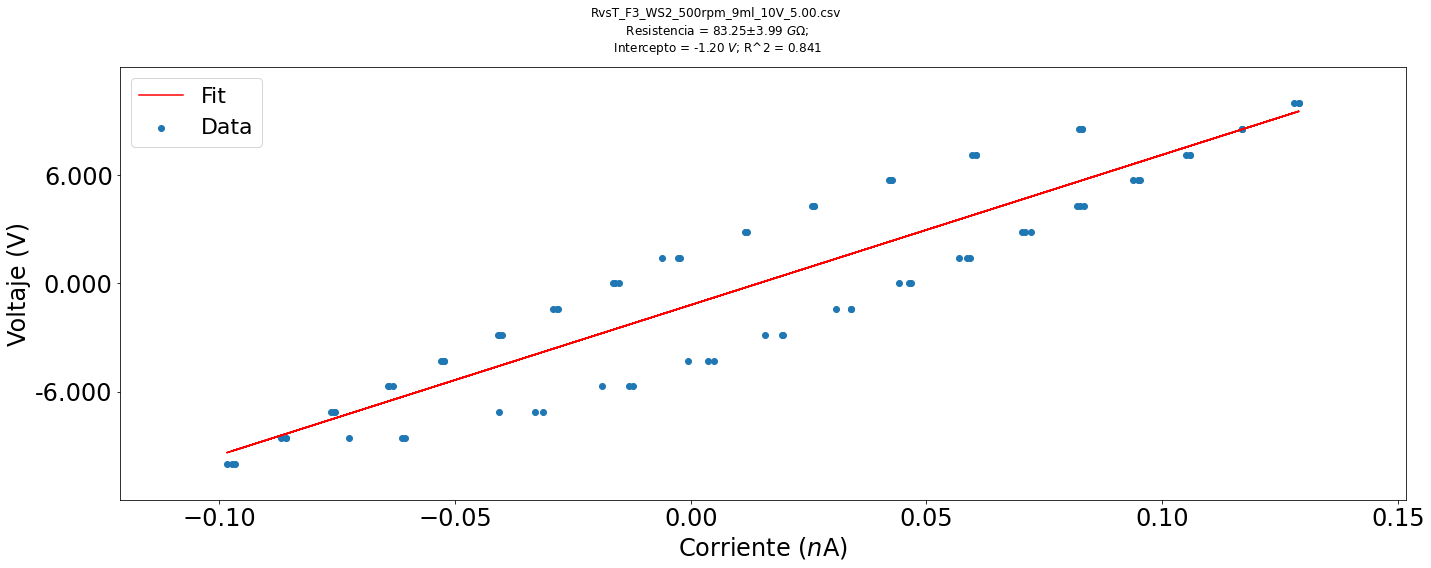

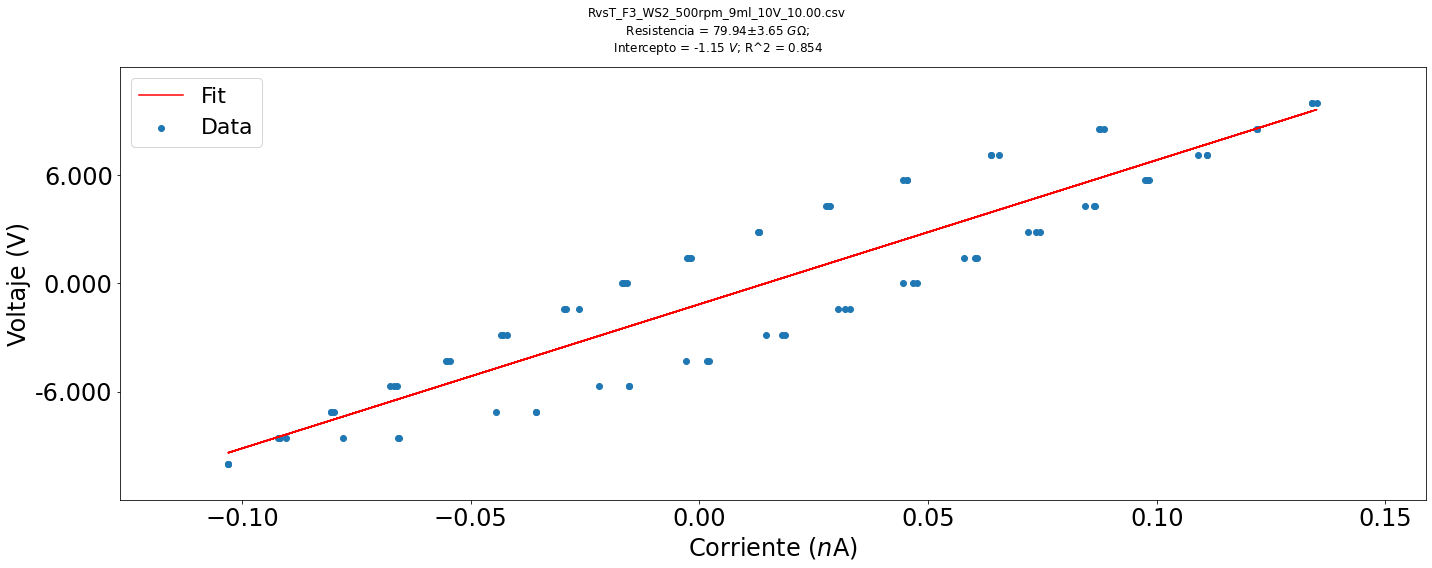

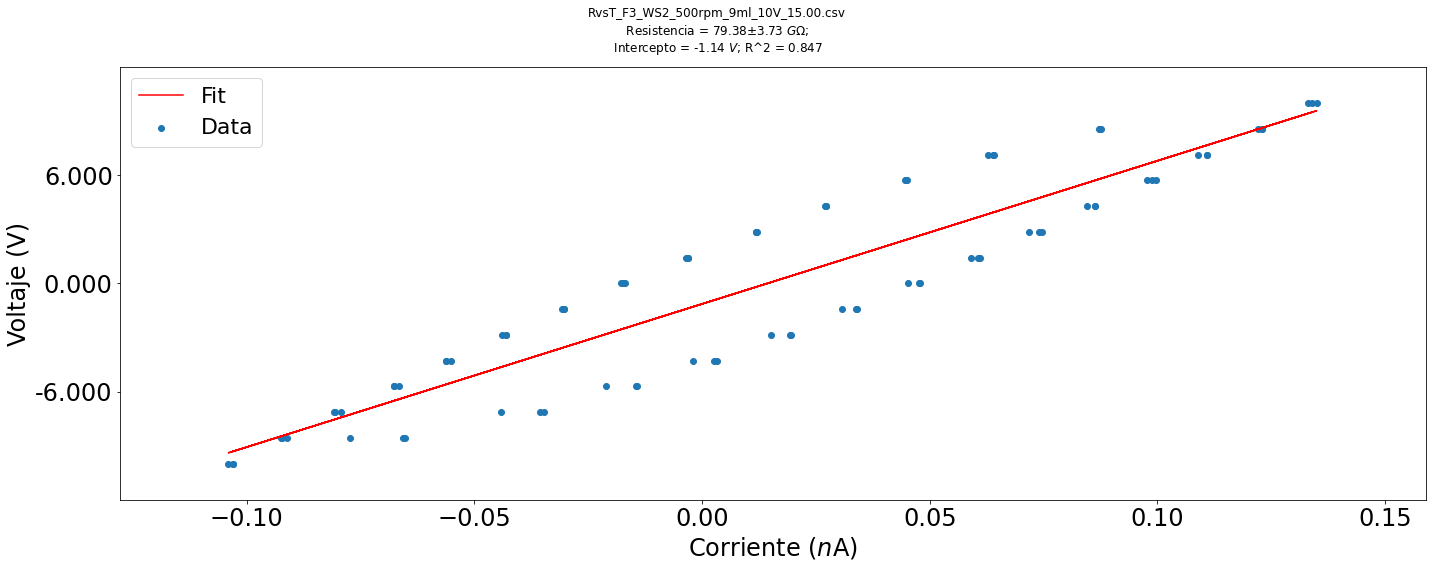

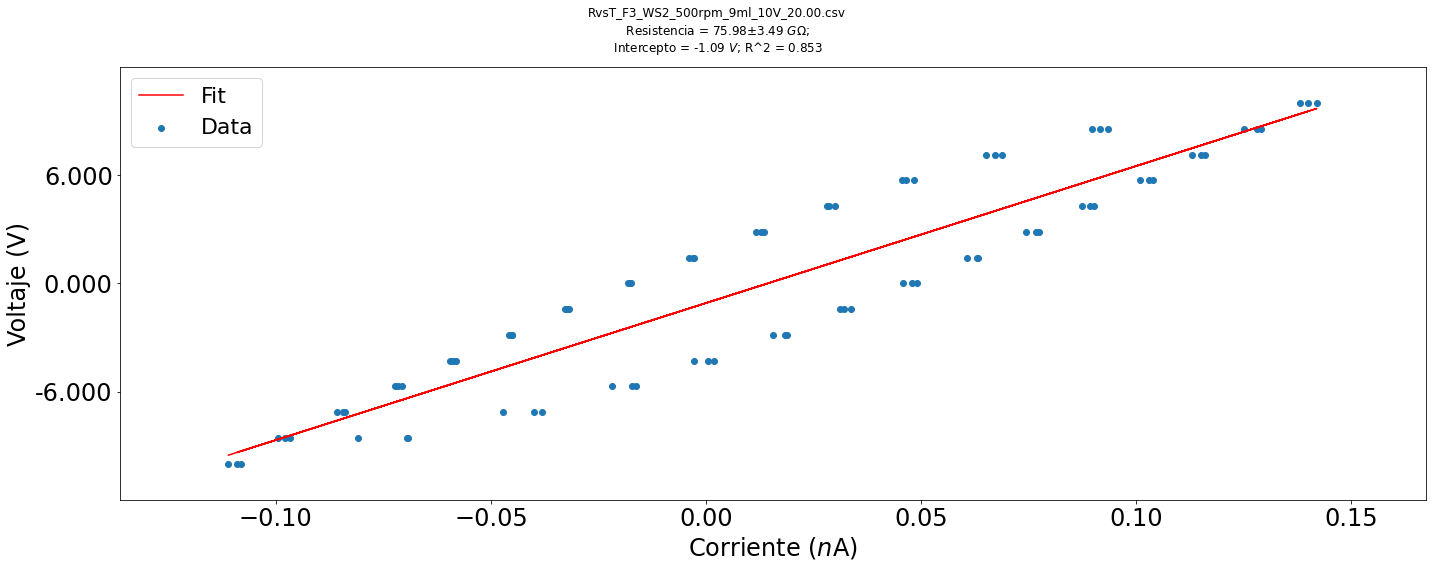

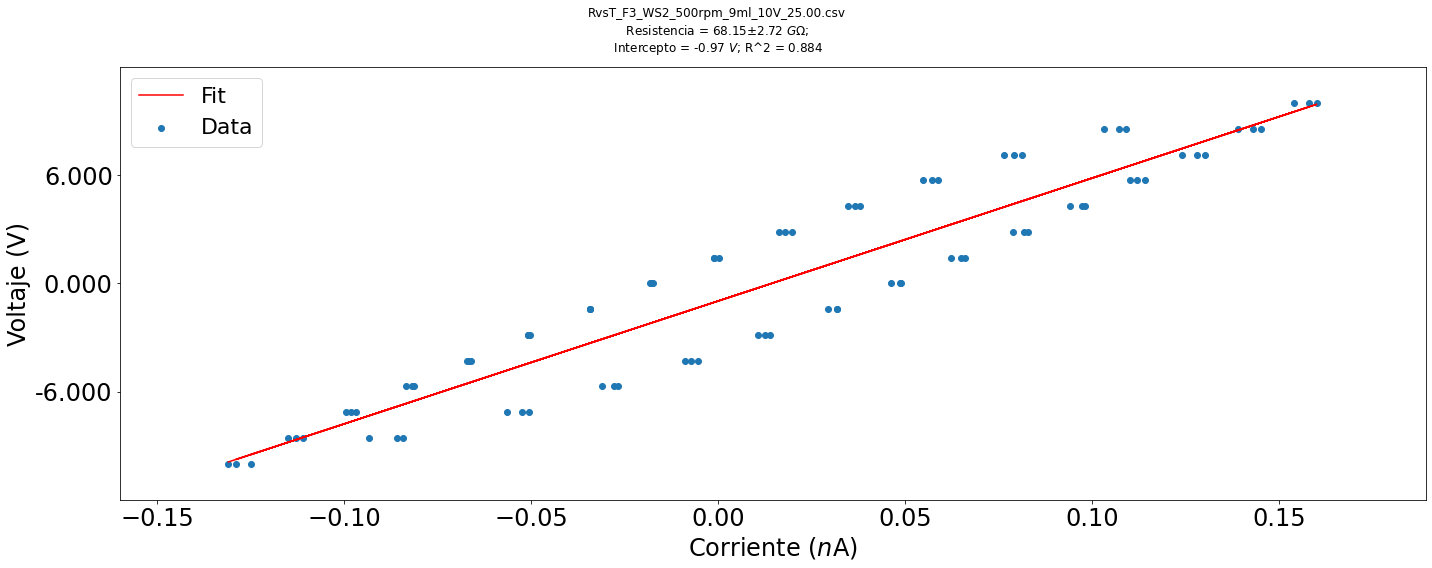

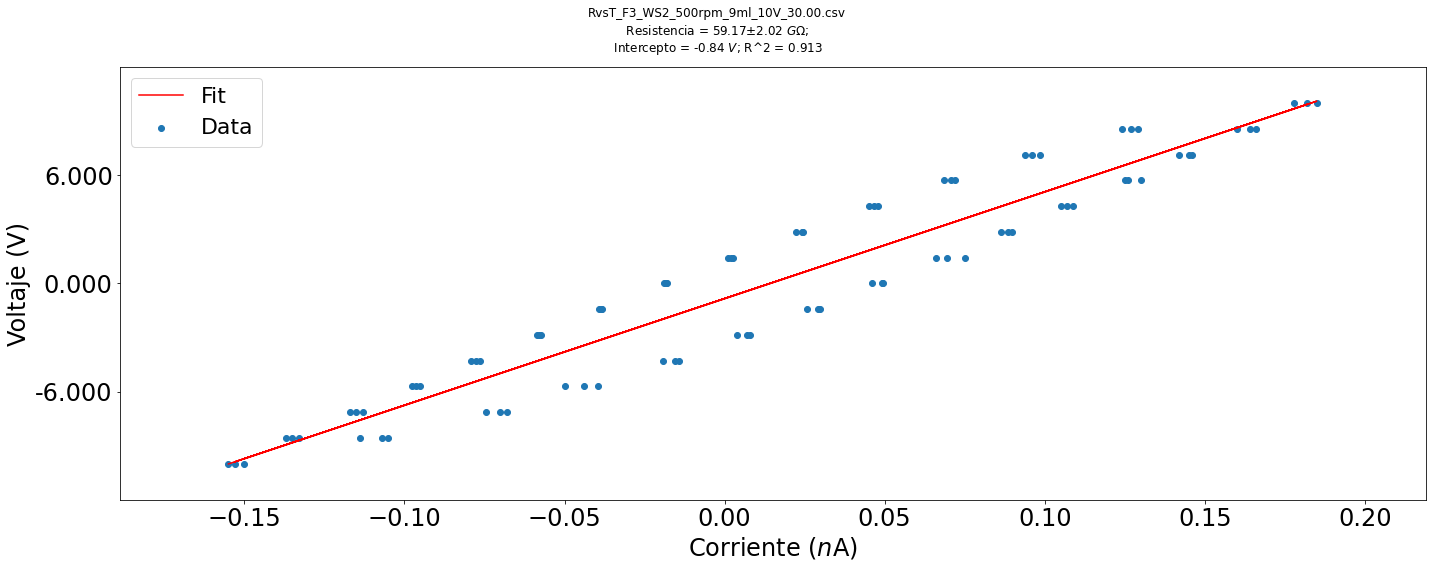

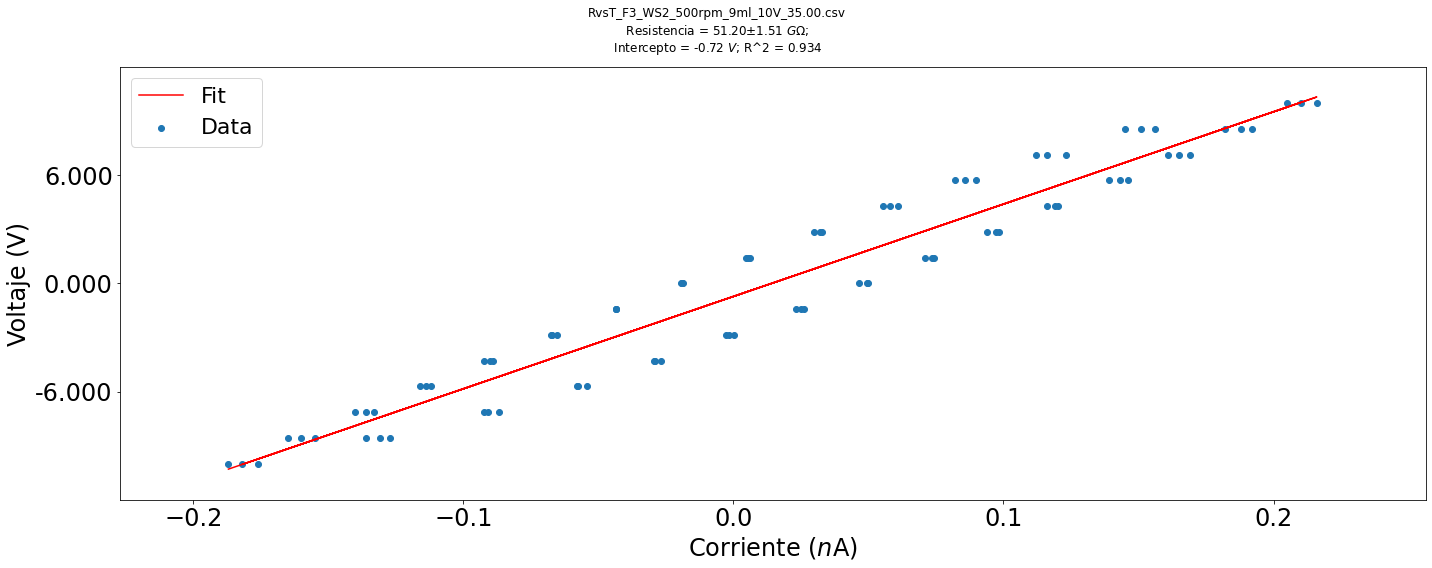

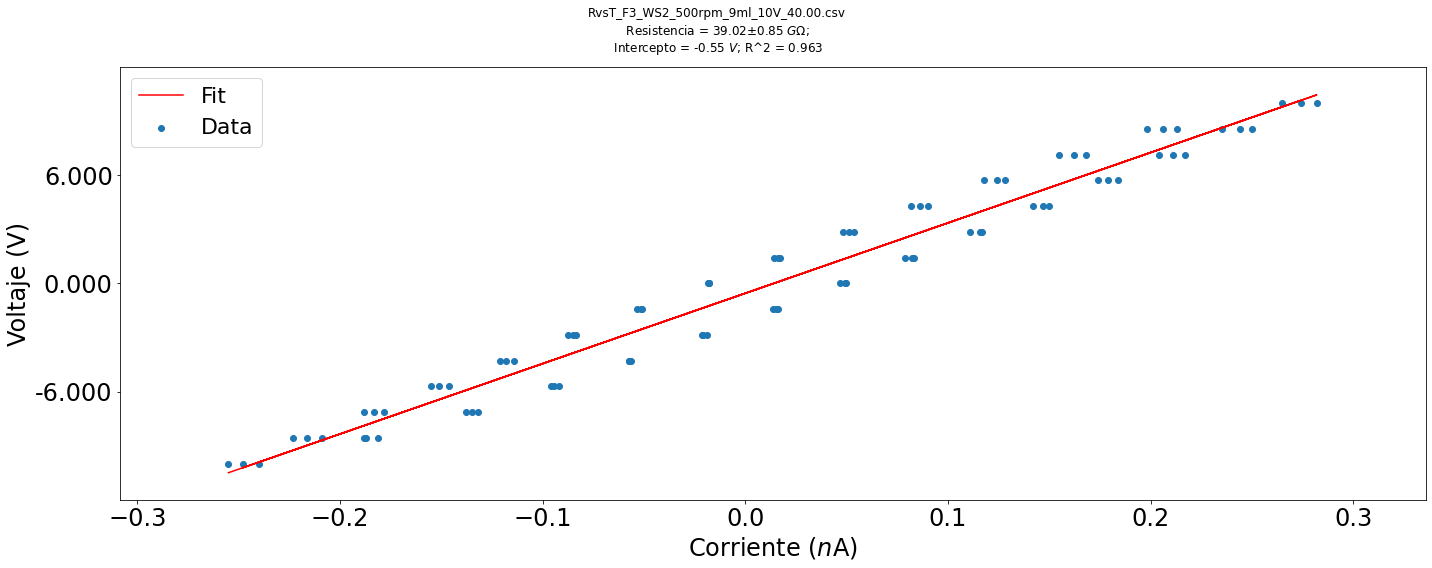

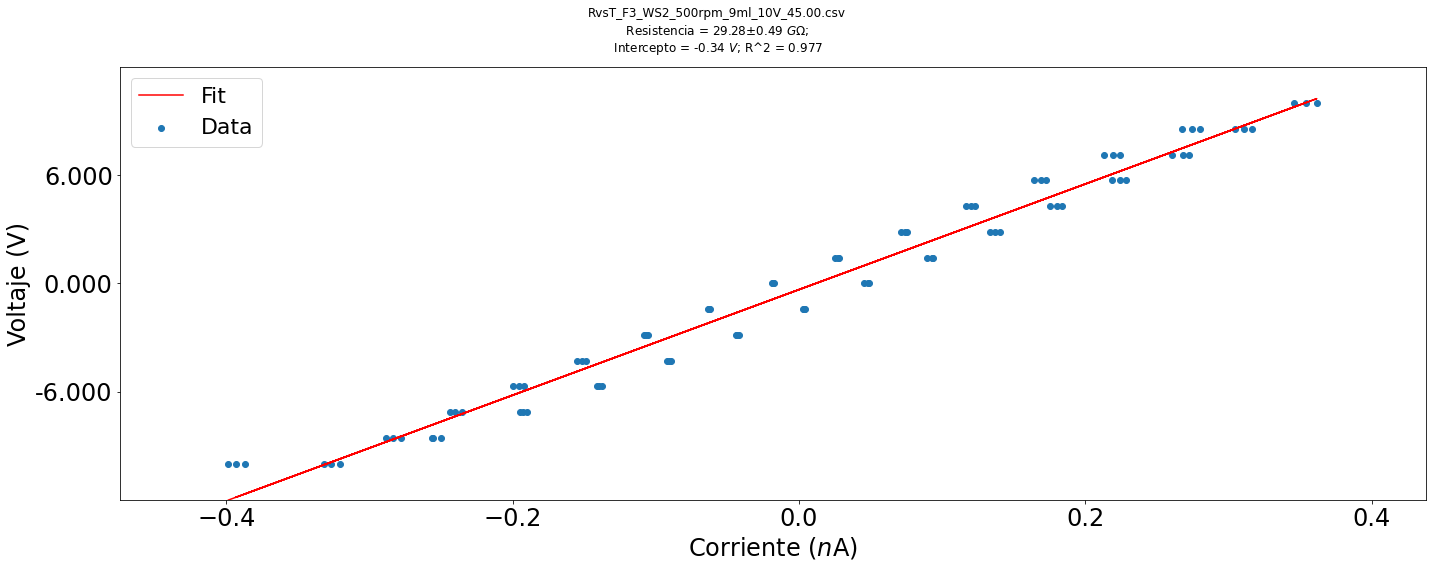

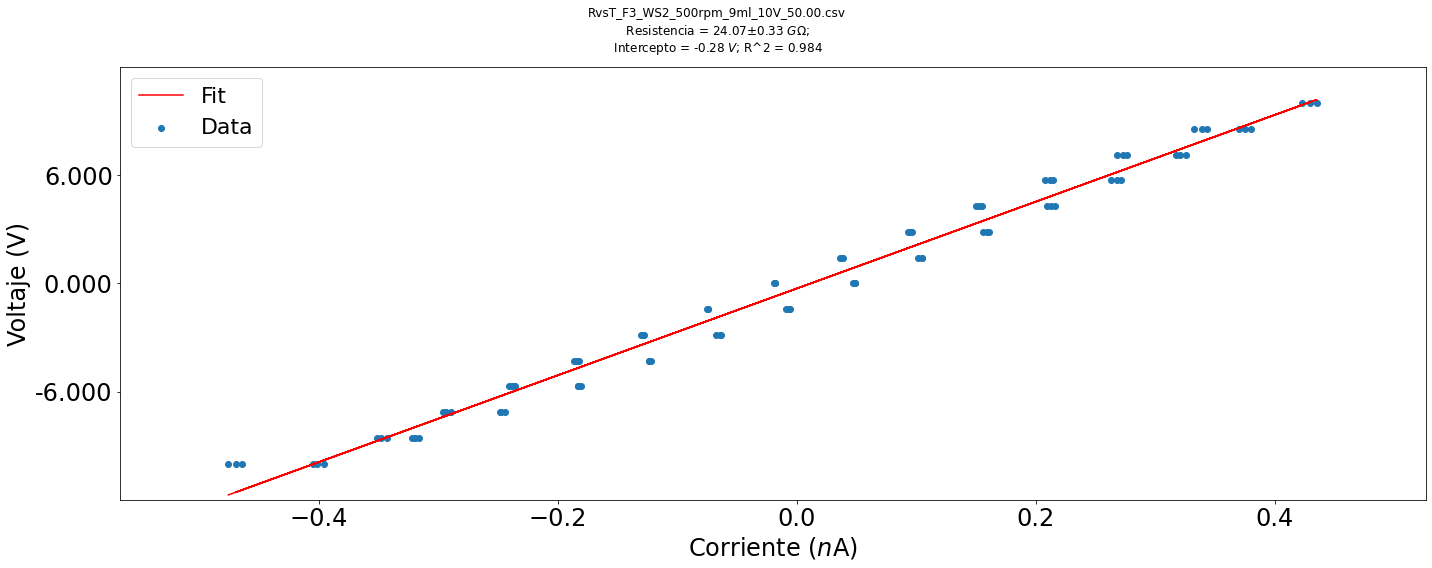

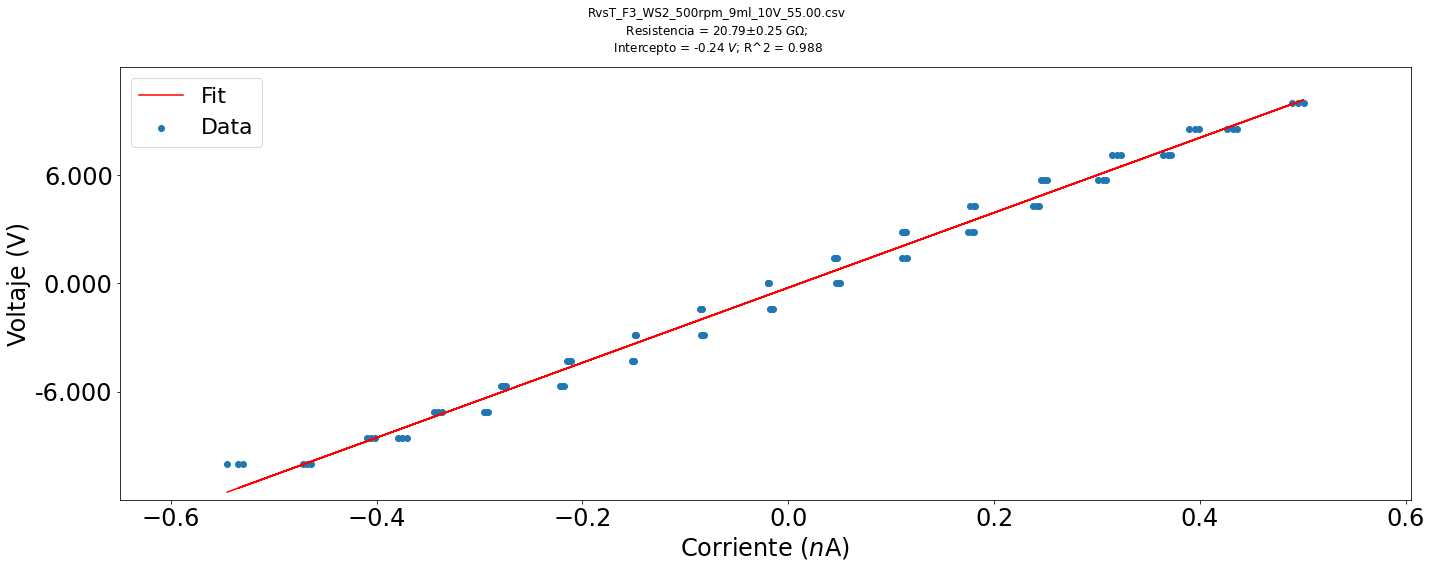

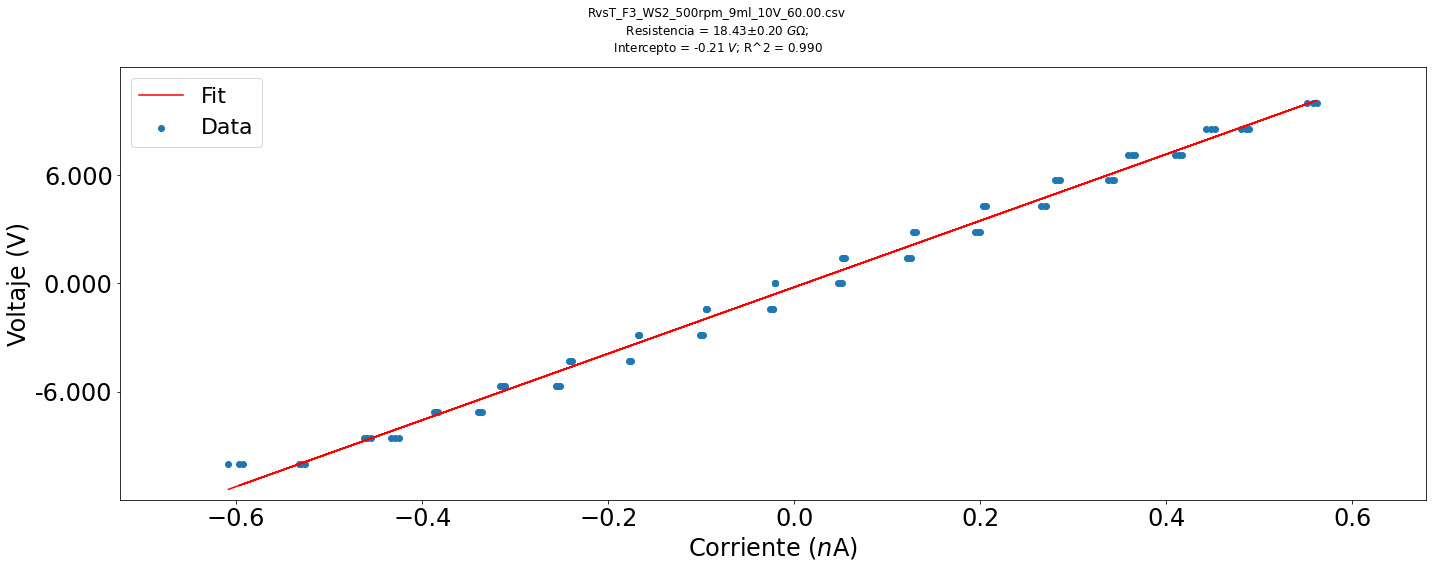

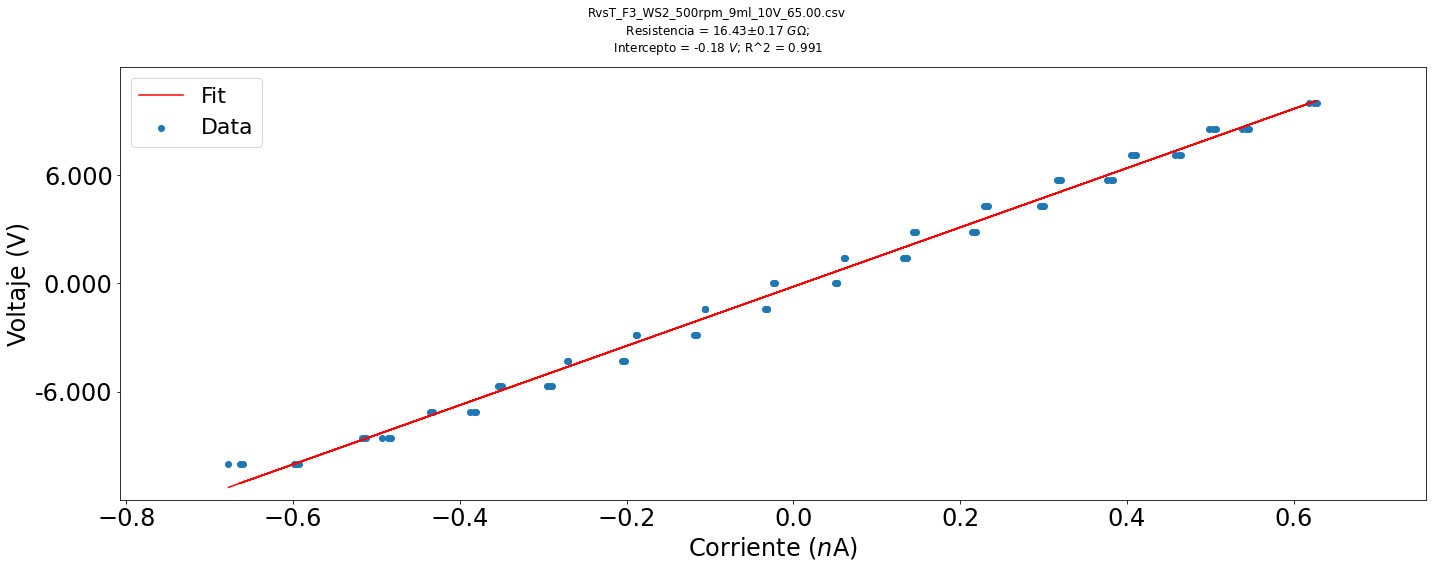

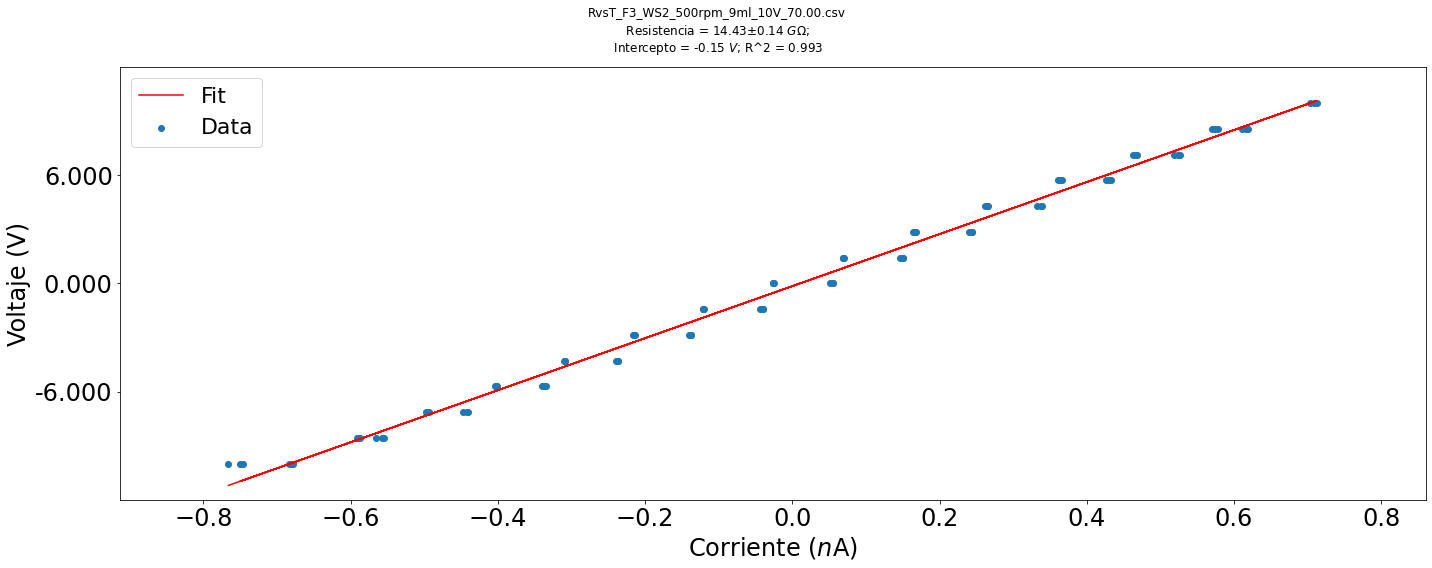

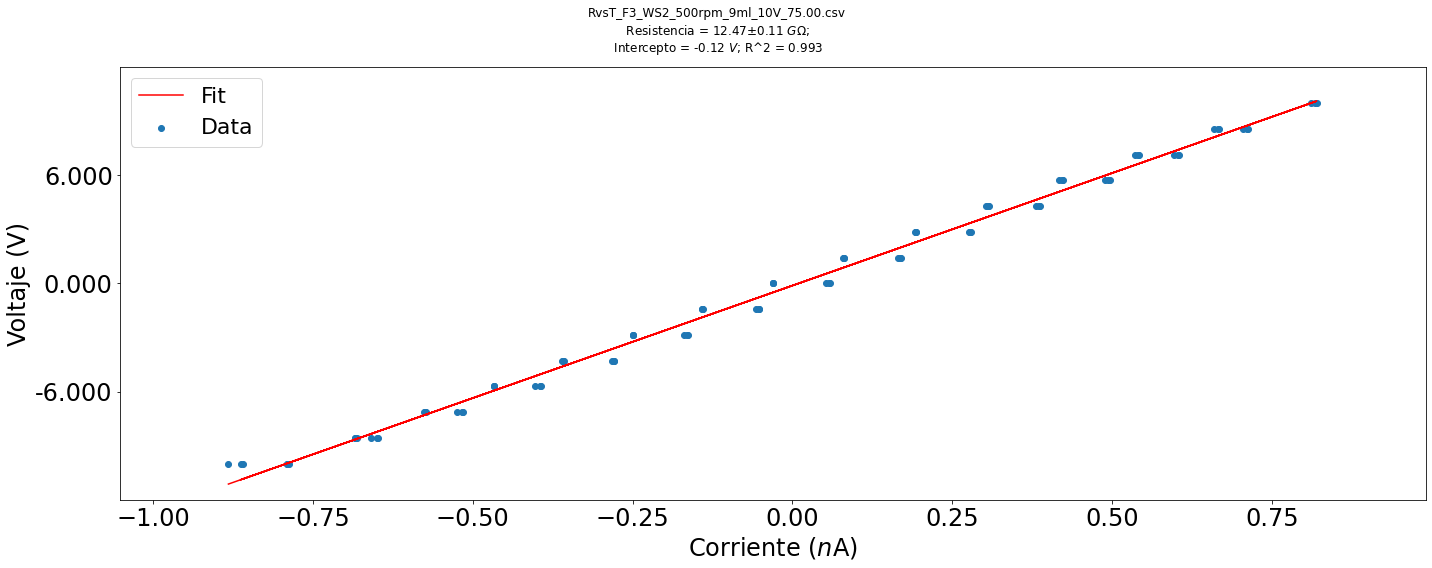

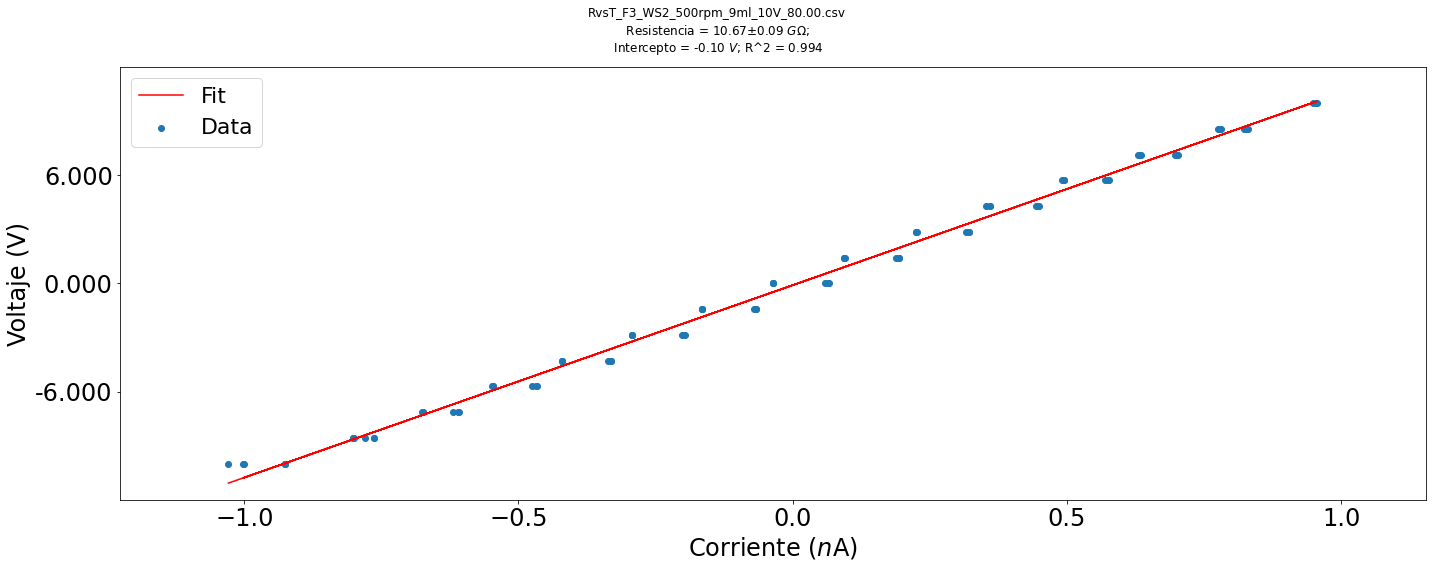

In [68]:
def generate_filenames():
    Tlist = np.linspace(-40,80,25)
    filenames = ['RvsT_F3_WS2_500rpm_9ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-40,80,25)
d = 1.77
t = 621.7
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(25,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0]),fig.add_subplot(gs[19,0]),fig.add_subplot(gs[20,0]),fig.add_subplot(gs[21,0]),fig.add_subplot(gs[22,0]),fig.add_subplot(gs[23,0]),fig.add_subplot(gs[24,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for WS2 (500 rpm) with volume of 9ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)

C:\Users\danie\AppData\Local\Temp/ipykernel_29092/2328622022.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(20,8))


[95.82063560741776, 16.66253894766118, 15.63983405279619, 16.763336189894485, 19.8864657014212, 21.480281088195284, 26.006266832270438, 31.320786024873964, 36.52800118849183, 34.64815504537472, 24.889194491801835, 19.190981544914717, 15.306496419669449, 15.164905246693614, 14.808626710138745, 13.988625834302223, 13.119582604102137, 12.423275533288768, 11.624950414947584, 10.564952617728983, 9.468757834841945, 8.527337182939753, 7.703761385830786, 6.842036712354463, 6.109092159277651]


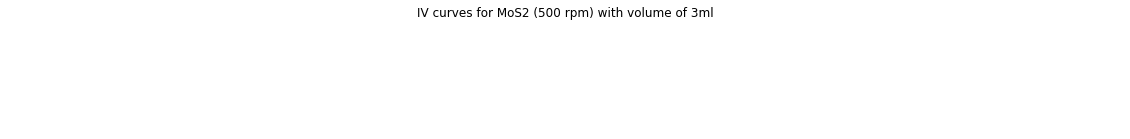

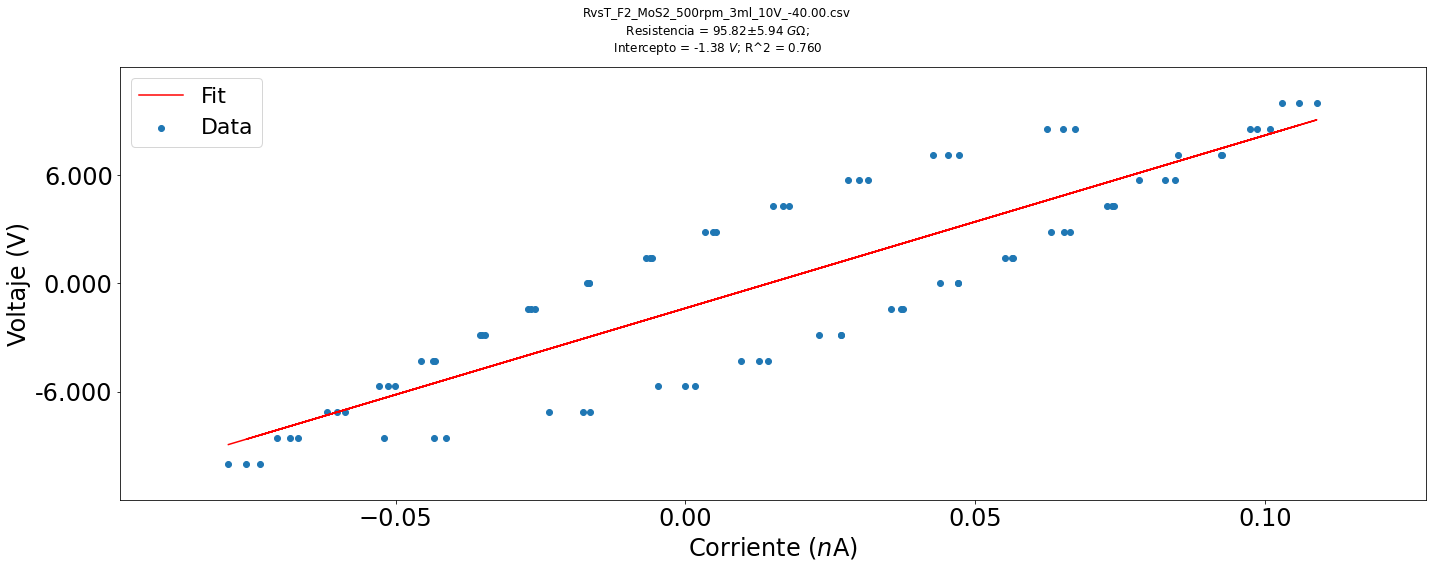

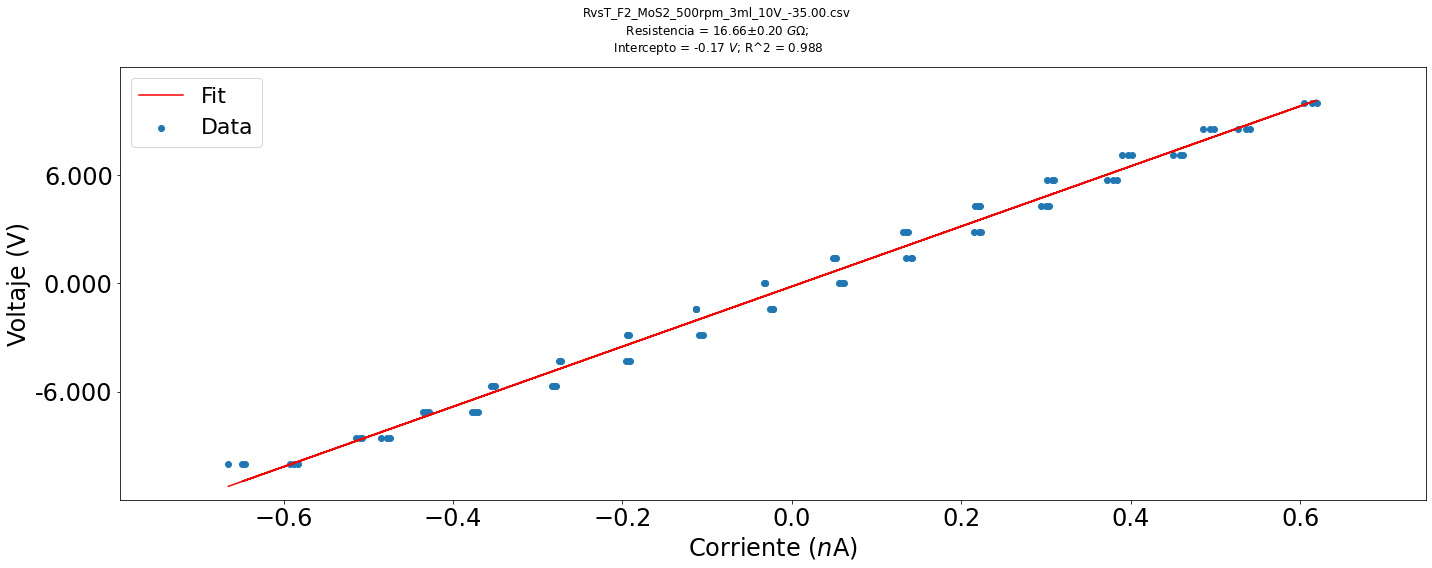

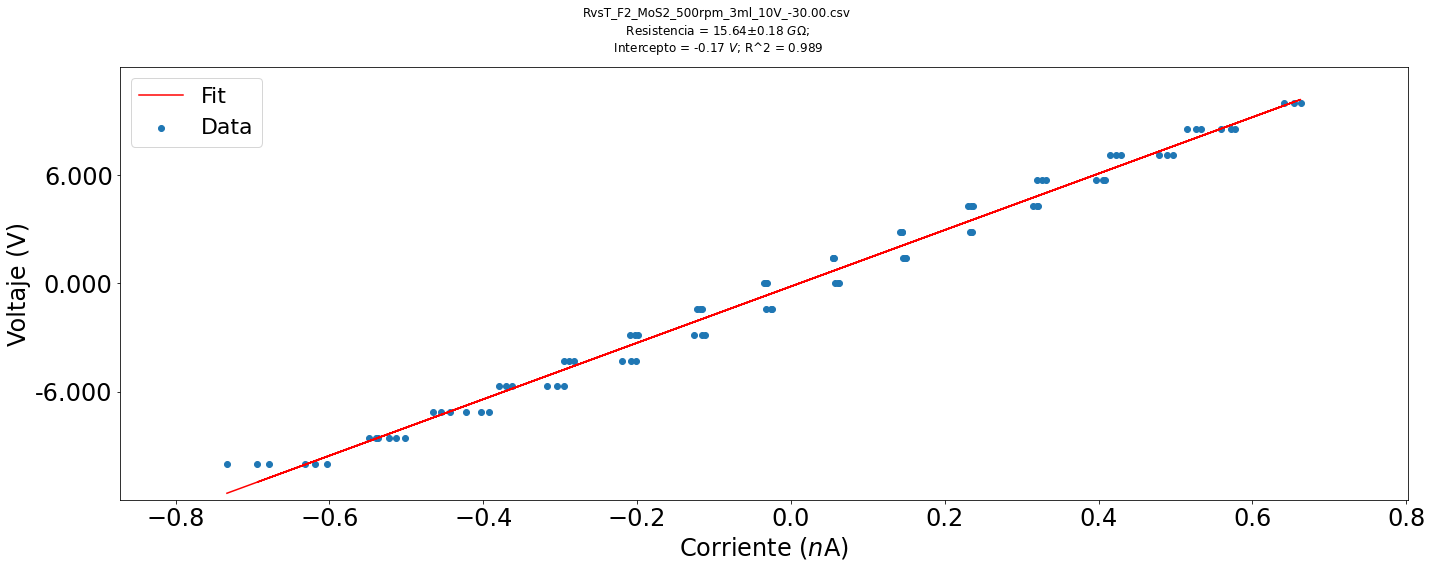

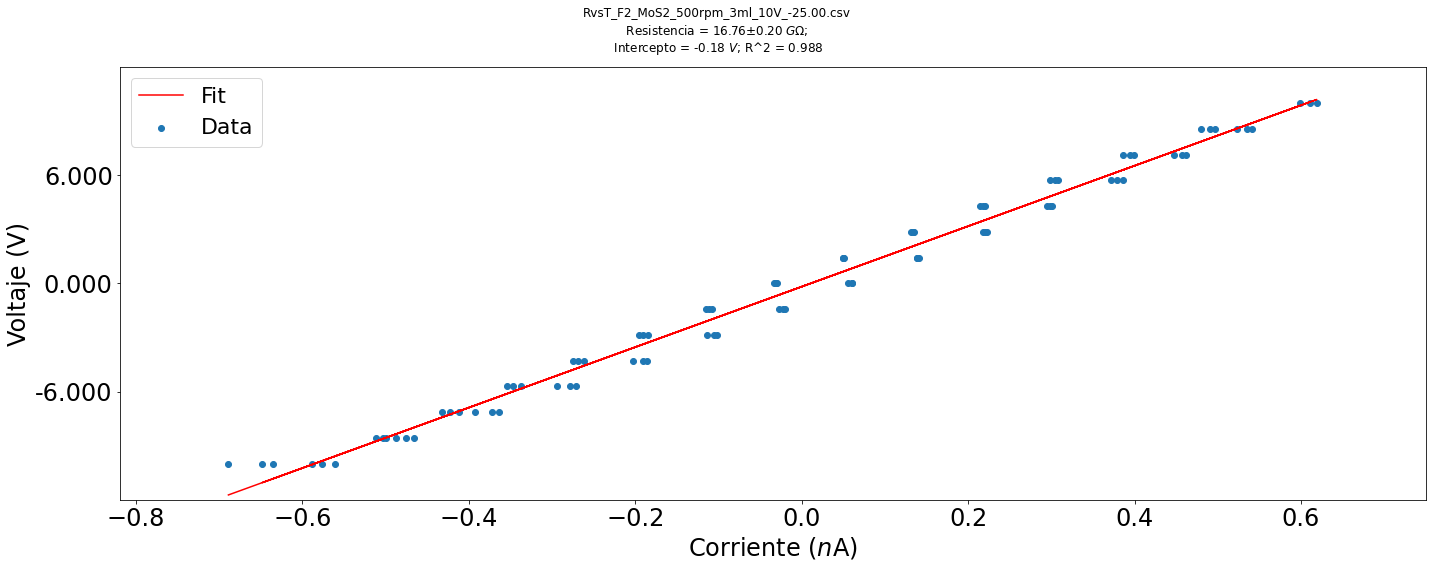

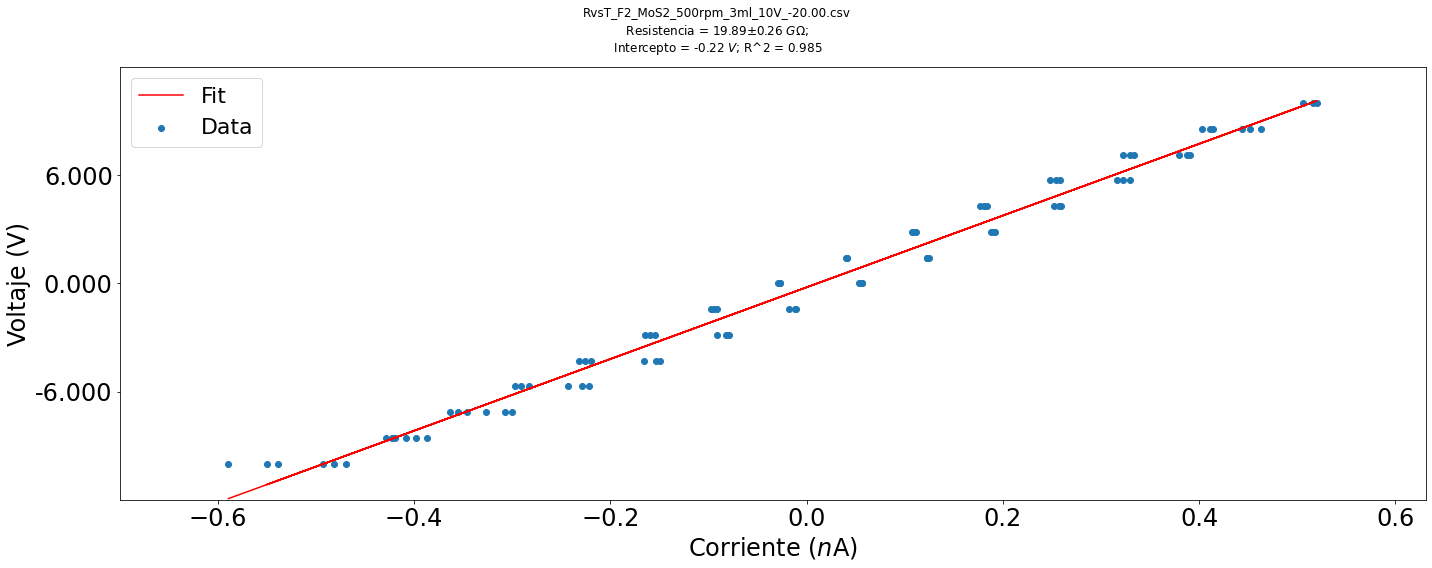

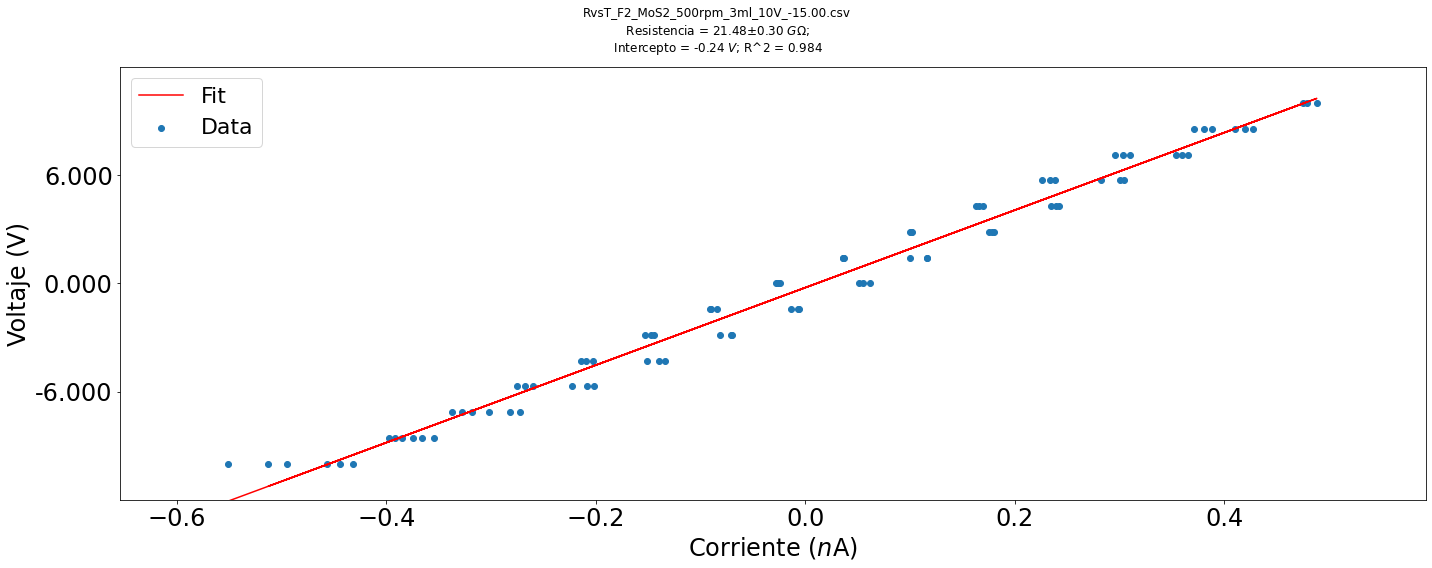

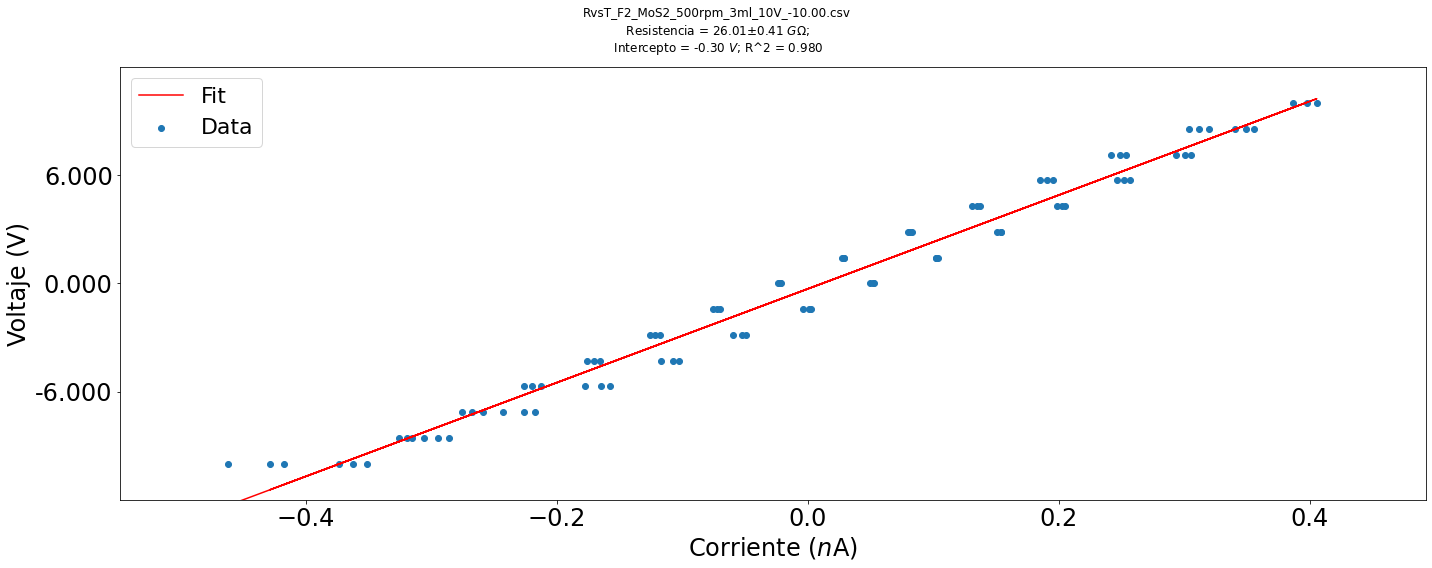

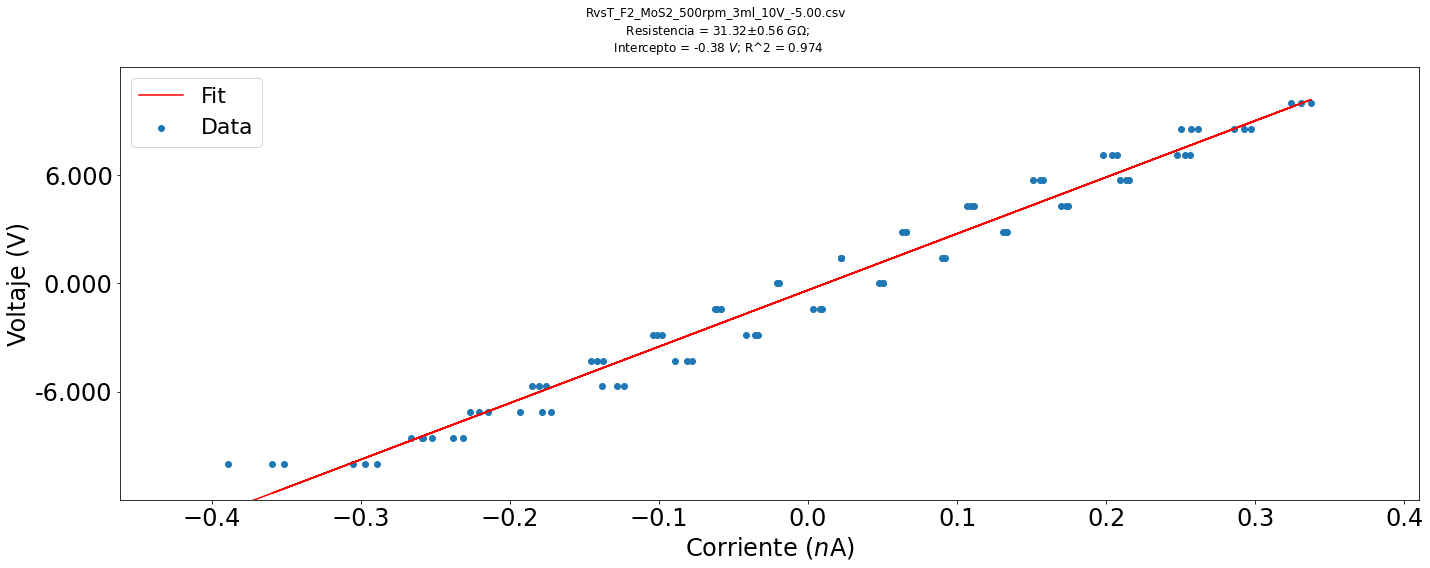

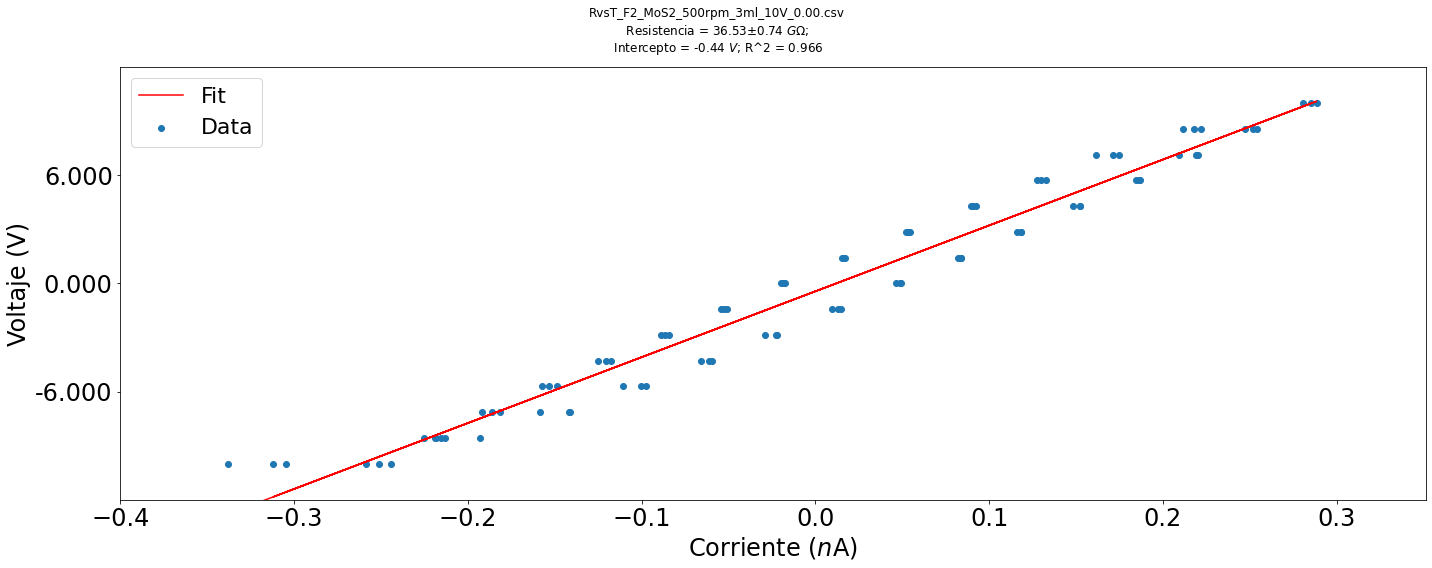

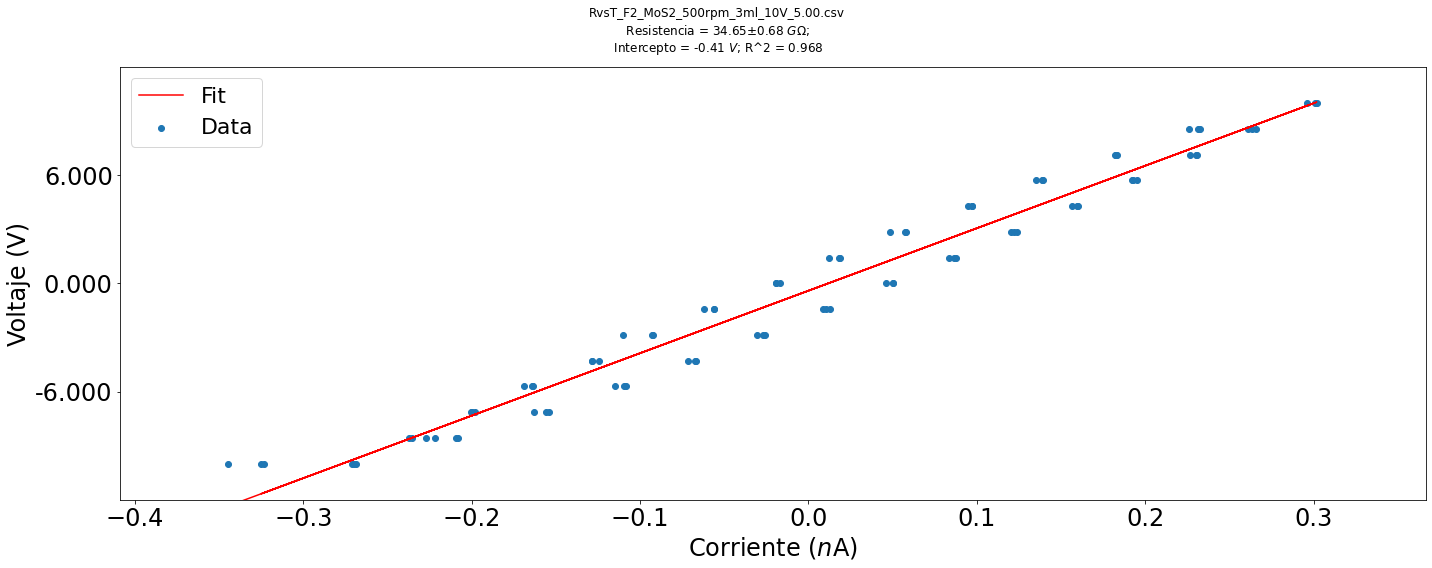

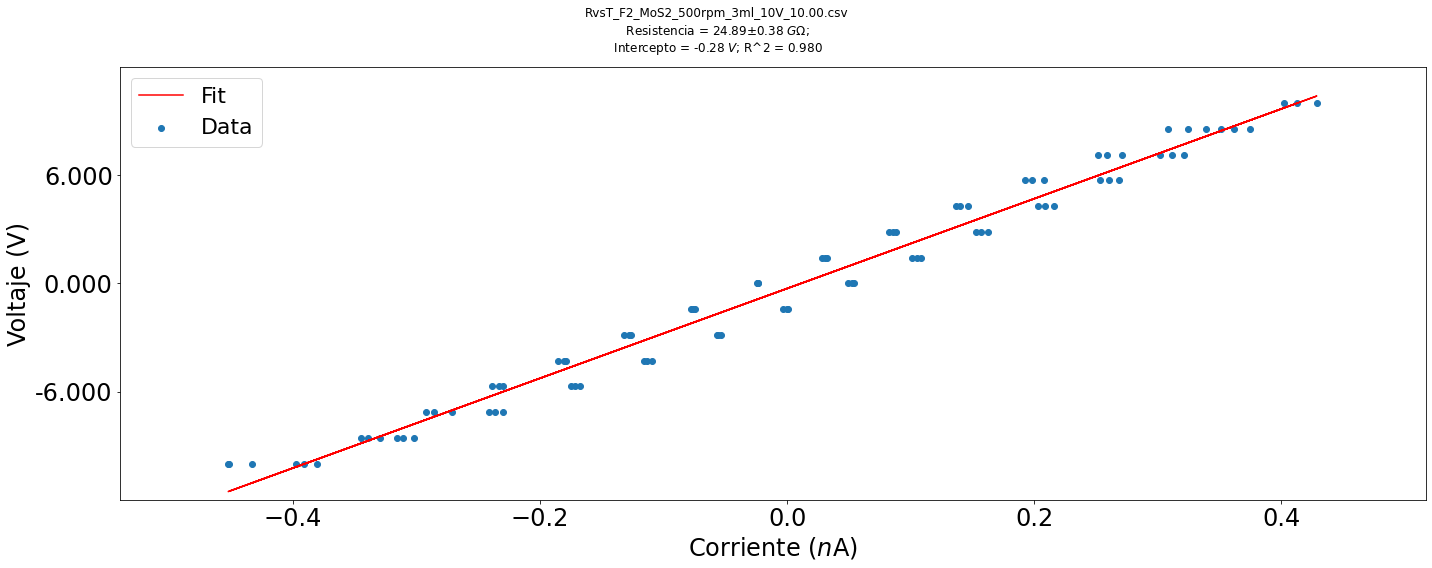

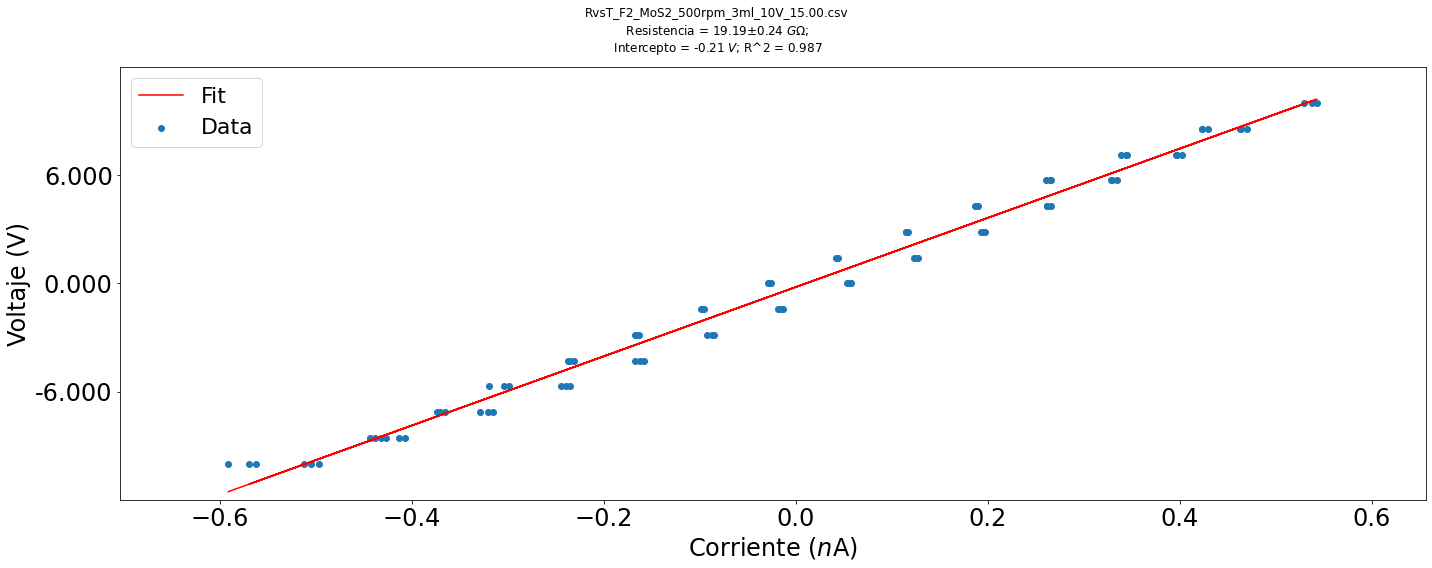

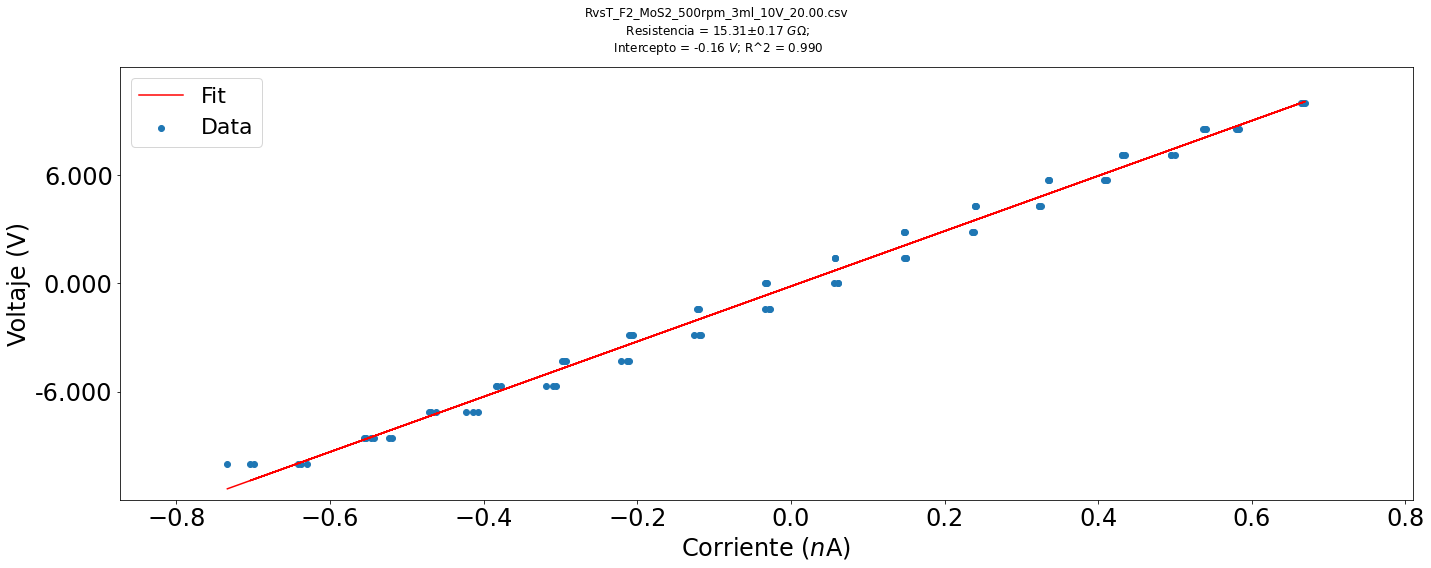

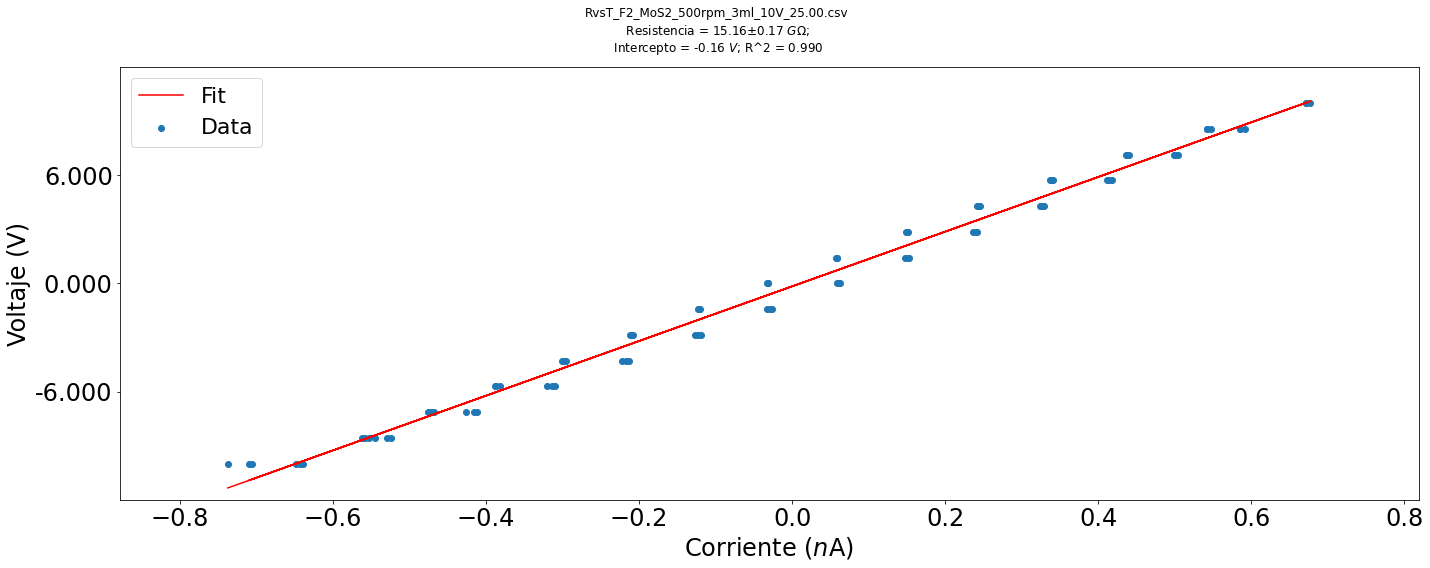

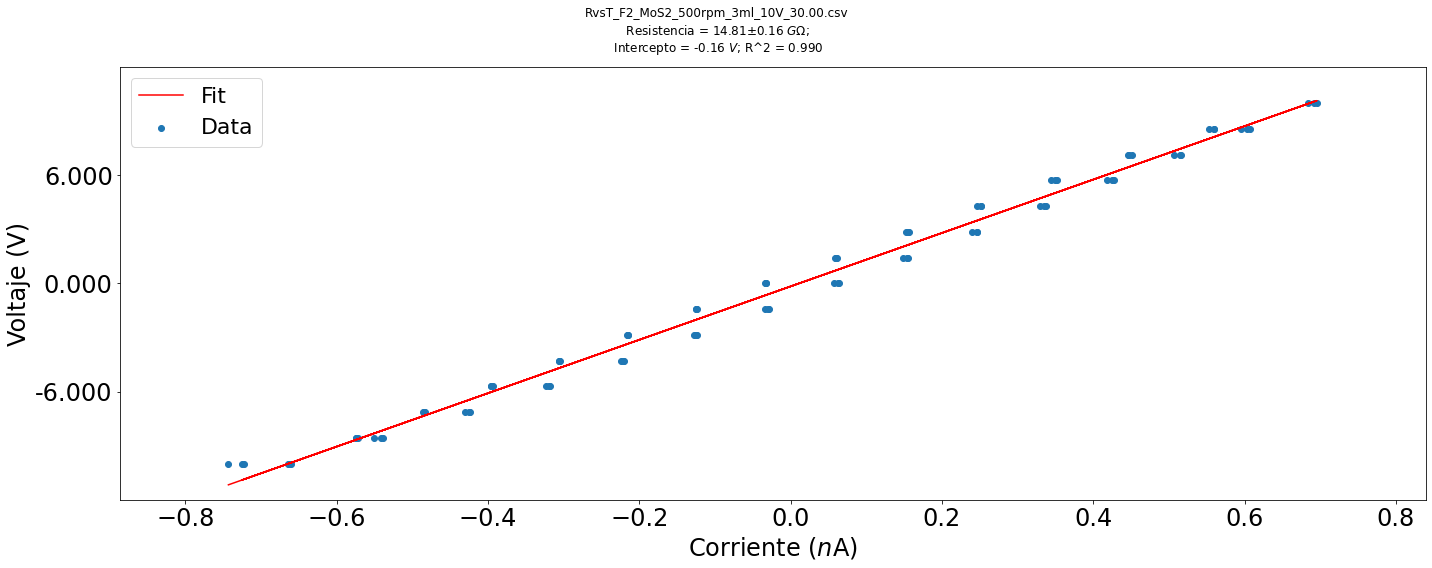

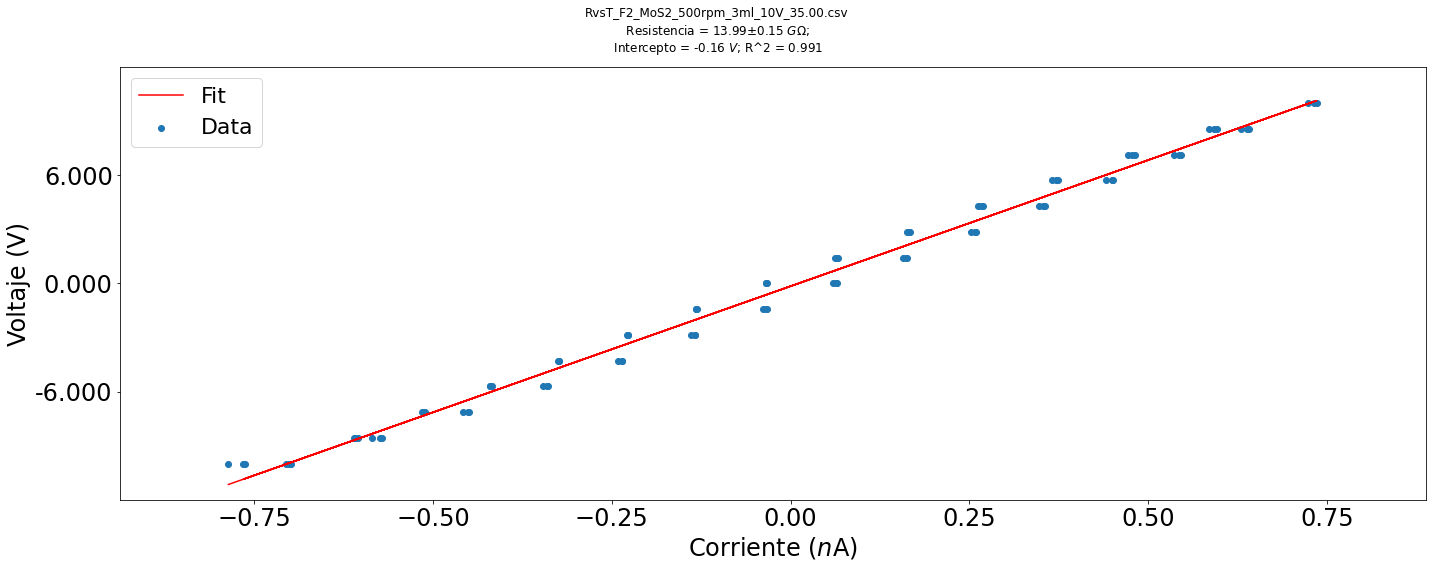

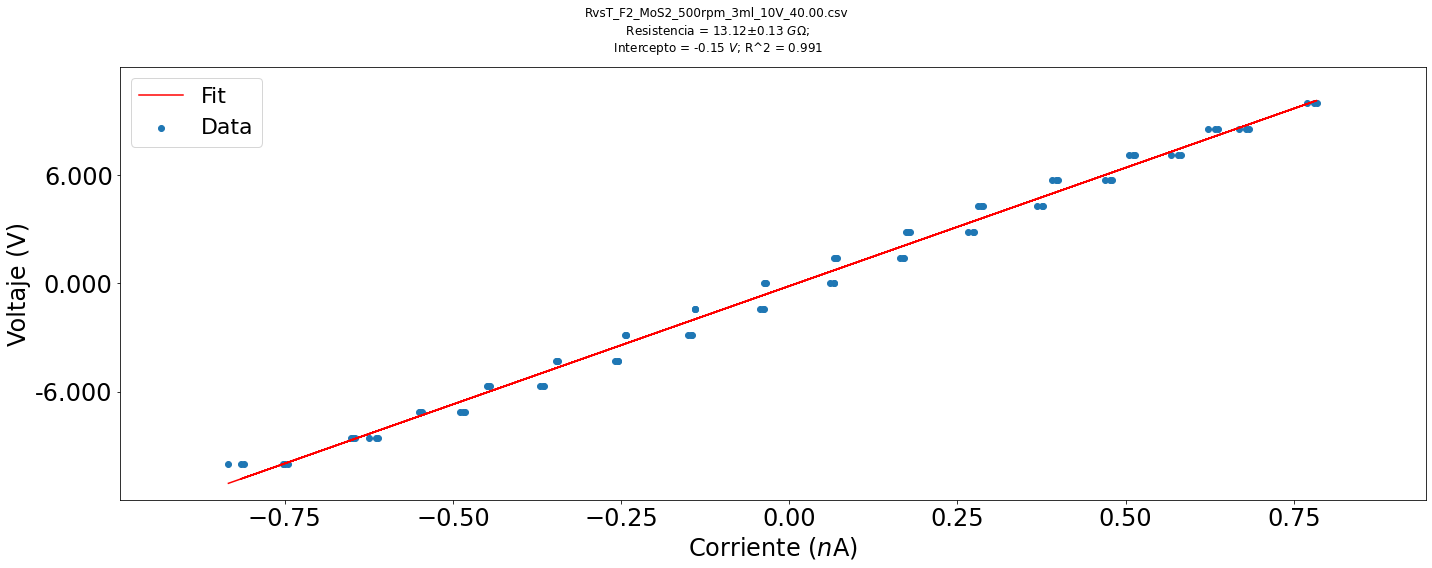

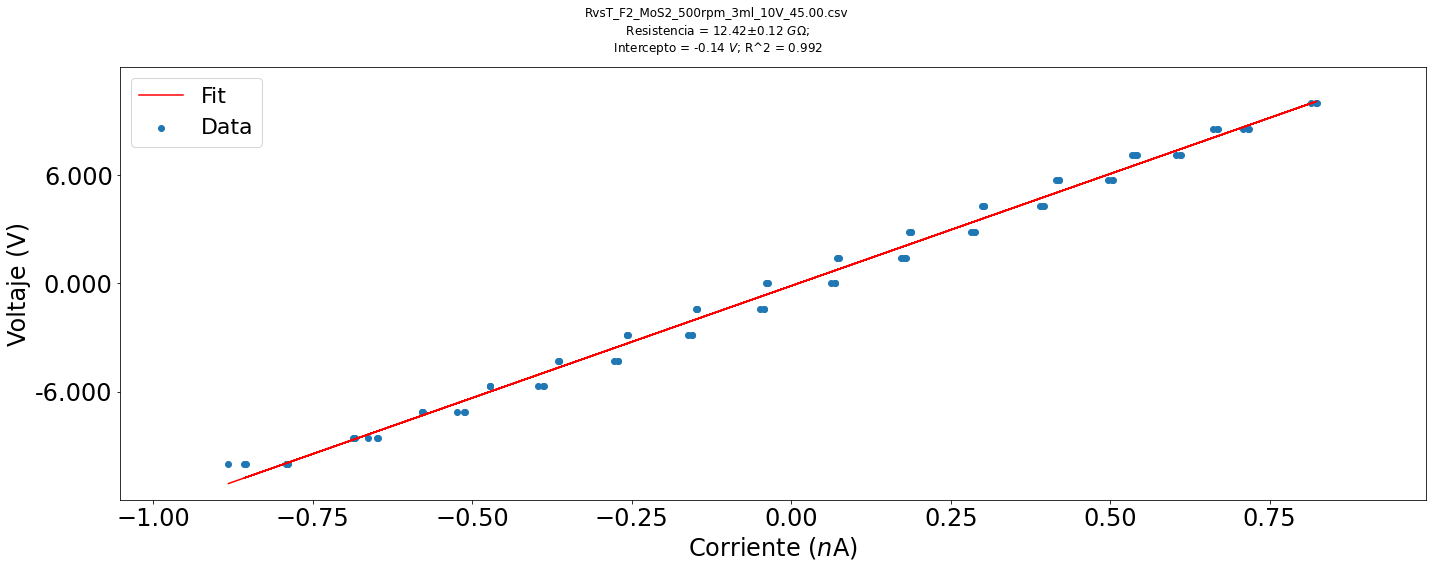

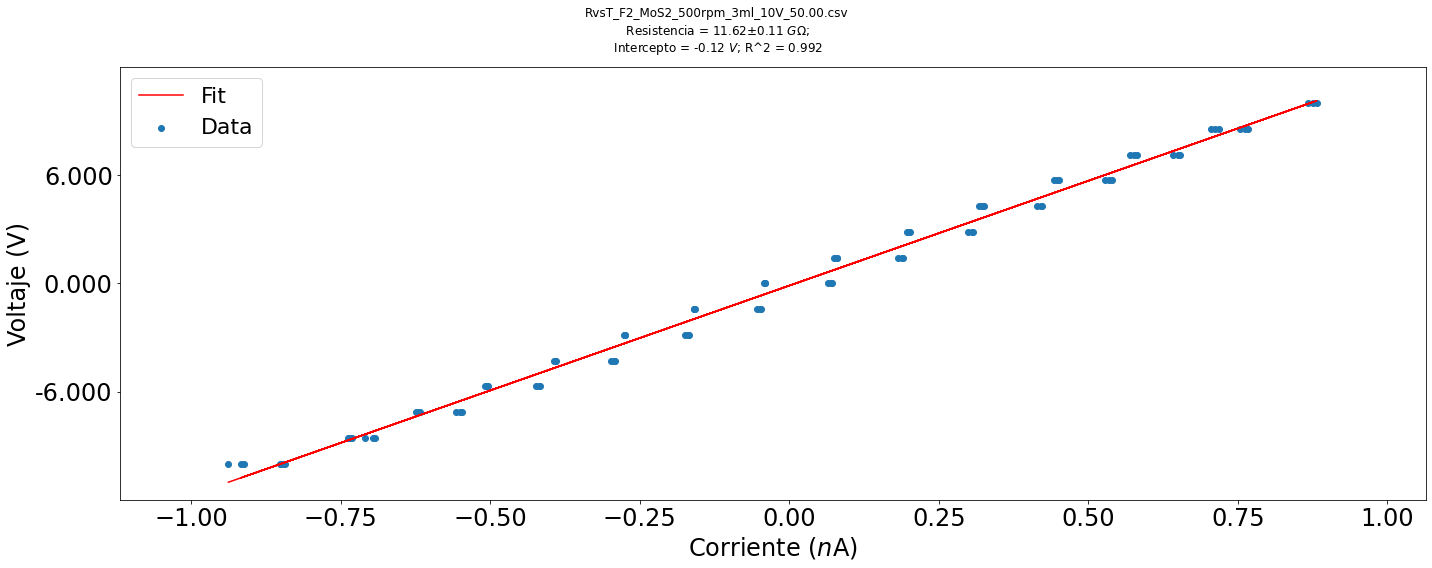

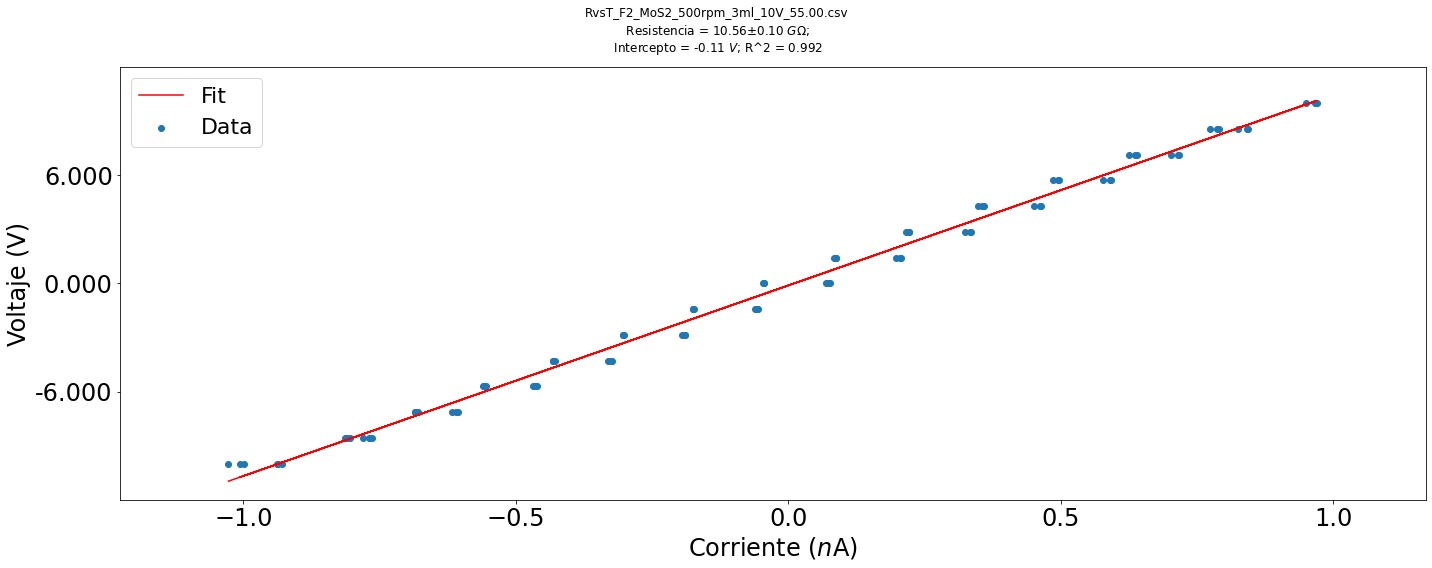

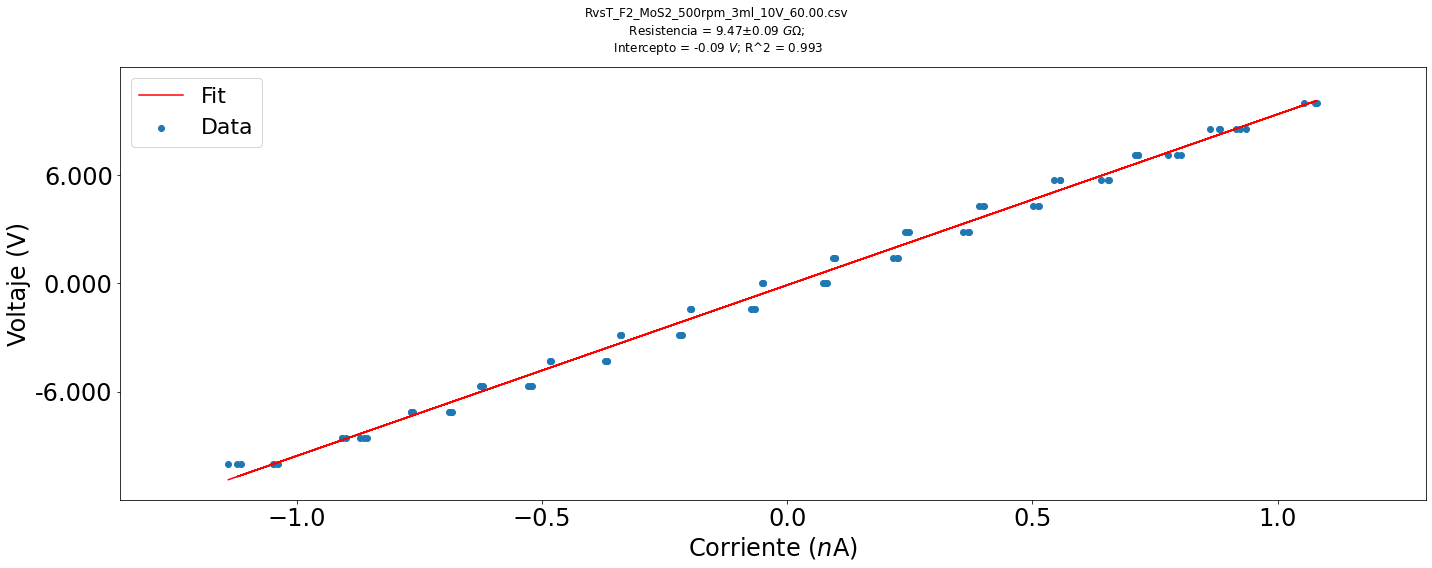

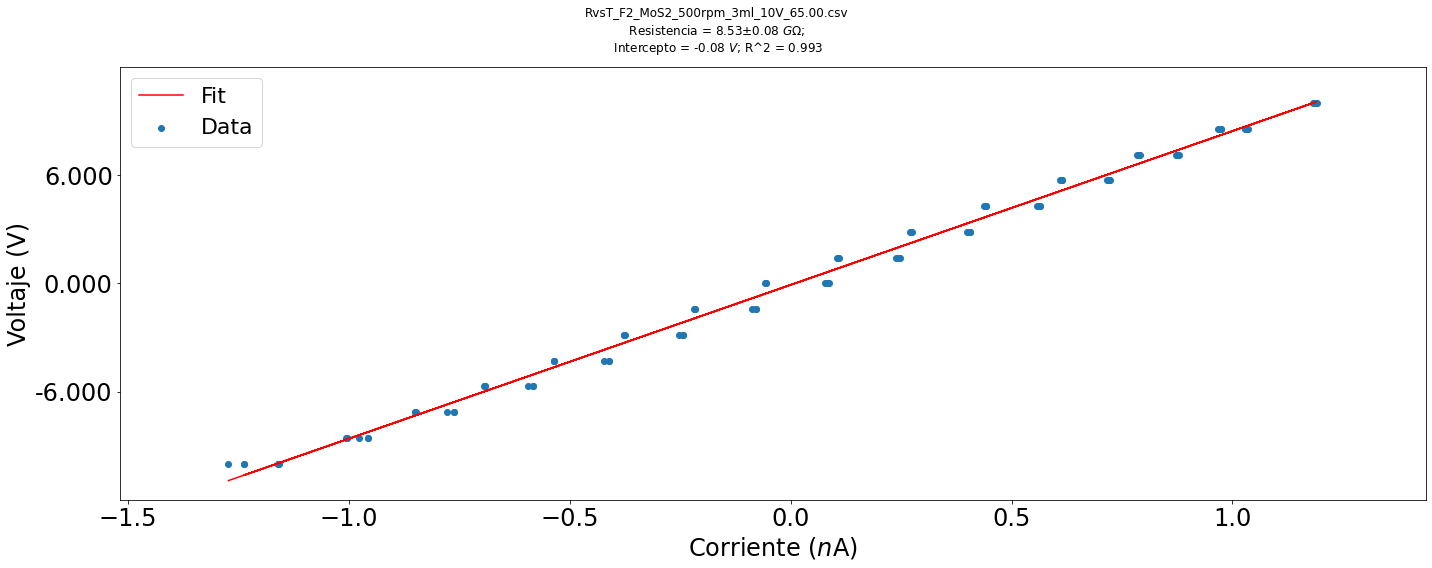

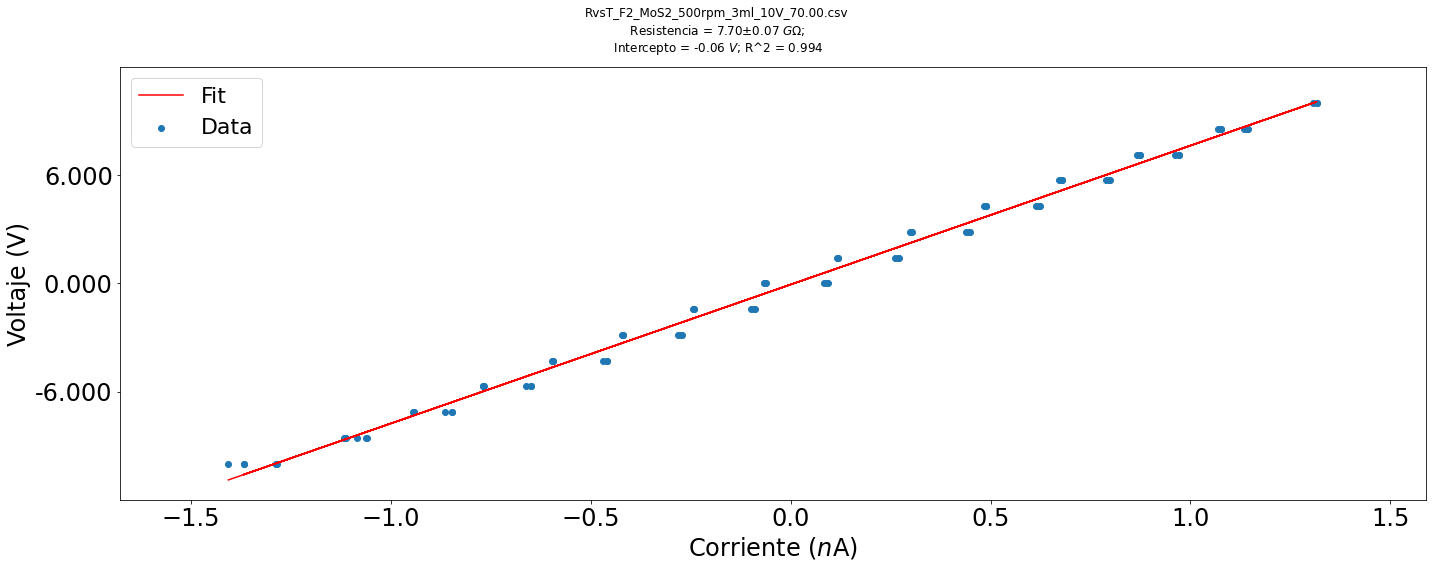

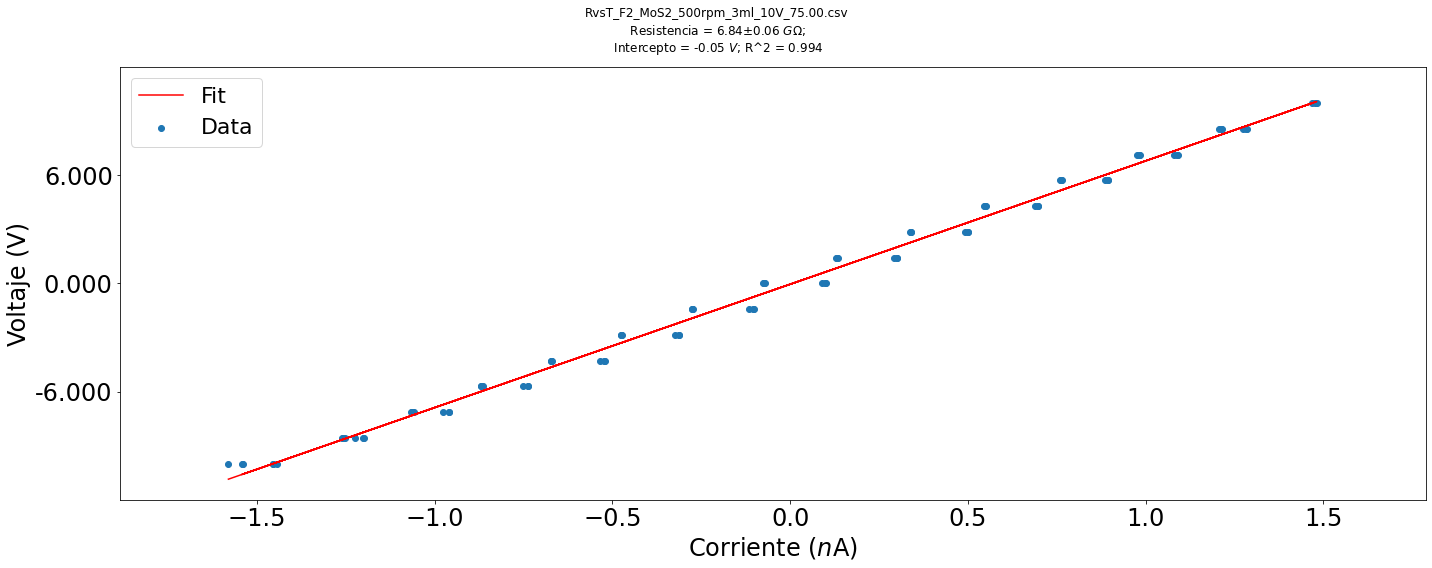

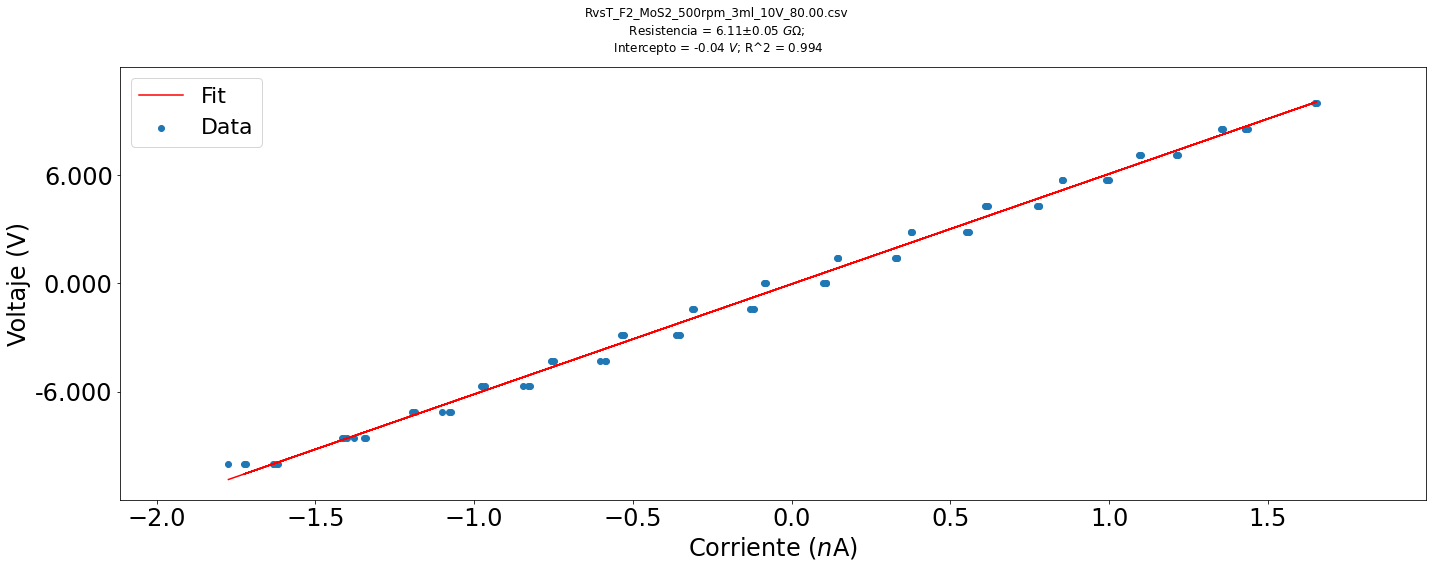

In [63]:
def generate_filenames():
    Tlist = np.linspace(-40,80,25)
    filenames = ['RvsT_F2_MoS2_500rpm_3ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-40,80,25)
d = 1.64
t = 641.6
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(25,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0]),fig.add_subplot(gs[19,0]),fig.add_subplot(gs[20,0]),fig.add_subplot(gs[21,0]),fig.add_subplot(gs[22,0]),fig.add_subplot(gs[23,0]),fig.add_subplot(gs[24,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for MoS2 (500 rpm) with volume of 3ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)

C:\Users\danie\AppData\Local\Temp/ipykernel_29092/3506226710.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1 = plt.figure(figsize=(20,8))


[6.345290738101076, 4.3738034483766235, 4.457026007967081, 4.758385895372102, 5.233354735831199, 5.6133857167180325, 3.926785779748031, 3.2249765170092464, 2.78428286516224, 2.4236551882708697, 1.9958519438886353, 1.6036824328581207, 1.304434360546437, 1.0396112206563433, 1.0195725675513791, 1.006971956010999, 0.9745559053636542, 0.9023842648039785, 0.8133103927088495, 0.7239794209160516, 0.6363598466993193, 0.5615168227094512, 0.49509783303437793, 0.4350037639587331, 0.3828808648803038]


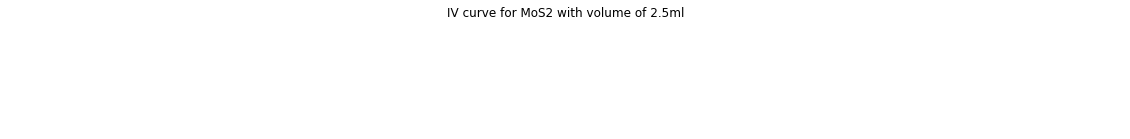

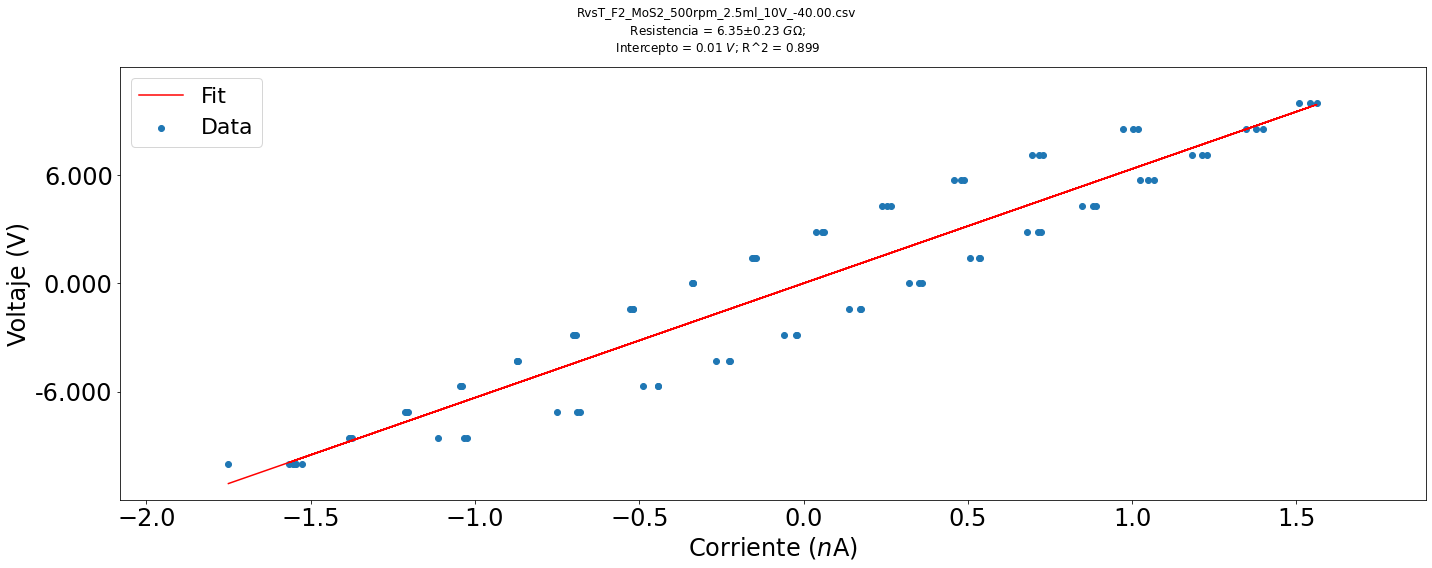

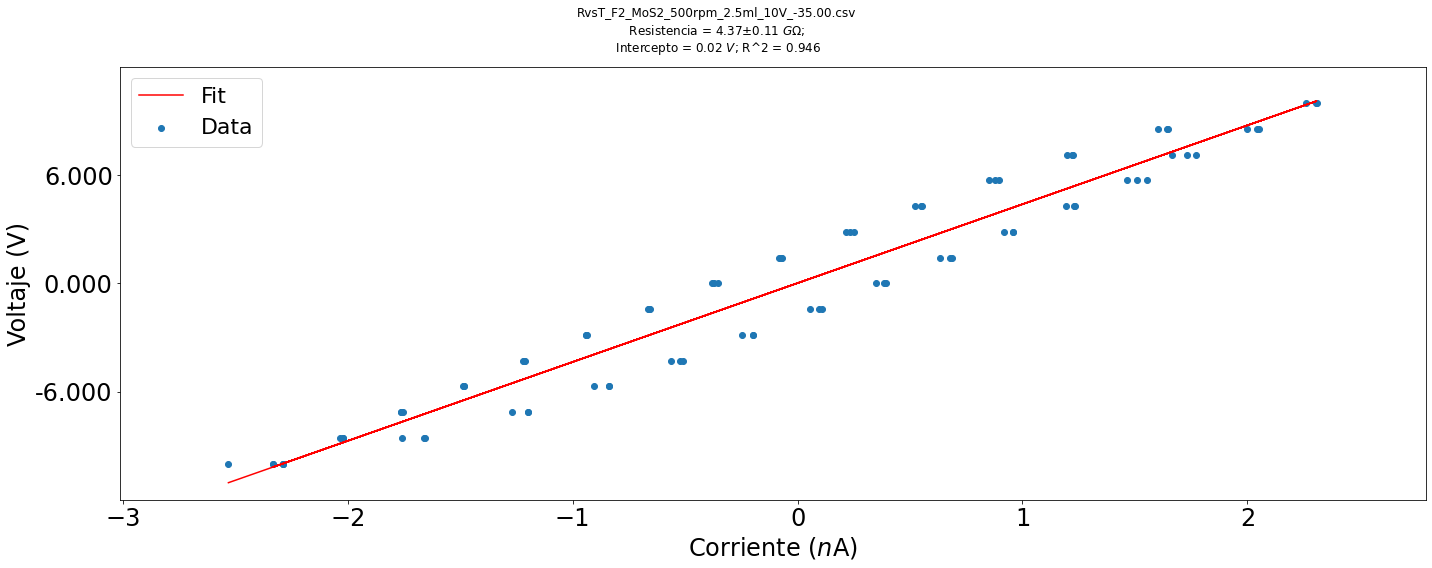

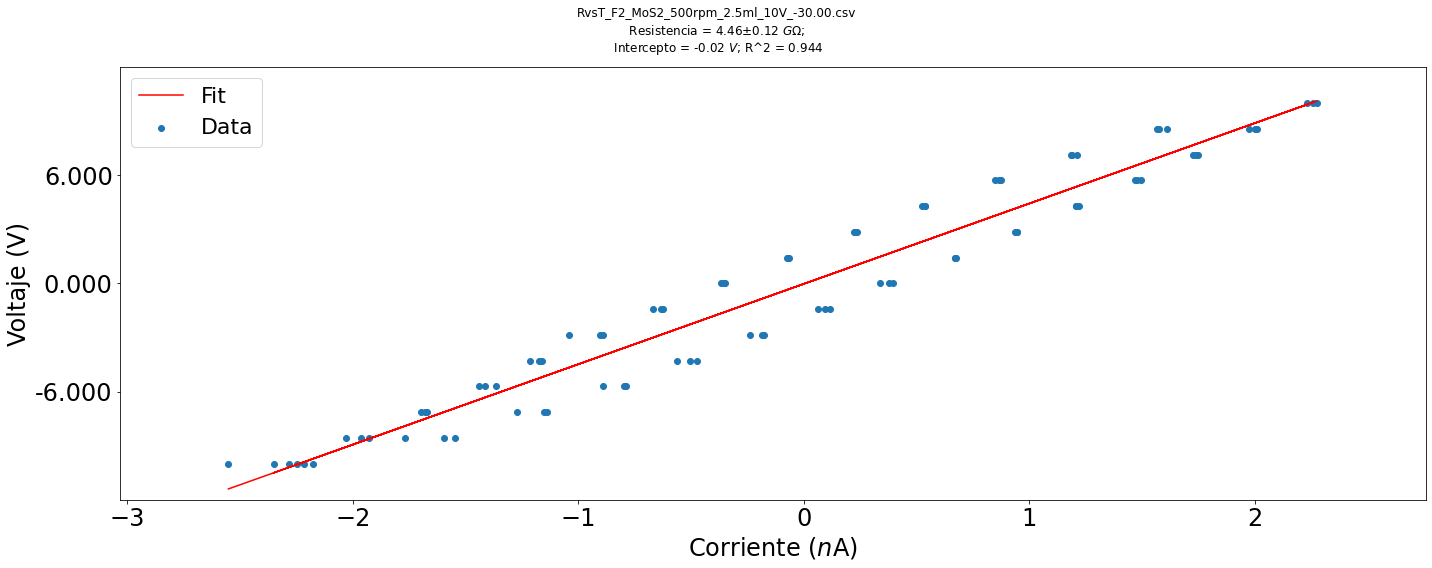

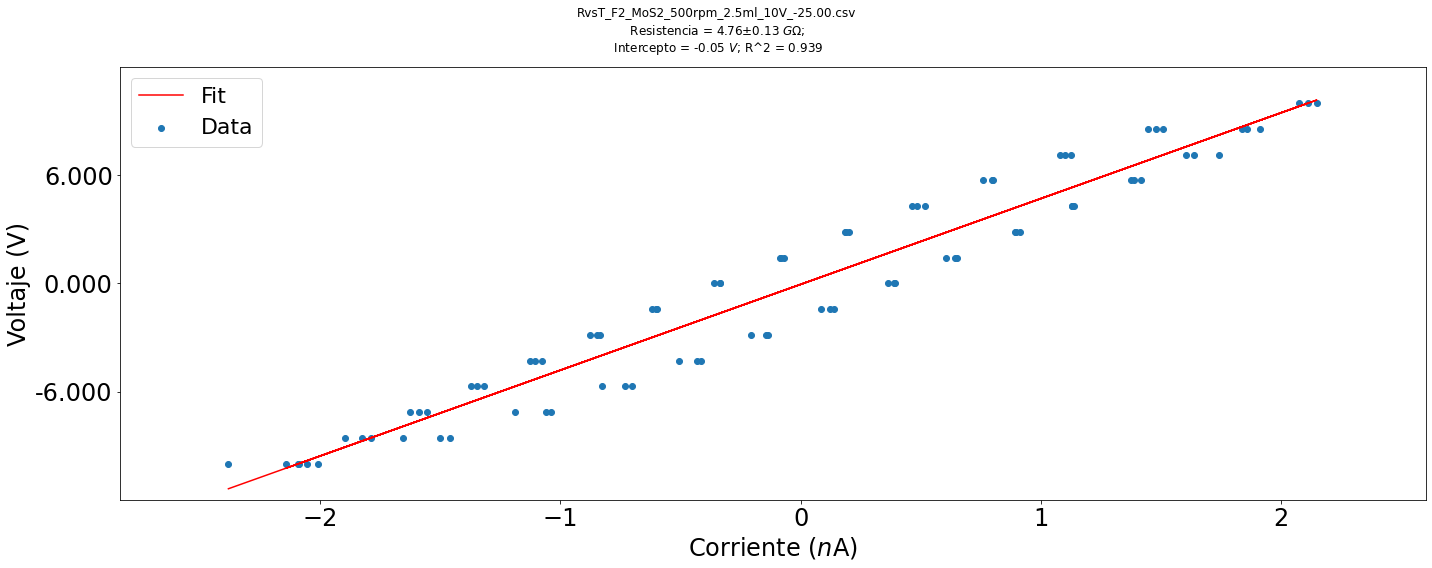

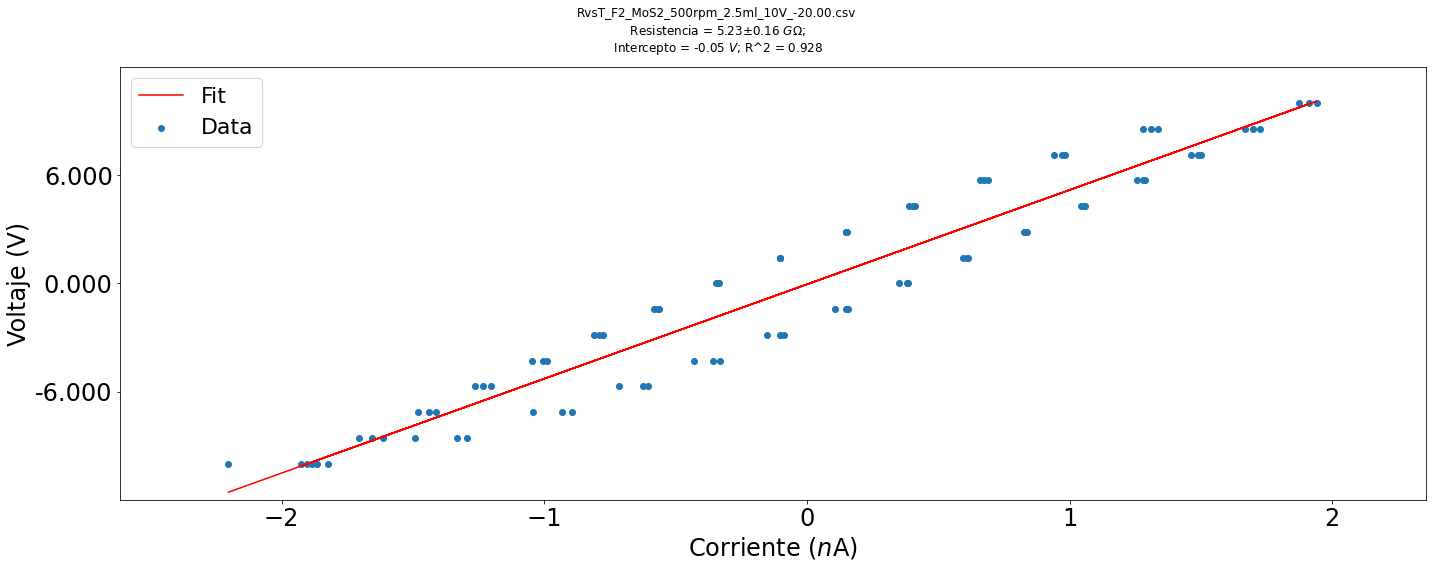

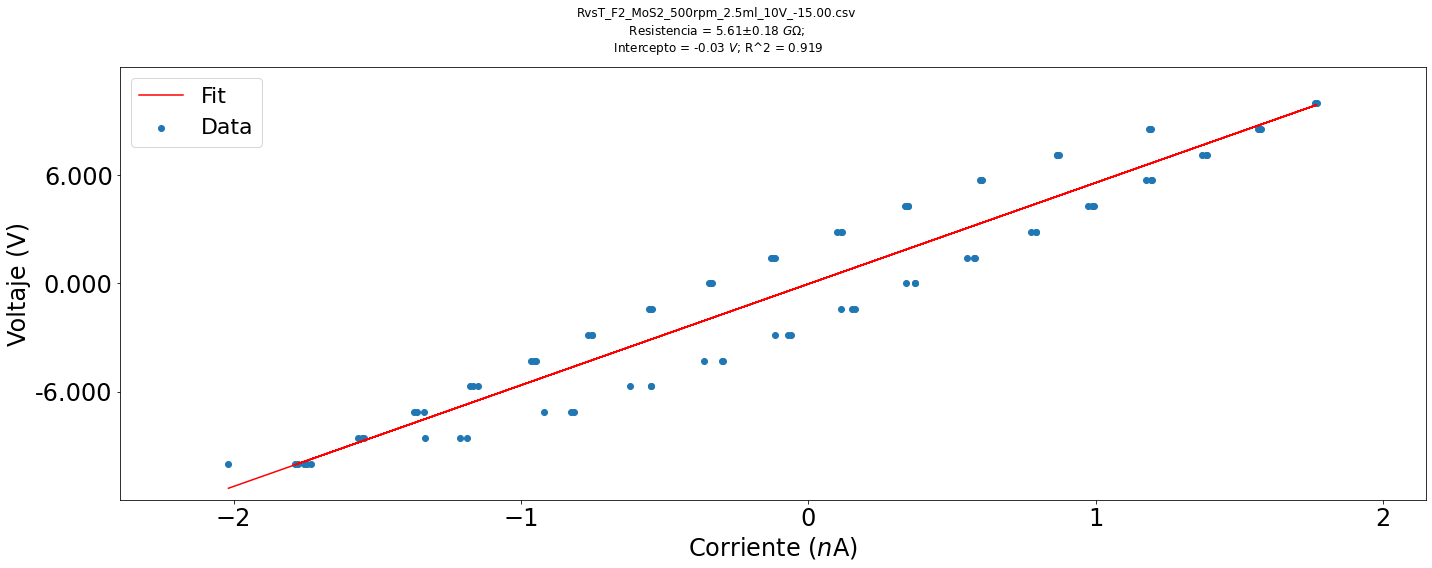

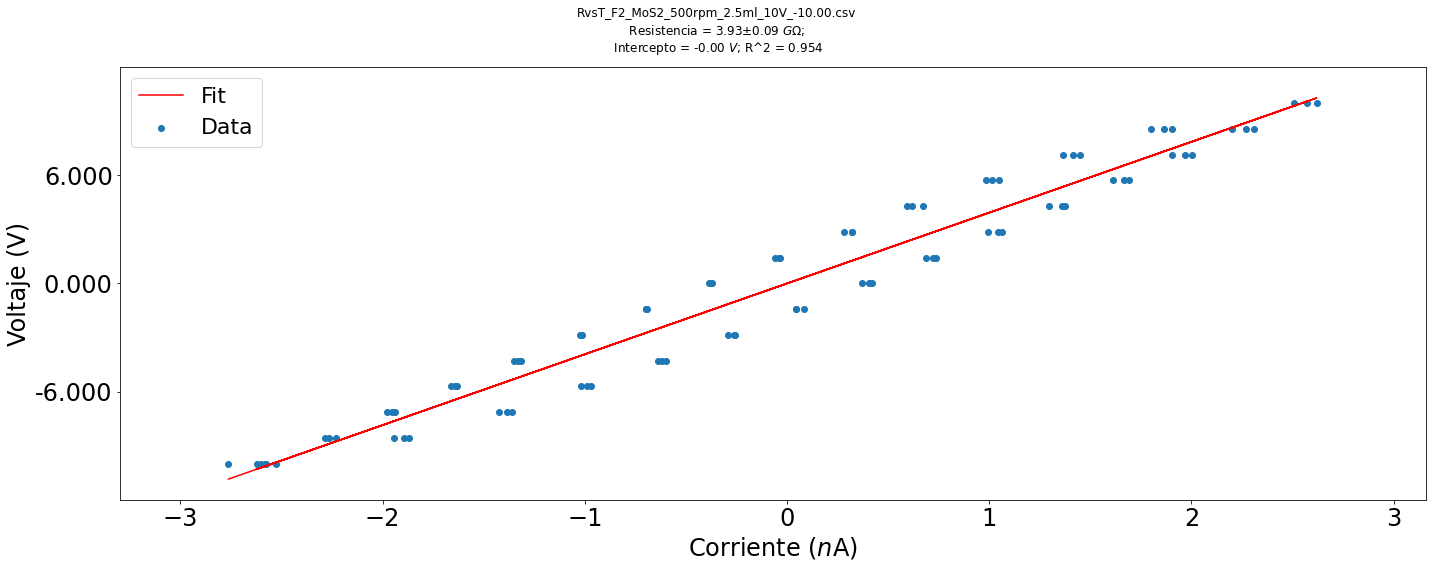

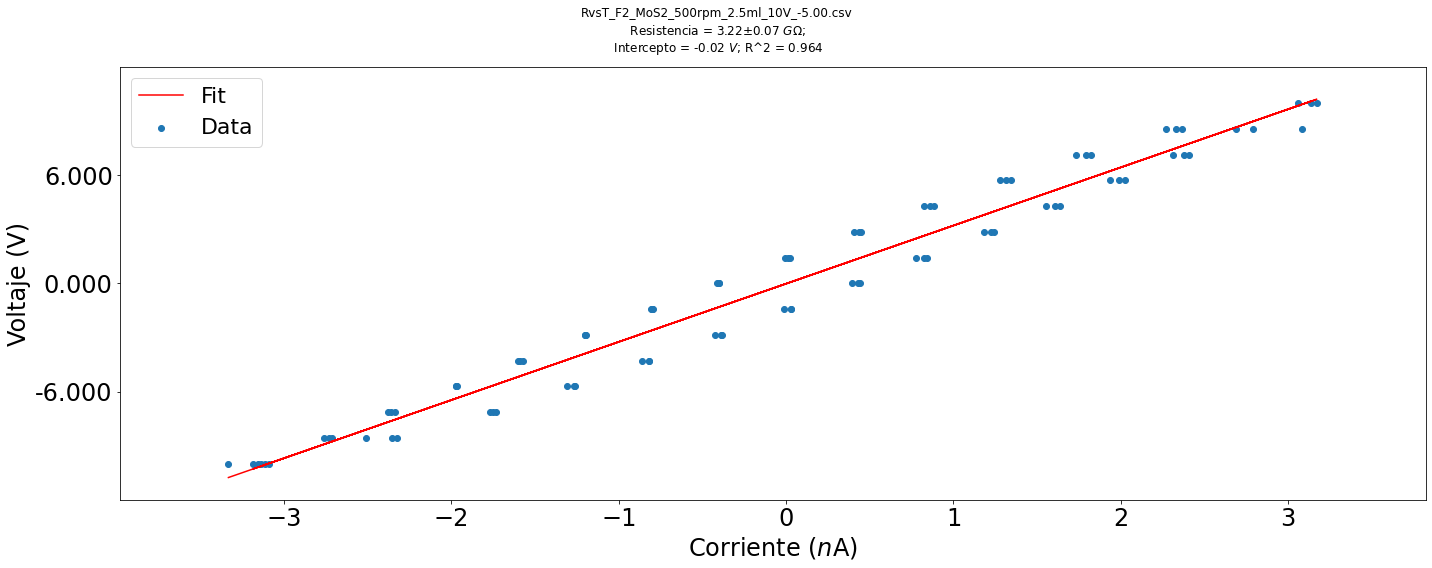

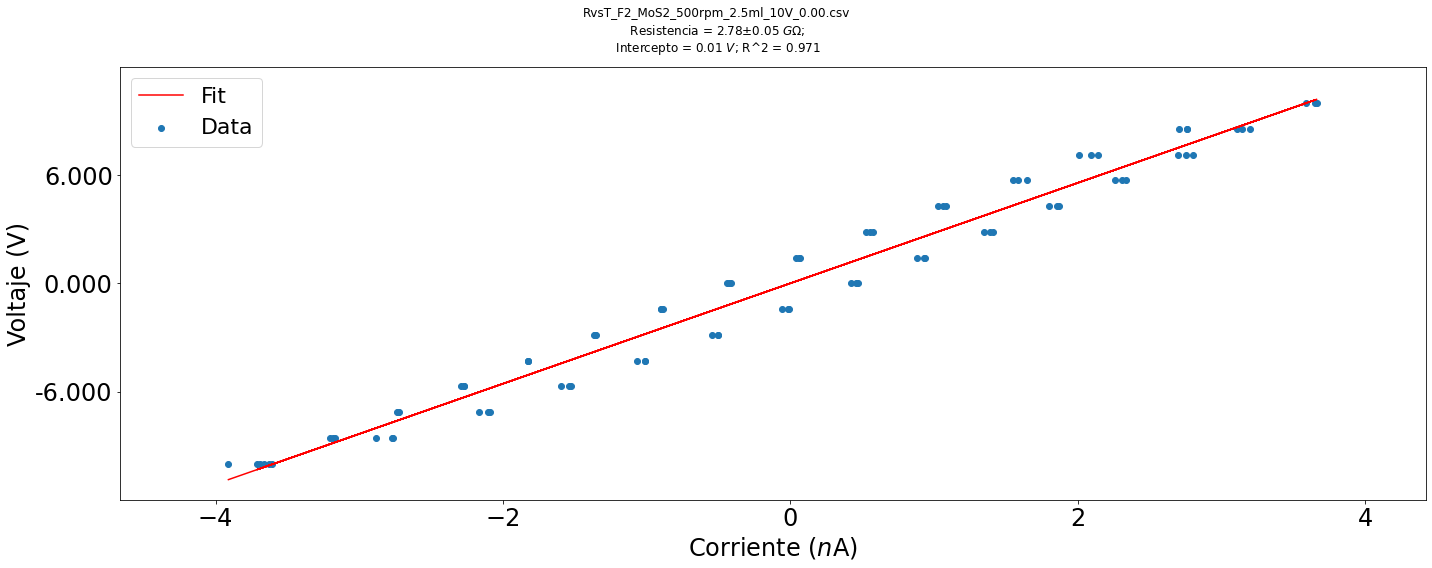

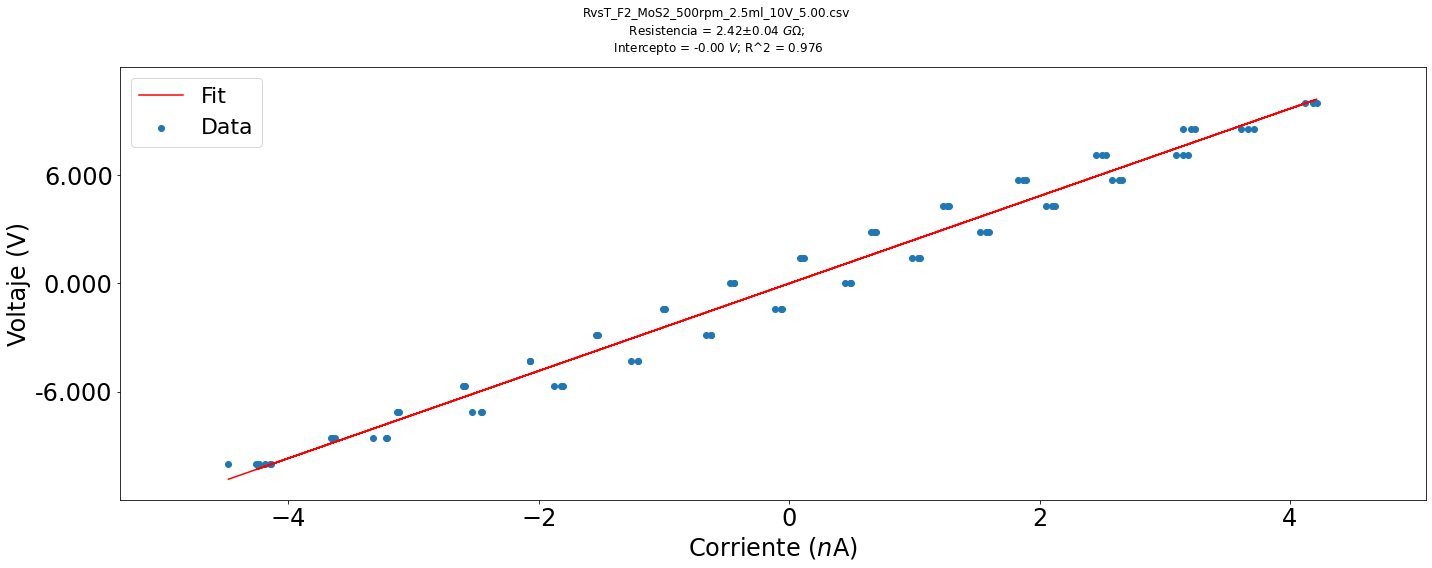

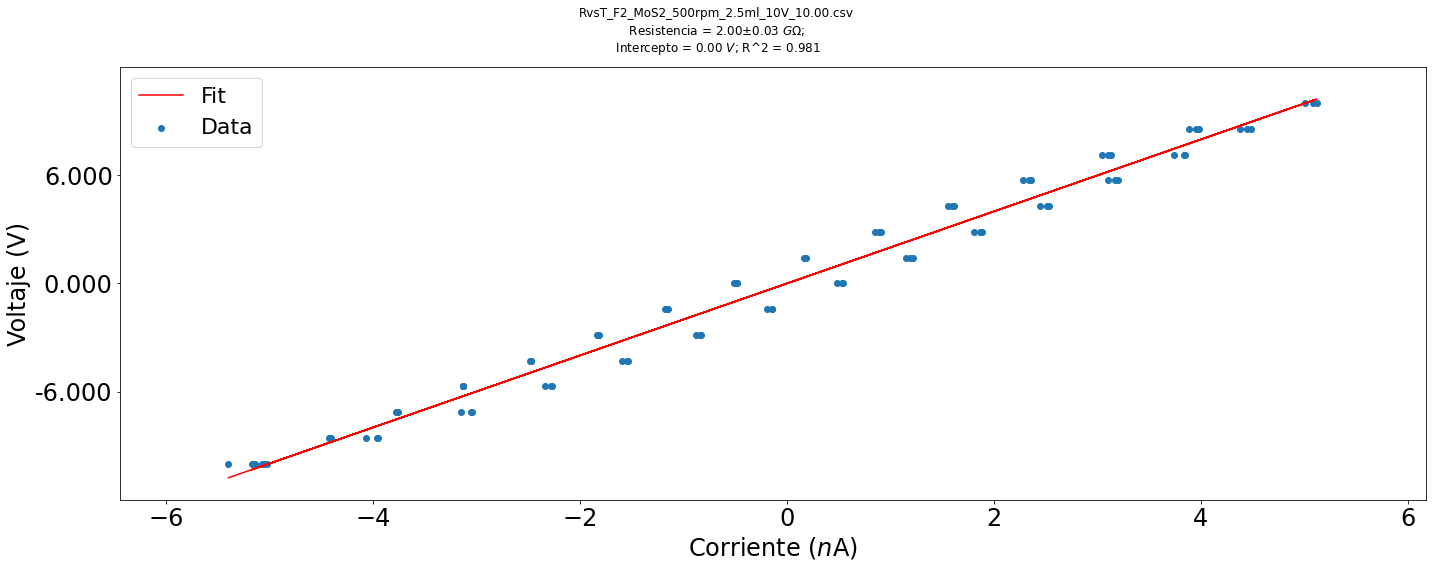

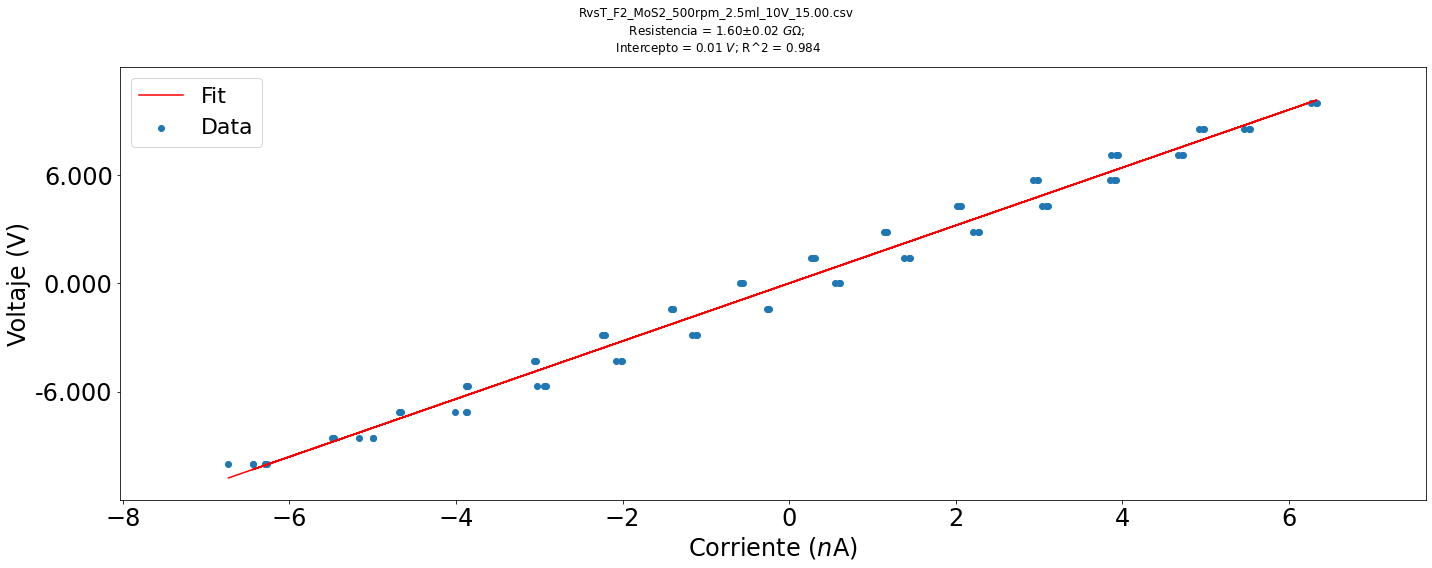

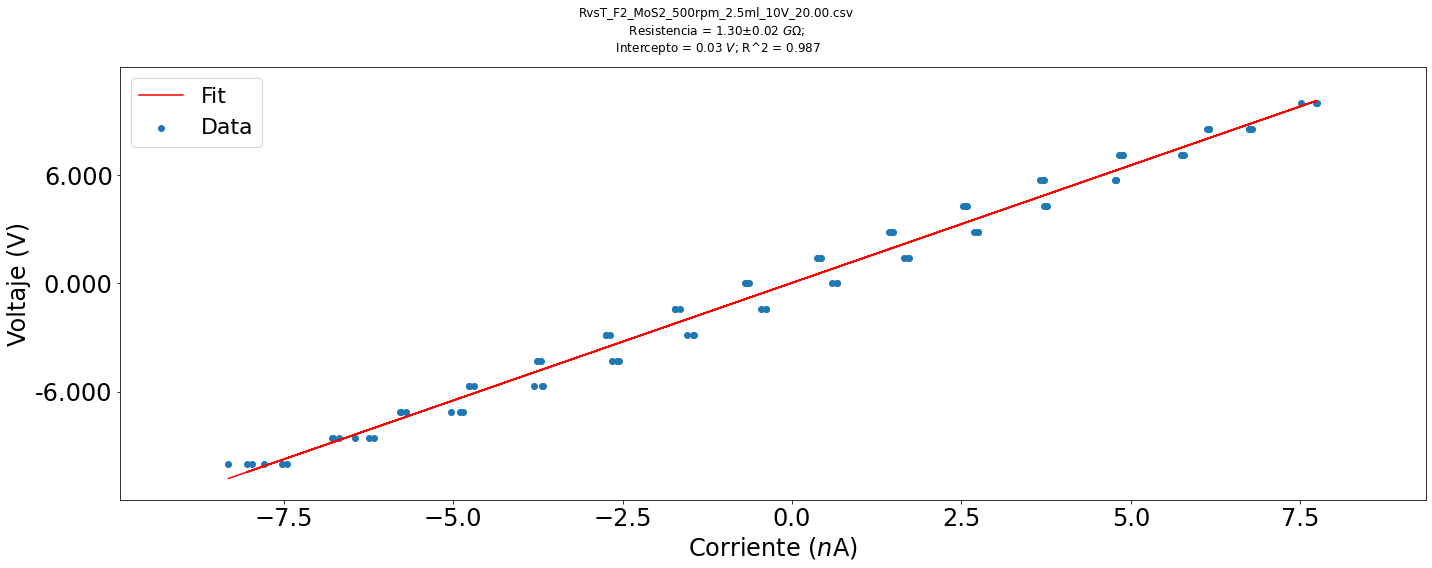

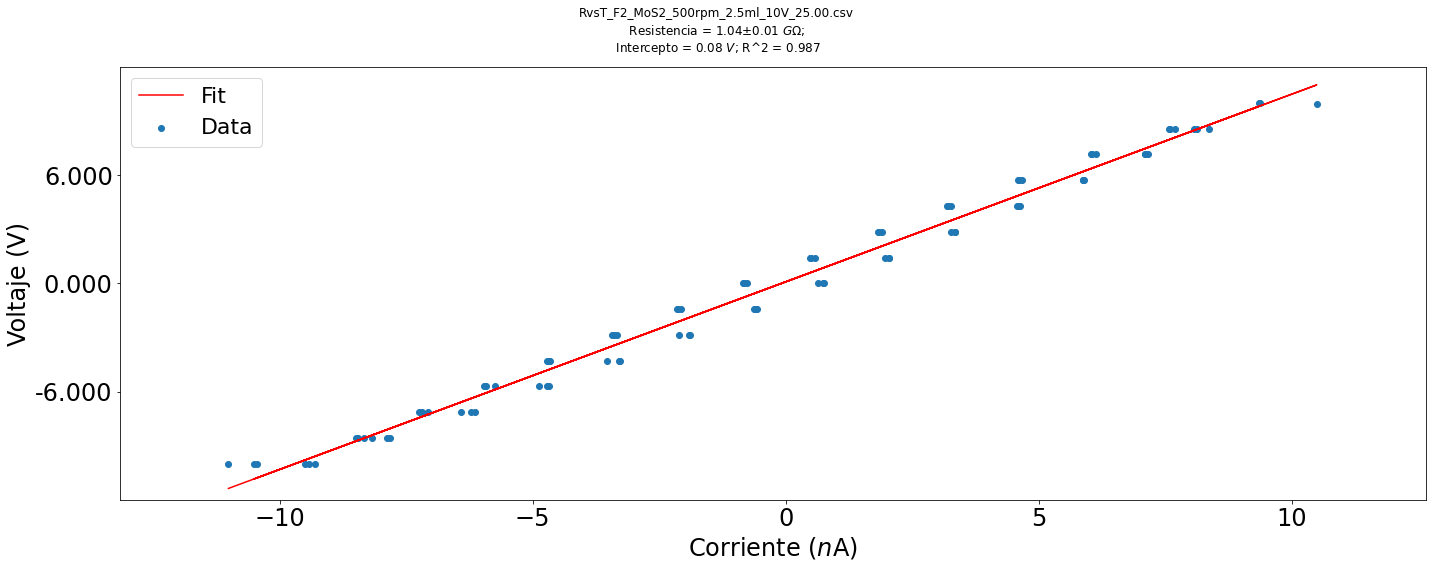

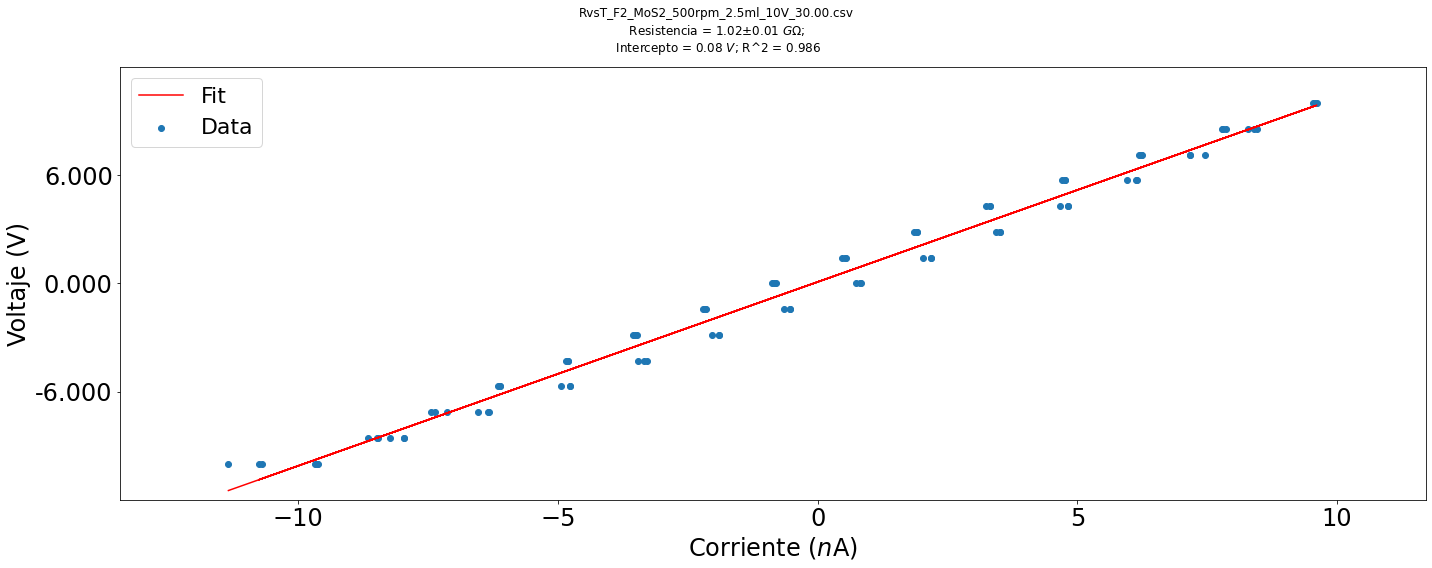

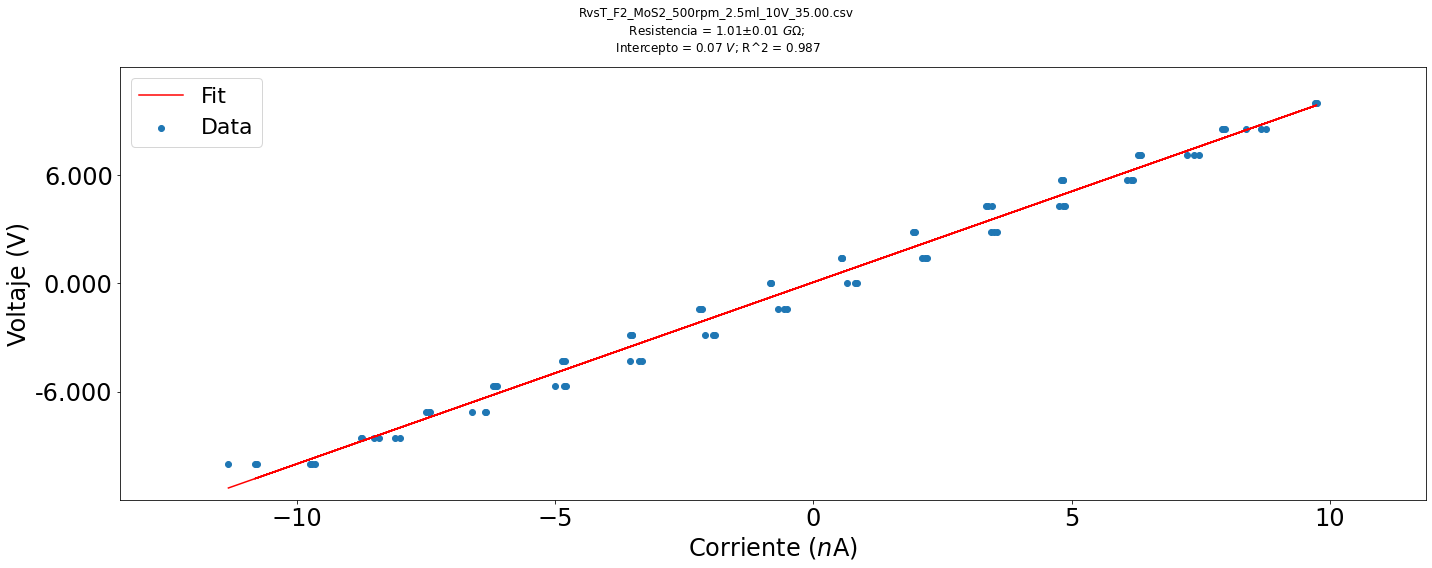

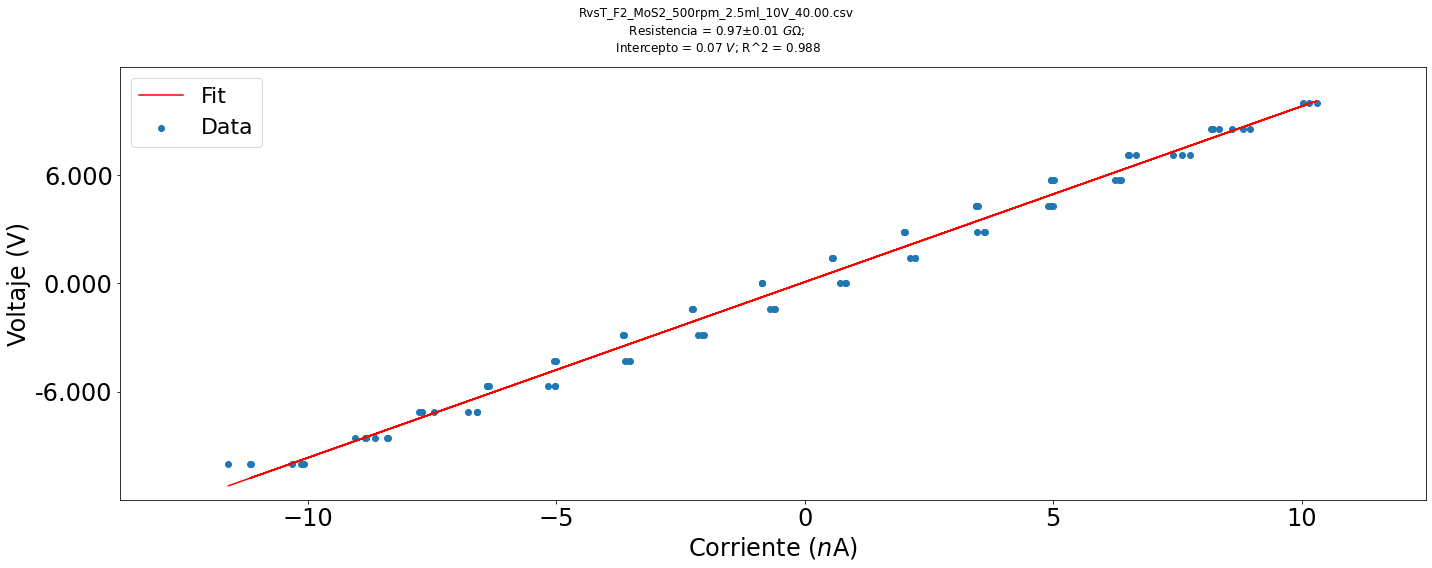

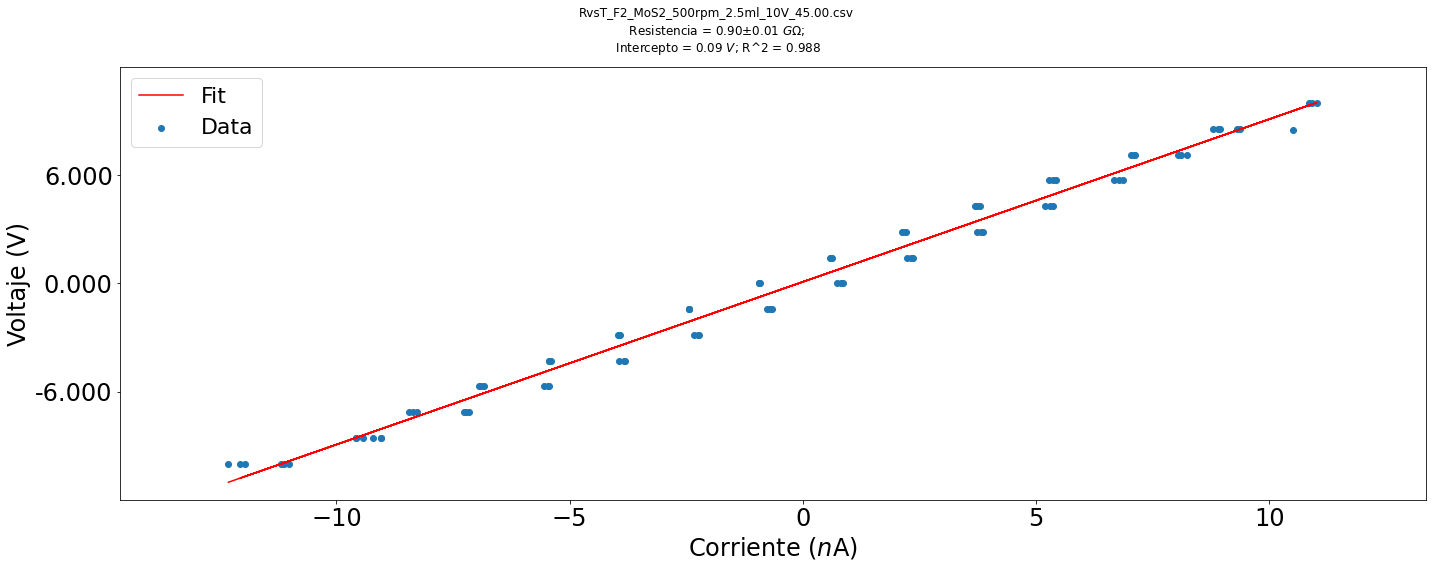

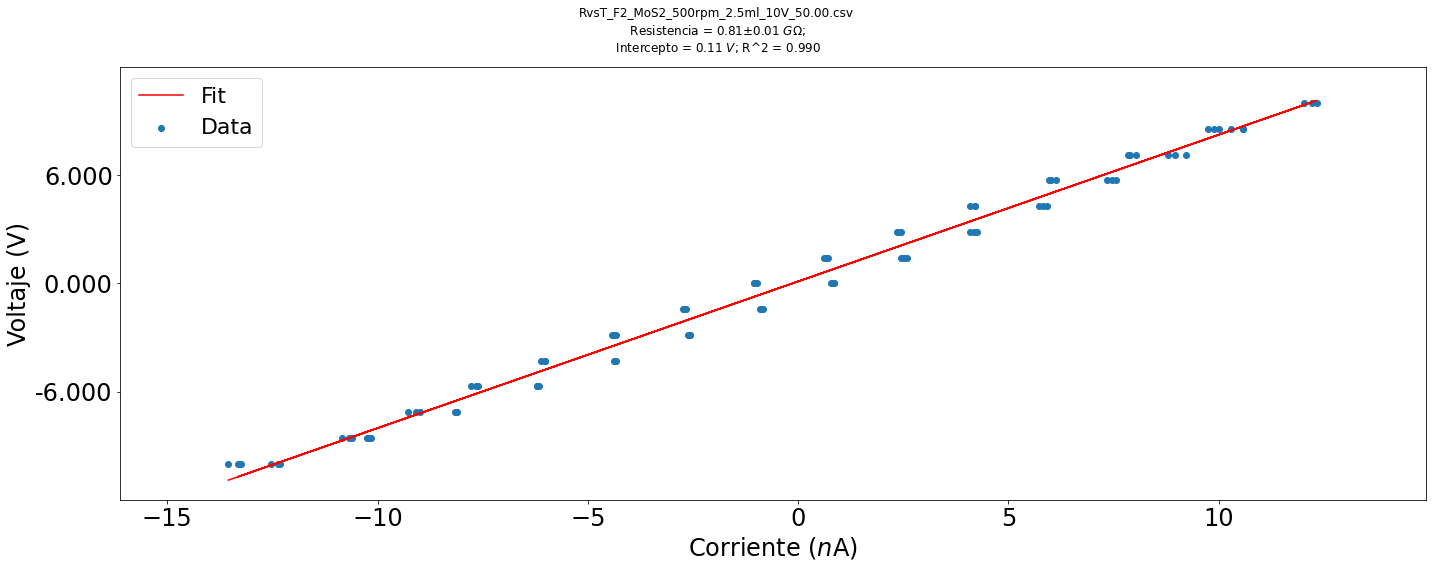

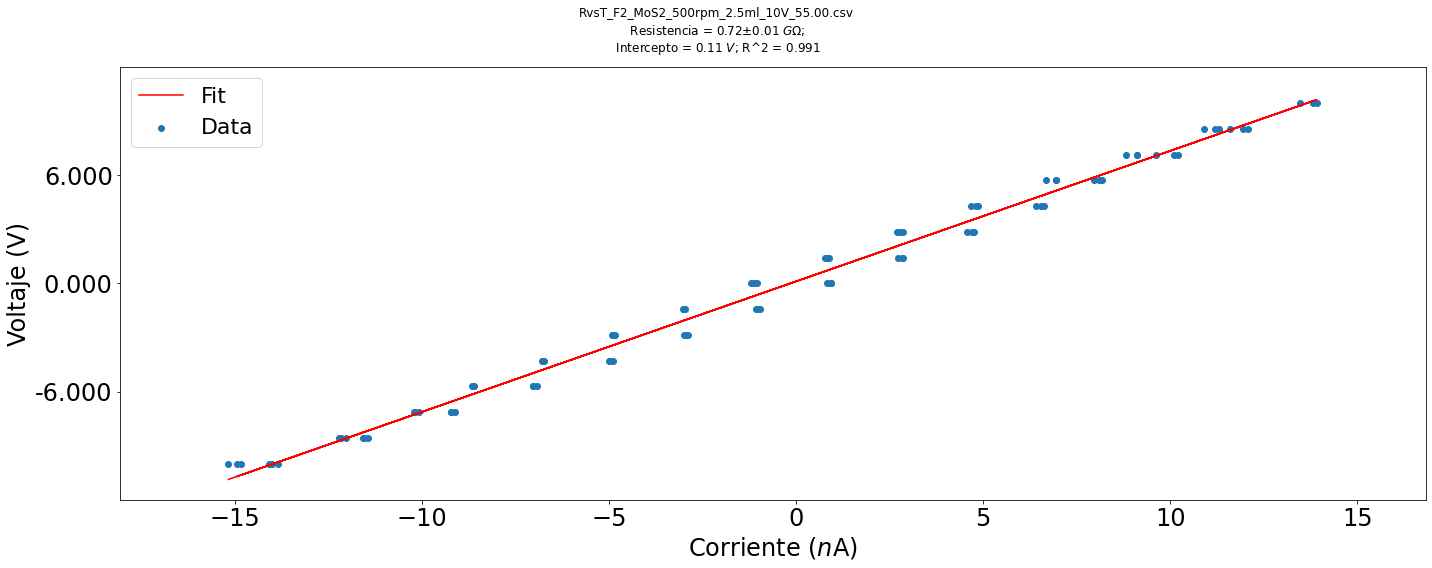

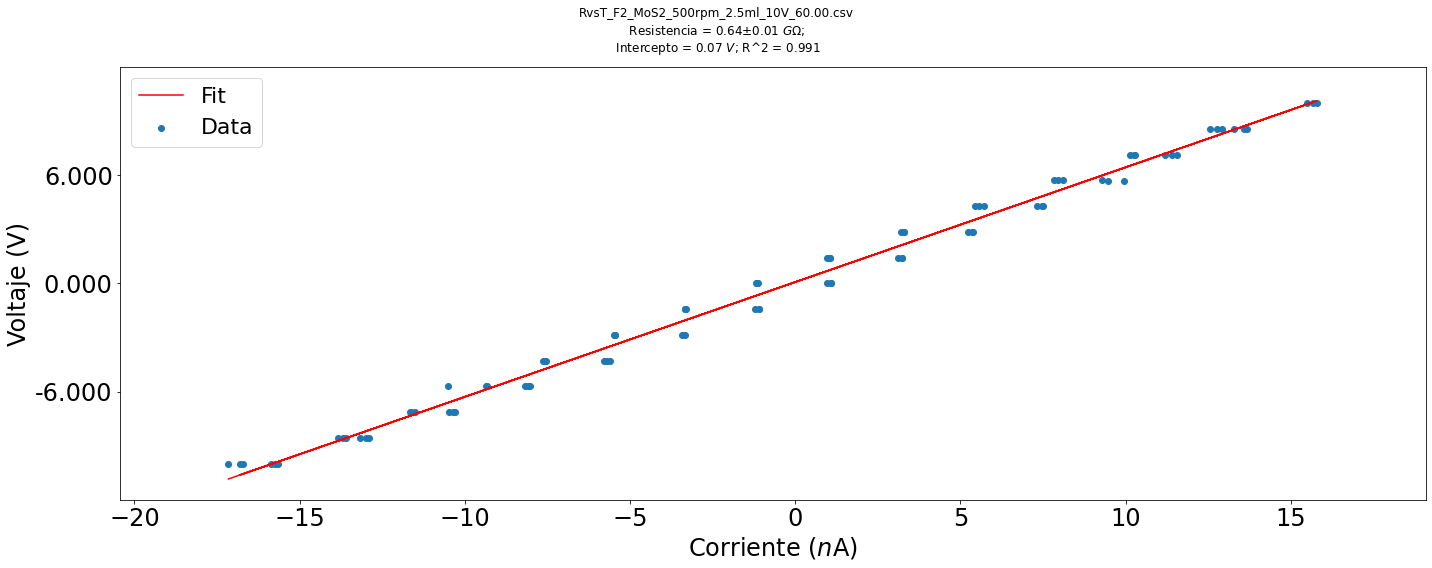

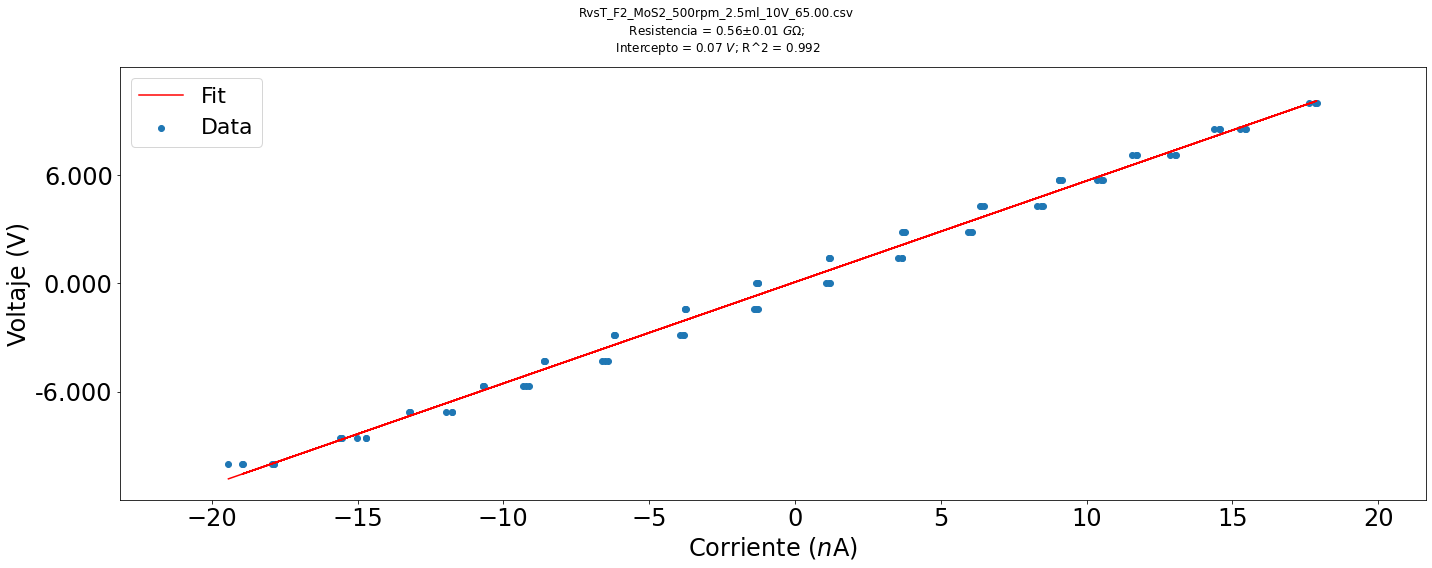

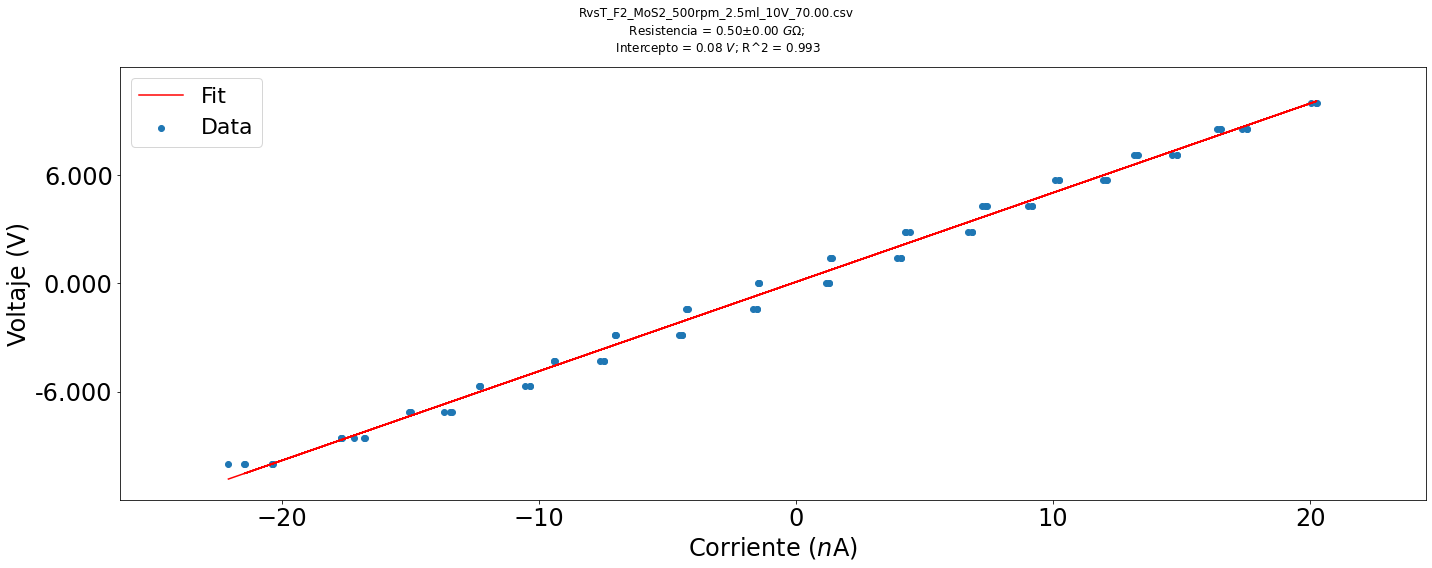

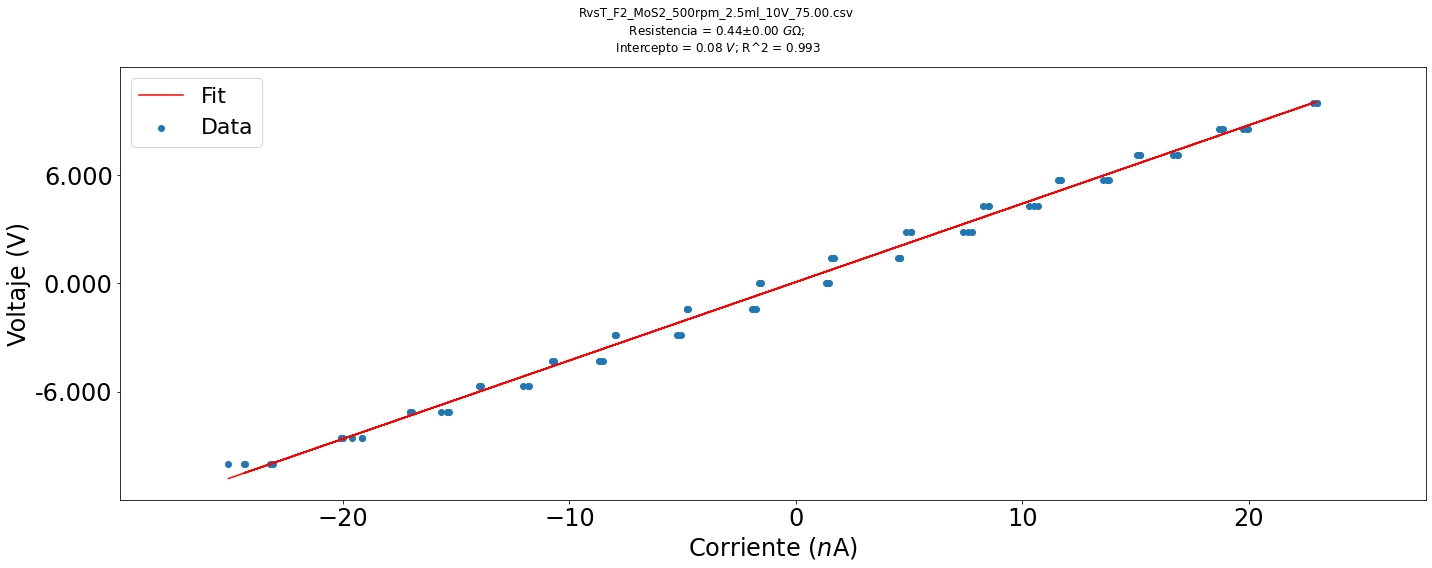

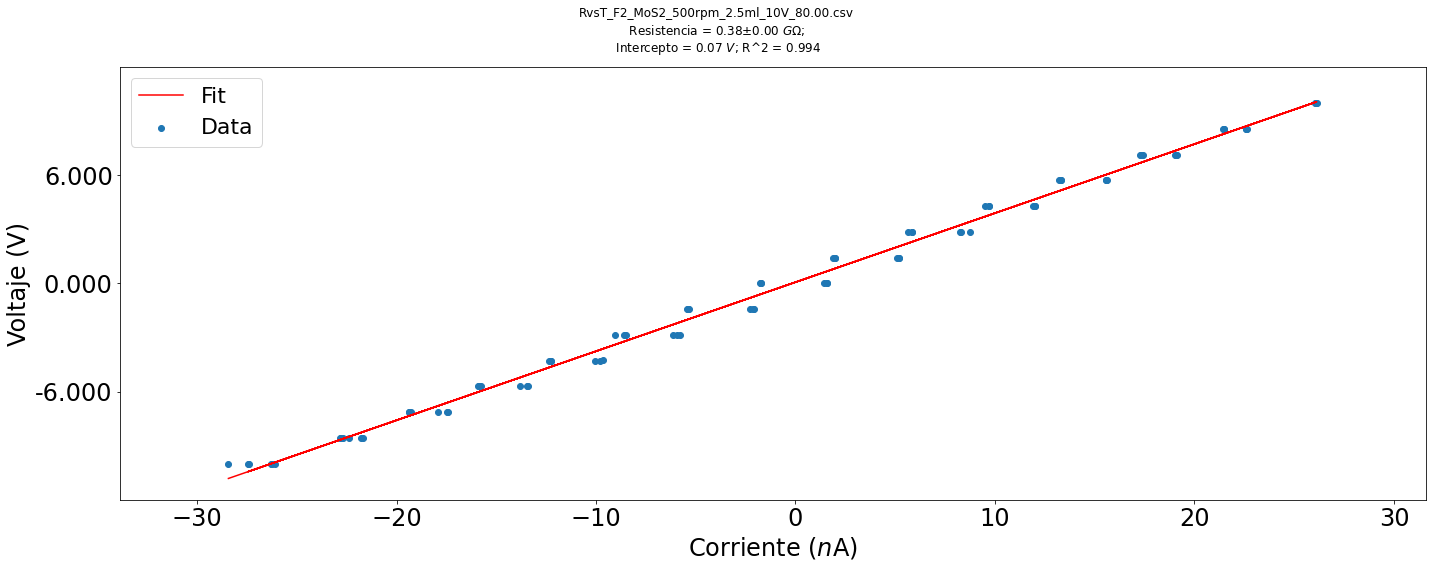

In [61]:
def generate_filenames():
    Tlist = np.linspace(-40,80,25)
    filenames = ['RvsT_F2_MoS2_500rpm_2.5ml_10V_{}0.csv'.format(T) for T in Tlist]
    return filenames

Tlist = np.linspace(-40,80,25)
d = 1.84
t = 534.7
l = 2.9

fig = plt.figure(figsize=(15,15))
gs = fig.add_gridspec(25,1,hspace=0.2)
ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24 = fig.add_subplot(gs[0,0]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[2,0]),fig.add_subplot(gs[3,0]),fig.add_subplot(gs[4,0]),fig.add_subplot(gs[5,0]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[8,0]),fig.add_subplot(gs[9,0]),fig.add_subplot(gs[10,0]),fig.add_subplot(gs[11,0]),fig.add_subplot(gs[12,0]),fig.add_subplot(gs[13,0]),fig.add_subplot(gs[14,0]),fig.add_subplot(gs[15,0]),fig.add_subplot(gs[16,0]),fig.add_subplot(gs[17,0]),fig.add_subplot(gs[18,0]),fig.add_subplot(gs[19,0]),fig.add_subplot(gs[20,0]),fig.add_subplot(gs[21,0]),fig.add_subplot(gs[22,0]),fig.add_subplot(gs[23,0]),fig.add_subplot(gs[24,0])
axes=(ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24)

i=0

filenames = generate_filenames()
plt.figure(figsize=(20,2))
plt.axis('off')
plt.title('IV curves for MoS2 with volume of 2.5ml')
slopes = []
stderrors = []
for filename in filenames:
        
    fig1 = plt.figure(figsize=(20,8))
    gs = fig1.add_gridspec(1,1,hspace=0)
    reg = fig1.add_subplot(gs[0,0])

    m,b,r_value,stderr = extraer_datos_foto(filename,reg)
    slopes.append(m)
    stderrors.append(stderr)
    fig1.suptitle(filename+'\n Resistencia = {:.2f}$\pm${:.2f} $ G\u03A9$; \n Intercepto = {:.2f} $ V$; R^2 = {:.3f}'.format(m,stderr,b,r_value))

    fig1.tight_layout()
    plt.close(fig)
#         plt.close(fig1)
#         plt.close(fig2)
i=i+1

extraer_csv(filename,Tlist,d,t,l,slopes,stderrors)

print (slopes)